In [1]:
# (Dataset is stored in google drive)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=299fed2ef8552fa1bf6fd3f30ae561dec58682eb14ab0c0a3752538e366fc245
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [3]:
# importing neccessary libraries

import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# defining all the paths

images_dir="/content/flickr8k_dataset"

images_path='/content/drive/MyDrive/archive/Images'
captions_path='/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt'

train_path = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt'


In [5]:
# getting the data from the path

captions = open(captions_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")

x_train = open(train_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [6]:
# len(x_train)

# ===================
print(len(captions))
captions[:3]

40461


['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .']

In [7]:
# making the tokens for image and captions

tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

In [8]:
# tokens

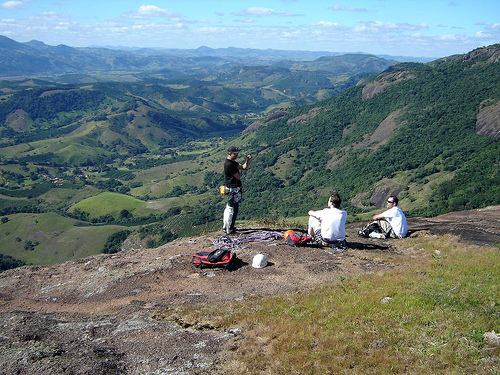

People sit on the mountainside and check out the view .
Three people are on a hilltop overlooking a green valley .
Three people hang out on top of a big hill .
Three people overlook a green valley .
Three people rest on a ledge above the moutains .


In [9]:
# !pip install Image
from IPython.display import Image, display

# just testing
temp = captions[157].split("#")
z = Image(filename = images_path + "/" + temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

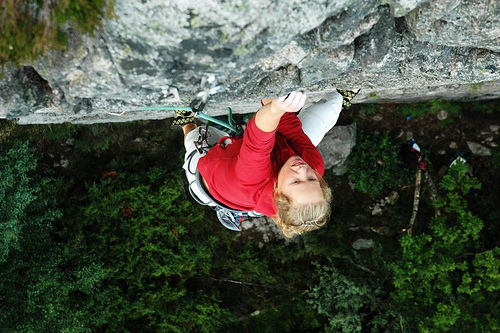

A girl in a red shirt is rock climbing .
A woman climbs up a steep rock face .
a woman wearing red , climbs up the giant rock .
A young girl with a determined expression climbing a cliff edge .
Blond woman in red top rock climbing .


In [10]:
from IPython.display import Image, display

temp = captions[5124].split("#")
z = Image(filename = images_path + "/" + temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [11]:
# Creating List of images and captions

x_imgs=[]
captions=[]
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = " "+ capt + " "
        x_imgs.append(img)
        captions.append(caption)

In [12]:
# saving images and captions in a data frame

data={'images':x_imgs,'captions':captions}
df=pd.DataFrame(data)
df.head()

,images,captions
0,2513260012_03d33305cf.jpg,A black dog is running after a white dog in t...
1,2513260012_03d33305cf.jpg,Black dog chasing brown dog through snow
2,2513260012_03d33305cf.jpg,Two dogs chase each other across the snowy gr...
3,2513260012_03d33305cf.jpg,Two dogs play together in the snow .
4,2513260012_03d33305cf.jpg,Two dogs running through a low lying body of ...


In [13]:
# preprocessing of data on the captions

words = [i.split() for i in captions]
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))
print(len(unique))
vocab_size = len(unique)

8251


In [14]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [15]:
word_2_indices['GF'] = 0
indices_2_word[0] = 'GF'

In [16]:
# using the pickle to save the modal

with open( "w2i.p", "wb" ) as pickle_f:
    pickle.dump(word_2_indices, pickle_f )
with open( "i2w.p", "wb" ) as pickle_f:
    pickle.dump(indices_2_word, pickle_f )

In [17]:

vocab_size = len(word_2_indices.keys())
print(vocab_size)


8252


In [18]:

max_len = 0
for i in captions:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

38


In [19]:
padded_sequences, subsequent_words = [], []
for ix in tqdm(range(len(captions))):
    partial_seqs = []
    next_words = []
    text = captions[ix].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')
    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)

    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1

    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)

  0%|          | 0/30000 [00:00<?, ?it/s]<ipython-input-19-e47b6c6c6d98>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
100%|██████████| 30000/30000 [00:03<00:00, 8039.04it/s]


In [20]:
# Loading ResNet Model

model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [21]:
# processing on the images

def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [22]:

imgs={}
for i in tqdm(x_train[:6000]):
    if i in imgs.keys():
        continue
    path = images_path + "/"+ i
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    imgs[i]=pred

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|          | 1/6000 [00:03<6:25:39,  3.86s/it]

1/1 [==============================] - 0s 23ms/step


  0%|          | 2/6000 [00:04<2:57:32,  1.78s/it]

1/1 [==============================] - 0s 27ms/step


  0%|          | 3/6000 [00:04<1:58:30,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 4/6000 [00:05<1:28:01,  1.14it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 5/6000 [00:05<1:07:48,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 6/6000 [00:05<56:58,  1.75it/s]  

1/1 [==============================] - 0s 22ms/step


  0%|          | 7/6000 [00:06<54:16,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 8/6000 [00:06<51:37,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 9/6000 [00:07<45:34,  2.19it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 10/6000 [00:07<42:58,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 11/6000 [00:07<42:38,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 12/6000 [00:08<42:02,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 13/6000 [00:08<42:31,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 14/6000 [00:09<41:30,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 15/6000 [00:09<41:44,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 16/6000 [00:09<42:24,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 17/6000 [00:10<43:16,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 18/6000 [00:10<40:52,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 19/6000 [00:11<40:52,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 20/6000 [00:11<40:12,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 21/6000 [00:11<40:51,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 22/6000 [00:12<41:53,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 23/6000 [00:12<42:24,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 24/6000 [00:13<39:01,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 25/6000 [00:13<38:22,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 26/6000 [00:13<40:06,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 27/6000 [00:14<40:59,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 28/6000 [00:14<39:25,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 29/6000 [00:15<41:03,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 30/6000 [00:15<42:47,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 31/6000 [00:16<39:57,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 32/6000 [00:16<39:23,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 33/6000 [00:16<37:20,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 34/6000 [00:17<37:22,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 35/6000 [00:17<36:37,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 36/6000 [00:17<34:37,  2.87it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 37/6000 [00:18<36:21,  2.73it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 38/6000 [00:18<34:24,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 39/6000 [00:18<36:23,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 40/6000 [00:19<35:09,  2.82it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 41/6000 [00:19<39:58,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 42/6000 [00:20<39:17,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 43/6000 [00:20<39:07,  2.54it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 44/6000 [00:20<40:30,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 45/6000 [00:21<39:41,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 46/6000 [00:21<41:59,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 47/6000 [00:22<42:33,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 48/6000 [00:22<44:02,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 49/6000 [00:23<41:27,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 50/6000 [00:23<43:31,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 51/6000 [00:23<41:30,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 52/6000 [00:24<41:09,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 53/6000 [00:24<44:14,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 54/6000 [00:25<43:12,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 55/6000 [00:25<41:50,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 56/6000 [00:26<40:24,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 57/6000 [00:26<44:08,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 58/6000 [00:26<43:57,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 59/6000 [00:27<45:44,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 60/6000 [00:27<42:05,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 61/6000 [00:28<41:14,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 62/6000 [00:28<43:08,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 63/6000 [00:29<43:00,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 64/6000 [00:29<42:24,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 65/6000 [00:30<44:04,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 66/6000 [00:30<40:51,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 67/6000 [00:30<38:38,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 68/6000 [00:31<42:15,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 69/6000 [00:31<41:38,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 70/6000 [00:31<38:36,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 71/6000 [00:32<40:12,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 72/6000 [00:32<41:50,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 73/6000 [00:33<41:00,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 74/6000 [00:33<42:47,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 75/6000 [00:34<44:19,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 76/6000 [00:34<44:24,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 77/6000 [00:35<40:53,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 78/6000 [00:35<39:52,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 79/6000 [00:35<38:05,  2.59it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 80/6000 [00:36<37:08,  2.66it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 81/6000 [00:36<39:00,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 82/6000 [00:36<39:38,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 83/6000 [00:37<40:48,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 84/6000 [00:37<45:15,  2.18it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▏         | 85/6000 [00:38<49:28,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 86/6000 [00:39<48:35,  2.03it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▏         | 87/6000 [00:39<52:38,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 88/6000 [00:40<51:22,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 89/6000 [00:40<47:44,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 90/6000 [00:40<44:01,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 91/6000 [00:41<41:16,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 92/6000 [00:41<43:36,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 93/6000 [00:42<42:54,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 94/6000 [00:42<47:32,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 95/6000 [00:43<45:00,  2.19it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 96/6000 [00:43<42:29,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 97/6000 [00:43<41:37,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 98/6000 [00:44<41:42,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 99/6000 [00:44<39:31,  2.49it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 100/6000 [00:45<43:02,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 101/6000 [00:45<43:51,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 102/6000 [00:46<43:23,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 103/6000 [00:46<40:46,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 104/6000 [00:46<38:58,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 105/6000 [00:47<38:57,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 106/6000 [00:47<40:33,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 107/6000 [00:48<40:45,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 108/6000 [00:48<39:11,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 109/6000 [00:48<38:39,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 110/6000 [00:49<38:13,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 111/6000 [00:49<35:57,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 112/6000 [00:49<37:16,  2.63it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 113/6000 [00:50<40:26,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 114/6000 [00:50<40:08,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 115/6000 [00:51<39:53,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 116/6000 [00:51<37:40,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 117/6000 [00:51<36:23,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 118/6000 [00:52<35:09,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 119/6000 [00:52<34:01,  2.88it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 120/6000 [00:52<34:41,  2.82it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 121/6000 [00:53<45:00,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 122/6000 [00:54<44:01,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 123/6000 [00:54<43:05,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 124/6000 [00:54<40:06,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 125/6000 [00:55<39:32,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 126/6000 [00:55<39:37,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 127/6000 [00:56<42:00,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 128/6000 [00:56<50:46,  1.93it/s]

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 129/6000 [00:57<53:16,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 130/6000 [00:57<49:28,  1.98it/s]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 131/6000 [00:58<46:54,  2.09it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 132/6000 [00:58<46:20,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 133/6000 [00:59<43:19,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 134/6000 [00:59<42:35,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 135/6000 [00:59<40:57,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 136/6000 [01:00<39:19,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 137/6000 [01:00<37:15,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 138/6000 [01:00<36:49,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 139/6000 [01:01<41:02,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 140/6000 [01:01<40:57,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 141/6000 [01:02<41:44,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 142/6000 [01:02<47:18,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 143/6000 [01:03<42:46,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 144/6000 [01:03<40:16,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 145/6000 [01:04<40:19,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 146/6000 [01:04<39:32,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 147/6000 [01:04<41:56,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 148/6000 [01:05<42:18,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 149/6000 [01:05<40:52,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▎         | 150/6000 [01:06<42:46,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 151/6000 [01:06<42:55,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 152/6000 [01:07<41:21,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 153/6000 [01:07<43:24,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 154/6000 [01:08<43:01,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 155/6000 [01:08<42:38,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 156/6000 [01:08<43:57,  2.22it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 157/6000 [01:09<42:19,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 158/6000 [01:09<39:21,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 159/6000 [01:10<38:40,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 160/6000 [01:10<41:33,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 161/6000 [01:10<40:19,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 162/6000 [01:11<40:00,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 163/6000 [01:11<38:42,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 164/6000 [01:12<39:15,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 165/6000 [01:12<39:00,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 166/6000 [01:12<37:56,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 167/6000 [01:13<36:27,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 168/6000 [01:13<38:15,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 169/6000 [01:14<37:50,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 170/6000 [01:14<38:29,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 171/6000 [01:14<39:41,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 172/6000 [01:15<41:28,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 173/6000 [01:15<39:59,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 174/6000 [01:16<38:59,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 175/6000 [01:16<41:56,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 176/6000 [01:16<40:51,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 177/6000 [01:17<39:42,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 178/6000 [01:17<39:53,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 179/6000 [01:18<39:54,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 180/6000 [01:18<42:35,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 181/6000 [01:19<42:19,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 182/6000 [01:19<40:19,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 183/6000 [01:19<40:25,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 184/6000 [01:20<38:12,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 185/6000 [01:20<38:21,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 186/6000 [01:21<38:51,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 187/6000 [01:21<39:23,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 188/6000 [01:21<41:07,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 189/6000 [01:22<41:02,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 190/6000 [01:22<38:49,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 191/6000 [01:23<37:57,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 192/6000 [01:23<37:39,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 193/6000 [01:23<36:50,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 194/6000 [01:24<34:31,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 195/6000 [01:24<36:19,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 196/6000 [01:24<36:26,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 197/6000 [01:25<41:00,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 198/6000 [01:25<39:39,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 199/6000 [01:26<38:27,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 200/6000 [01:26<38:08,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 201/6000 [01:27<40:17,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 202/6000 [01:27<38:04,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 203/6000 [01:27<37:22,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 204/6000 [01:28<37:28,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 205/6000 [01:28<36:43,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 206/6000 [01:29<39:38,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 207/6000 [01:29<40:51,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 208/6000 [01:29<40:24,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 209/6000 [01:30<40:52,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 210/6000 [01:30<39:52,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 211/6000 [01:31<39:05,  2.47it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 212/6000 [01:31<38:56,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 213/6000 [01:31<36:44,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 214/6000 [01:32<36:39,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 215/6000 [01:32<37:20,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 216/6000 [01:33<38:44,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 217/6000 [01:33<42:20,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 218/6000 [01:34<42:28,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 219/6000 [01:34<41:08,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 220/6000 [01:34<40:33,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 221/6000 [01:35<43:17,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 222/6000 [01:35<42:16,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 223/6000 [01:36<40:40,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 224/6000 [01:36<38:09,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 225/6000 [01:36<39:13,  2.45it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 226/6000 [01:37<40:39,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 227/6000 [01:37<43:35,  2.21it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 228/6000 [01:38<44:01,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 229/6000 [01:38<41:18,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 230/6000 [01:39<40:23,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 231/6000 [01:39<37:43,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 232/6000 [01:39<38:42,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 233/6000 [01:40<36:21,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 234/6000 [01:40<36:52,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 235/6000 [01:40<36:56,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 236/6000 [01:41<39:08,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 237/6000 [01:41<39:54,  2.41it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 238/6000 [01:42<38:12,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 239/6000 [01:42<35:44,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 240/6000 [01:42<34:44,  2.76it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 241/6000 [01:43<34:39,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 242/6000 [01:43<34:00,  2.82it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 243/6000 [01:44<36:46,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 244/6000 [01:44<40:45,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 245/6000 [01:44<40:30,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 246/6000 [01:45<40:20,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 247/6000 [01:45<41:19,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 248/6000 [01:46<39:55,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 249/6000 [01:46<43:12,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 250/6000 [01:47<40:07,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 251/6000 [01:47<42:29,  2.25it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 252/6000 [01:47<41:00,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 253/6000 [01:48<37:17,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 254/6000 [01:48<40:29,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 255/6000 [01:49<39:48,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 256/6000 [01:49<38:11,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 257/6000 [01:49<37:39,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 258/6000 [01:50<37:46,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 259/6000 [01:50<37:25,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 260/6000 [01:51<37:38,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 261/6000 [01:51<38:39,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 262/6000 [01:51<38:37,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 263/6000 [01:52<41:06,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 264/6000 [01:52<38:02,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 265/6000 [01:53<37:28,  2.55it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 266/6000 [01:53<38:01,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 267/6000 [01:54<39:50,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 268/6000 [01:54<40:35,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 269/6000 [01:54<40:37,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 270/6000 [01:55<41:13,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 271/6000 [01:55<42:14,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 272/6000 [01:56<38:14,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 273/6000 [01:56<36:24,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 274/6000 [01:57<42:45,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 275/6000 [01:57<43:37,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 276/6000 [01:57<40:51,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 277/6000 [01:58<39:58,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 278/6000 [01:58<40:40,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 279/6000 [01:59<38:39,  2.47it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 280/6000 [01:59<39:18,  2.43it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 281/6000 [01:59<39:42,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 282/6000 [02:00<40:55,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 283/6000 [02:00<39:18,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 284/6000 [02:01<39:33,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 285/6000 [02:01<39:05,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 286/6000 [02:02<39:51,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 287/6000 [02:02<40:54,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 288/6000 [02:02<40:14,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 289/6000 [02:03<38:08,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 290/6000 [02:03<37:59,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 291/6000 [02:04<38:55,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 292/6000 [02:04<38:45,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 293/6000 [02:04<39:21,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 294/6000 [02:05<38:57,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 295/6000 [02:05<41:05,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 296/6000 [02:06<40:58,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 297/6000 [02:06<42:10,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 298/6000 [02:07<40:57,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 299/6000 [02:07<41:56,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 300/6000 [02:07<38:30,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 301/6000 [02:08<39:05,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 302/6000 [02:08<44:08,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 303/6000 [02:09<43:13,  2.20it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 304/6000 [02:09<42:39,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 305/6000 [02:10<41:39,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 306/6000 [02:10<42:10,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 307/6000 [02:11<41:22,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 308/6000 [02:11<41:11,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 309/6000 [02:11<40:24,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 310/6000 [02:12<38:53,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 311/6000 [02:12<38:54,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 312/6000 [02:12<35:40,  2.66it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 313/6000 [02:13<36:24,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 314/6000 [02:13<35:09,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 315/6000 [02:14<34:45,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 316/6000 [02:14<34:46,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 317/6000 [02:14<35:20,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 318/6000 [02:15<36:16,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 319/6000 [02:15<34:46,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 320/6000 [02:15<35:08,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 321/6000 [02:16<35:31,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 322/6000 [02:16<38:21,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 323/6000 [02:17<36:05,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 324/6000 [02:17<36:09,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 325/6000 [02:17<35:22,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 326/6000 [02:18<35:31,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 327/6000 [02:18<36:35,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 328/6000 [02:19<35:57,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 329/6000 [02:19<35:28,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 330/6000 [02:19<35:18,  2.68it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 331/6000 [02:20<36:47,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 332/6000 [02:20<38:22,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 333/6000 [02:21<41:32,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 334/6000 [02:21<39:28,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 335/6000 [02:21<40:58,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 336/6000 [02:22<39:26,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 337/6000 [02:22<40:10,  2.35it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 338/6000 [02:23<40:01,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 339/6000 [02:23<38:51,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 340/6000 [02:24<41:05,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 341/6000 [02:24<39:37,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 342/6000 [02:24<40:46,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 343/6000 [02:25<42:29,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 344/6000 [02:25<39:49,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 345/6000 [02:26<39:22,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 346/6000 [02:26<40:14,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 347/6000 [02:27<40:10,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 348/6000 [02:27<39:09,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 349/6000 [02:27<37:57,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 350/6000 [02:28<37:39,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 351/6000 [02:28<37:04,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 352/6000 [02:28<37:23,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 353/6000 [02:29<37:59,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 354/6000 [02:29<37:19,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 355/6000 [02:30<36:41,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 356/6000 [02:30<36:02,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 357/6000 [02:30<37:12,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 358/6000 [02:31<36:34,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 359/6000 [02:31<34:30,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 360/6000 [02:32<35:52,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 361/6000 [02:32<37:51,  2.48it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 362/6000 [02:32<37:16,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 363/6000 [02:33<38:16,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 364/6000 [02:33<37:33,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 365/6000 [02:34<36:10,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 366/6000 [02:34<34:51,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 367/6000 [02:34<36:27,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 368/6000 [02:35<39:14,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 369/6000 [02:35<38:45,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 370/6000 [02:36<37:40,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 371/6000 [02:36<37:13,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 372/6000 [02:36<35:34,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 373/6000 [02:37<37:18,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 374/6000 [02:37<38:30,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 375/6000 [02:38<37:19,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 376/6000 [02:38<38:47,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 377/6000 [02:38<36:14,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 378/6000 [02:39<35:58,  2.60it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 379/6000 [02:39<35:16,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 380/6000 [02:39<34:26,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 381/6000 [02:40<33:58,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 382/6000 [02:40<34:41,  2.70it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 383/6000 [02:41<37:25,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 384/6000 [02:41<37:12,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 385/6000 [02:41<37:13,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 386/6000 [02:42<35:01,  2.67it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 387/6000 [02:42<36:54,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 388/6000 [02:43<38:29,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 389/6000 [02:43<40:46,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 390/6000 [02:43<38:31,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 391/6000 [02:44<40:13,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 392/6000 [02:44<38:03,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 393/6000 [02:45<40:47,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 394/6000 [02:45<39:43,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 395/6000 [02:46<37:09,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 396/6000 [02:46<38:31,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 397/6000 [02:46<39:44,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 398/6000 [02:47<37:54,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 399/6000 [02:47<38:08,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 400/6000 [02:48<39:42,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 401/6000 [02:48<42:07,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 402/6000 [02:49<39:53,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 403/6000 [02:49<39:01,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 404/6000 [02:50<42:28,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 405/6000 [02:50<40:40,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 406/6000 [02:50<38:26,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 407/6000 [02:51<36:37,  2.55it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 408/6000 [02:51<37:38,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 409/6000 [02:51<37:44,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 410/6000 [02:52<37:14,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 411/6000 [02:52<37:23,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 412/6000 [02:53<38:30,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 413/6000 [02:53<36:08,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 414/6000 [02:53<34:47,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 415/6000 [02:54<34:45,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 416/6000 [02:54<34:29,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 417/6000 [02:54<34:49,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 418/6000 [02:55<34:22,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 419/6000 [02:55<38:21,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 420/6000 [02:56<39:02,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 421/6000 [02:56<38:01,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 422/6000 [02:57<37:21,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 423/6000 [02:57<37:34,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 424/6000 [02:57<36:08,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 425/6000 [02:58<35:25,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 426/6000 [02:58<37:28,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 427/6000 [02:59<36:29,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 428/6000 [02:59<34:03,  2.73it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 429/6000 [02:59<33:36,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 430/6000 [03:00<33:47,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 431/6000 [03:00<34:10,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 432/6000 [03:00<33:46,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 433/6000 [03:01<34:22,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 434/6000 [03:01<34:43,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 435/6000 [03:01<35:26,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 436/6000 [03:02<33:23,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 437/6000 [03:02<34:16,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 438/6000 [03:03<37:40,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 439/6000 [03:03<38:54,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 440/6000 [03:03<37:34,  2.47it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 441/6000 [03:04<36:39,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 442/6000 [03:04<34:51,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 443/6000 [03:05<36:24,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 444/6000 [03:05<40:27,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 445/6000 [03:06<40:53,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 446/6000 [03:06<37:01,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 447/6000 [03:06<41:18,  2.24it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 448/6000 [03:07<42:05,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 449/6000 [03:07<43:45,  2.11it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 450/6000 [03:08<44:59,  2.06it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 451/6000 [03:08<45:13,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 452/6000 [03:09<44:10,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 453/6000 [03:09<42:26,  2.18it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 454/6000 [03:10<39:54,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 455/6000 [03:10<42:27,  2.18it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 456/6000 [03:11<40:28,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 457/6000 [03:11<41:12,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 458/6000 [03:11<40:25,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 459/6000 [03:12<39:25,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 460/6000 [03:12<38:50,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 461/6000 [03:13<35:19,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 462/6000 [03:13<36:23,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 463/6000 [03:13<34:52,  2.65it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 464/6000 [03:14<34:58,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 465/6000 [03:14<35:20,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 466/6000 [03:15<36:53,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 467/6000 [03:15<38:01,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 468/6000 [03:15<37:09,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 469/6000 [03:16<34:56,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 470/6000 [03:16<38:28,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 471/6000 [03:16<35:00,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 472/6000 [03:17<37:42,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 473/6000 [03:17<35:05,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 474/6000 [03:18<38:06,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 475/6000 [03:18<40:09,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 476/6000 [03:19<40:04,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 477/6000 [03:19<38:38,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 478/6000 [03:19<37:26,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 479/6000 [03:20<36:40,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 480/6000 [03:20<36:39,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 481/6000 [03:21<36:42,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 482/6000 [03:21<35:12,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 483/6000 [03:21<34:52,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 484/6000 [03:22<35:47,  2.57it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 485/6000 [03:22<36:43,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 486/6000 [03:24<1:21:35,  1.13it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 487/6000 [03:25<1:07:54,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 488/6000 [03:25<59:38,  1.54it/s]  

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 489/6000 [03:25<52:43,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 490/6000 [03:26<46:49,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 491/6000 [03:26<42:37,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 492/6000 [03:27<42:12,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 493/6000 [03:27<41:11,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 494/6000 [03:27<40:06,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 495/6000 [03:28<40:35,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 496/6000 [03:28<38:42,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 497/6000 [03:29<38:07,  2.41it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 498/6000 [03:29<35:45,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 499/6000 [03:29<35:19,  2.60it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 500/6000 [03:30<36:44,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 501/6000 [03:30<39:05,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 502/6000 [03:31<38:17,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 503/6000 [03:31<37:35,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 504/6000 [03:31<37:34,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 505/6000 [03:32<39:21,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 506/6000 [03:32<39:20,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 507/6000 [03:33<36:25,  2.51it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 508/6000 [03:33<37:23,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 509/6000 [03:34<36:07,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 510/6000 [03:34<35:31,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 511/6000 [03:34<34:45,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 512/6000 [03:35<34:34,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 513/6000 [03:35<35:32,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 514/6000 [03:35<34:15,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 515/6000 [03:36<36:30,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 516/6000 [03:36<38:35,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 517/6000 [03:37<37:28,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 518/6000 [03:37<35:37,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 519/6000 [03:37<36:14,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 520/6000 [03:38<37:09,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 521/6000 [03:38<35:55,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 522/6000 [03:39<36:44,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 523/6000 [03:39<38:22,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 524/6000 [03:40<37:09,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 525/6000 [03:40<39:16,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 526/6000 [03:40<37:30,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 527/6000 [03:41<36:09,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 528/6000 [03:41<35:07,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 529/6000 [03:41<35:28,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 530/6000 [03:42<35:32,  2.57it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 531/6000 [03:42<35:01,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 532/6000 [03:43<38:37,  2.36it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 533/6000 [03:43<40:58,  2.22it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 534/6000 [03:44<38:40,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 535/6000 [03:44<37:24,  2.44it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 536/6000 [03:44<36:41,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 537/6000 [03:45<35:59,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 538/6000 [03:45<37:08,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 539/6000 [03:46<39:38,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 540/6000 [03:46<41:19,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 541/6000 [03:47<40:46,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 542/6000 [03:47<37:19,  2.44it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 543/6000 [03:47<37:36,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 544/6000 [03:48<35:47,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 545/6000 [03:48<35:05,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 546/6000 [03:48<34:15,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 547/6000 [03:49<37:09,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 548/6000 [03:49<36:12,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 549/6000 [03:50<33:42,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 550/6000 [03:50<34:14,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 551/6000 [03:50<34:40,  2.62it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 552/6000 [03:51<36:53,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 553/6000 [03:51<36:10,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 554/6000 [03:52<38:19,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 555/6000 [03:52<36:43,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 556/6000 [03:52<34:06,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 557/6000 [03:53<34:47,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 558/6000 [03:53<36:38,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 559/6000 [03:54<36:09,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 560/6000 [03:54<37:21,  2.43it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 561/6000 [03:54<35:52,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 562/6000 [03:55<37:07,  2.44it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 563/6000 [03:55<34:19,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 564/6000 [03:56<34:58,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 565/6000 [03:56<34:56,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 566/6000 [03:56<33:33,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 567/6000 [03:57<35:40,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 568/6000 [03:57<35:53,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 569/6000 [03:58<38:40,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 570/6000 [03:58<36:36,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 571/6000 [03:58<36:18,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 572/6000 [03:59<36:29,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 573/6000 [03:59<36:21,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 574/6000 [04:00<36:41,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 575/6000 [04:00<36:30,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 576/6000 [04:00<35:41,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 577/6000 [04:01<34:12,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 578/6000 [04:01<35:08,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 579/6000 [04:02<34:25,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 580/6000 [04:02<34:23,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 581/6000 [04:02<33:38,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 582/6000 [04:03<34:50,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 583/6000 [04:03<37:11,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 584/6000 [04:04<36:43,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 585/6000 [04:04<35:50,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 586/6000 [04:04<36:49,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 587/6000 [04:05<36:47,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 588/6000 [04:05<35:16,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 589/6000 [04:06<39:21,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 590/6000 [04:06<37:36,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 591/6000 [04:06<38:35,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 592/6000 [04:07<39:26,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 593/6000 [04:07<39:10,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 594/6000 [04:08<40:01,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 595/6000 [04:08<37:44,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 596/6000 [04:09<37:05,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 597/6000 [04:09<38:49,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 598/6000 [04:09<38:49,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 599/6000 [04:10<36:45,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 600/6000 [04:10<39:03,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 601/6000 [04:11<36:43,  2.45it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 602/6000 [04:11<35:38,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 603/6000 [04:11<35:40,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 604/6000 [04:12<34:31,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 605/6000 [04:12<36:22,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 606/6000 [04:13<35:50,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 607/6000 [04:13<37:33,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 608/6000 [04:14<37:02,  2.43it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 609/6000 [04:14<38:16,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 610/6000 [04:14<35:05,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 611/6000 [04:15<34:50,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 612/6000 [04:15<36:03,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 613/6000 [04:16<38:20,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 614/6000 [04:16<37:27,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 615/6000 [04:16<37:18,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 616/6000 [04:17<36:32,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 10%|█         | 617/6000 [04:17<36:27,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 618/6000 [04:18<35:27,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 619/6000 [04:18<38:13,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 620/6000 [04:18<36:55,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 621/6000 [04:19<34:18,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 622/6000 [04:19<33:48,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 623/6000 [04:19<33:08,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 624/6000 [04:20<35:49,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 625/6000 [04:20<38:43,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 626/6000 [04:21<37:22,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 627/6000 [04:21<35:42,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 628/6000 [04:22<36:26,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 629/6000 [04:22<33:57,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 630/6000 [04:22<32:21,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 631/6000 [04:23<33:44,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 632/6000 [04:23<33:22,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 633/6000 [04:23<32:58,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 634/6000 [04:24<36:08,  2.47it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 635/6000 [04:24<38:03,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 636/6000 [04:25<35:07,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 637/6000 [04:25<34:31,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 638/6000 [04:25<33:43,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 639/6000 [04:26<34:16,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 640/6000 [04:26<34:35,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 641/6000 [04:27<35:26,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 642/6000 [04:27<34:56,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 643/6000 [04:27<35:00,  2.55it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 644/6000 [04:28<33:39,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 645/6000 [04:28<33:31,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 646/6000 [04:28<34:40,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 647/6000 [04:29<34:58,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 648/6000 [04:29<35:24,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 649/6000 [04:30<35:35,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 650/6000 [04:30<35:53,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 651/6000 [04:30<34:54,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 652/6000 [04:31<33:39,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 653/6000 [04:31<34:47,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 654/6000 [04:32<36:50,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 655/6000 [04:32<36:40,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 656/6000 [04:33<41:25,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 657/6000 [04:33<38:45,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 658/6000 [04:33<35:33,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 659/6000 [04:34<35:35,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 660/6000 [04:34<37:05,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 661/6000 [04:35<38:02,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 662/6000 [04:35<39:48,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 663/6000 [04:36<37:32,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 664/6000 [04:36<34:08,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 665/6000 [04:36<35:07,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 666/6000 [04:37<34:10,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 667/6000 [04:37<34:04,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 668/6000 [04:37<33:51,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 669/6000 [04:38<31:42,  2.80it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 670/6000 [04:38<33:29,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 671/6000 [04:39<35:36,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 672/6000 [04:39<33:40,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 673/6000 [04:39<37:19,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 674/6000 [04:40<39:24,  2.25it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 675/6000 [04:40<39:01,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 676/6000 [04:41<40:05,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 677/6000 [04:41<41:13,  2.15it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 678/6000 [04:42<38:04,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 679/6000 [04:42<34:57,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 680/6000 [04:42<35:26,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 681/6000 [04:43<36:42,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 682/6000 [04:43<34:55,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 683/6000 [04:44<37:05,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 684/6000 [04:44<34:39,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 685/6000 [04:44<35:57,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 686/6000 [04:45<35:17,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 687/6000 [04:45<34:58,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 688/6000 [04:46<33:18,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 689/6000 [04:46<33:33,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 690/6000 [04:46<32:29,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 691/6000 [04:47<33:02,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 692/6000 [04:47<34:59,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 693/6000 [04:47<32:12,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 694/6000 [04:48<35:29,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 695/6000 [04:48<37:34,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 696/6000 [04:49<36:37,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 697/6000 [04:49<36:30,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 698/6000 [04:50<37:16,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 699/6000 [04:50<37:35,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 700/6000 [04:50<37:51,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 701/6000 [04:51<36:31,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 702/6000 [04:51<37:32,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 703/6000 [04:52<40:03,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 704/6000 [04:52<40:45,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 705/6000 [04:53<38:34,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 706/6000 [04:53<37:04,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 707/6000 [04:53<36:30,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 708/6000 [04:54<35:07,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 709/6000 [04:54<35:53,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 710/6000 [04:55<37:38,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 711/6000 [04:55<37:33,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 712/6000 [04:56<38:05,  2.31it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 713/6000 [04:56<36:44,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 714/6000 [04:56<36:15,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 715/6000 [04:57<39:55,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 716/6000 [04:57<38:09,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 717/6000 [04:58<37:32,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 718/6000 [04:58<36:26,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 719/6000 [04:59<39:10,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 720/6000 [04:59<37:33,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 721/6000 [04:59<39:39,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 722/6000 [05:00<37:25,  2.35it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 723/6000 [05:00<34:31,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 724/6000 [05:01<33:53,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 725/6000 [05:01<34:01,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 726/6000 [05:01<32:46,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 727/6000 [05:02<33:29,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 728/6000 [05:02<31:48,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 729/6000 [05:02<30:43,  2.86it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 730/6000 [05:03<34:09,  2.57it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 731/6000 [05:03<34:06,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 732/6000 [05:04<33:35,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 733/6000 [05:04<33:15,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 734/6000 [05:04<34:38,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 735/6000 [05:05<35:10,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 736/6000 [05:05<35:55,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 737/6000 [05:06<35:28,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 738/6000 [05:06<36:15,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 739/6000 [05:06<35:28,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 740/6000 [05:07<35:39,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 741/6000 [05:07<37:55,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 742/6000 [05:08<35:52,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 743/6000 [05:08<37:30,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 744/6000 [05:09<36:07,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 745/6000 [05:09<36:50,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 746/6000 [05:09<34:29,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 747/6000 [05:10<35:47,  2.45it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 748/6000 [05:10<38:48,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 749/6000 [05:11<37:03,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▎        | 750/6000 [05:11<38:18,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 751/6000 [05:12<40:13,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 752/6000 [05:12<41:19,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 753/6000 [05:13<39:11,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 754/6000 [05:13<36:09,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 755/6000 [05:13<35:00,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 756/6000 [05:14<34:57,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 757/6000 [05:14<35:28,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 758/6000 [05:14<36:31,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 759/6000 [05:15<38:03,  2.30it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 760/6000 [05:15<36:25,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 761/6000 [05:16<34:15,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 762/6000 [05:16<36:00,  2.42it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 763/6000 [05:17<36:01,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 764/6000 [05:17<36:44,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 765/6000 [05:17<38:15,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 766/6000 [05:18<37:12,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 767/6000 [05:18<36:52,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 768/6000 [05:19<35:46,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 769/6000 [05:19<38:03,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 770/6000 [05:20<40:34,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 771/6000 [05:20<39:01,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 772/6000 [05:21<38:44,  2.25it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 773/6000 [05:21<38:04,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 774/6000 [05:21<38:27,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 775/6000 [05:22<35:52,  2.43it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 776/6000 [05:22<34:30,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 777/6000 [05:22<33:35,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 778/6000 [05:23<32:41,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 779/6000 [05:23<36:14,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 780/6000 [05:24<38:01,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 781/6000 [05:24<36:18,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 782/6000 [05:25<35:35,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 783/6000 [05:25<34:02,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 784/6000 [05:25<32:26,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 785/6000 [05:26<31:38,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 786/6000 [05:26<31:50,  2.73it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 787/6000 [05:26<33:52,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 788/6000 [05:27<35:37,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 789/6000 [05:27<37:43,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 790/6000 [05:28<38:00,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 791/6000 [05:28<39:44,  2.18it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 792/6000 [05:29<37:07,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 793/6000 [05:29<37:14,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 794/6000 [05:29<34:18,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 795/6000 [05:30<35:47,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 796/6000 [05:30<37:46,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 797/6000 [05:31<36:54,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 798/6000 [05:31<37:32,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 799/6000 [05:32<37:33,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 800/6000 [05:32<36:11,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 801/6000 [05:33<38:12,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 802/6000 [05:33<36:43,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 803/6000 [05:33<35:21,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 804/6000 [05:34<36:57,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 805/6000 [05:34<35:22,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 806/6000 [05:34<34:18,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 807/6000 [05:35<36:56,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 808/6000 [05:35<35:58,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 809/6000 [05:36<37:16,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 810/6000 [05:36<33:58,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 811/6000 [05:37<33:47,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 812/6000 [05:37<35:52,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 813/6000 [05:37<37:18,  2.32it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 814/6000 [05:38<37:01,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 815/6000 [05:38<36:46,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 816/6000 [05:39<34:08,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 817/6000 [05:39<33:14,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 818/6000 [05:39<35:43,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 819/6000 [05:40<34:21,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 820/6000 [05:40<34:36,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 821/6000 [05:41<35:33,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 822/6000 [05:41<42:11,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 823/6000 [05:42<40:49,  2.11it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 824/6000 [05:42<38:38,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 825/6000 [05:43<38:32,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 826/6000 [05:43<37:11,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 827/6000 [05:44<40:20,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 828/6000 [05:44<39:32,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 829/6000 [05:44<37:31,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 830/6000 [05:45<36:49,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 831/6000 [05:45<37:23,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 832/6000 [05:46<34:13,  2.52it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 833/6000 [05:46<36:17,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 834/6000 [05:46<36:35,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 835/6000 [05:47<38:24,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 836/6000 [05:47<35:54,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 837/6000 [05:48<36:50,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 838/6000 [05:48<33:41,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 839/6000 [05:48<33:12,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 840/6000 [05:49<34:51,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 841/6000 [05:49<35:16,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 842/6000 [05:50<35:16,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 843/6000 [05:50<33:21,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 844/6000 [05:50<32:46,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 845/6000 [05:51<33:51,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 846/6000 [05:51<34:44,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 847/6000 [05:52<35:47,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 848/6000 [05:52<34:49,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 849/6000 [05:53<34:37,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 850/6000 [05:53<33:24,  2.57it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 851/6000 [05:53<34:10,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 852/6000 [05:54<34:36,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 853/6000 [05:54<35:54,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 854/6000 [05:55<36:54,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 855/6000 [05:55<36:49,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 856/6000 [05:55<35:23,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 857/6000 [05:56<33:27,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 858/6000 [05:56<35:38,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 859/6000 [05:57<35:07,  2.44it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 860/6000 [05:57<34:20,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 861/6000 [05:57<33:10,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 862/6000 [05:58<37:34,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 863/6000 [05:58<34:47,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 864/6000 [05:59<34:54,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 865/6000 [05:59<33:12,  2.58it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 866/6000 [05:59<31:03,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 867/6000 [06:00<32:41,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 868/6000 [06:00<32:27,  2.64it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 869/6000 [06:01<35:17,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 870/6000 [06:01<35:05,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 871/6000 [06:01<35:33,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 872/6000 [06:02<36:01,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 873/6000 [06:02<35:25,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 874/6000 [06:03<36:03,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 875/6000 [06:03<35:11,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 876/6000 [06:04<35:37,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 877/6000 [06:04<35:57,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 878/6000 [06:04<34:21,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 879/6000 [06:05<34:53,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 880/6000 [06:05<38:48,  2.20it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 881/6000 [06:06<35:20,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 882/6000 [06:06<38:47,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 883/6000 [06:07<44:07,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 884/6000 [06:07<44:35,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 885/6000 [06:08<40:03,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 886/6000 [06:08<40:45,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 887/6000 [06:09<39:28,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 888/6000 [06:09<37:53,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 889/6000 [06:09<34:33,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 890/6000 [06:10<32:54,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 891/6000 [06:10<33:38,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 892/6000 [06:11<35:38,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 893/6000 [06:11<33:03,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 894/6000 [06:11<31:16,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 895/6000 [06:12<32:29,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 896/6000 [06:12<30:27,  2.79it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 897/6000 [06:12<32:01,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 898/6000 [06:13<32:11,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 899/6000 [06:13<32:02,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 900/6000 [06:14<34:34,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 901/6000 [06:14<36:14,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 902/6000 [06:15<37:51,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 903/6000 [06:15<35:24,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 904/6000 [06:15<39:42,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 905/6000 [06:16<36:40,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 906/6000 [06:16<35:36,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 907/6000 [06:17<35:26,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 908/6000 [06:17<35:26,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 909/6000 [06:18<38:27,  2.21it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 910/6000 [06:18<38:26,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 911/6000 [06:18<36:16,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 912/6000 [06:19<35:17,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 913/6000 [06:19<35:13,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 914/6000 [06:20<35:26,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 915/6000 [06:20<34:11,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 916/6000 [06:20<31:33,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 917/6000 [06:21<33:46,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 918/6000 [06:21<32:41,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 919/6000 [06:21<31:54,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 920/6000 [06:22<33:08,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 921/6000 [06:22<31:01,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 922/6000 [06:23<35:57,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 923/6000 [06:23<32:47,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 924/6000 [06:24<35:57,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 925/6000 [06:24<33:10,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 926/6000 [06:24<33:19,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 927/6000 [06:25<33:20,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 928/6000 [06:25<35:37,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 929/6000 [06:26<34:15,  2.47it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 930/6000 [06:26<34:20,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 931/6000 [06:26<31:55,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 932/6000 [06:27<31:55,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 933/6000 [06:27<30:44,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 934/6000 [06:27<30:39,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 935/6000 [06:28<30:25,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 936/6000 [06:28<33:46,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 937/6000 [06:29<31:40,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 938/6000 [06:29<32:36,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 939/6000 [06:29<33:26,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 940/6000 [06:30<32:51,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 941/6000 [06:30<34:33,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 942/6000 [06:31<34:19,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 943/6000 [06:31<34:11,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 944/6000 [06:31<36:20,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 945/6000 [06:32<36:54,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 946/6000 [06:32<36:39,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 947/6000 [06:33<35:50,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 948/6000 [06:33<33:18,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 949/6000 [06:33<33:18,  2.53it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 950/6000 [06:34<36:16,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 951/6000 [06:34<34:56,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 952/6000 [06:35<34:43,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 953/6000 [06:35<36:20,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 954/6000 [06:36<35:03,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 955/6000 [06:36<36:56,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 956/6000 [06:36<35:04,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 957/6000 [06:37<33:58,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 958/6000 [06:37<34:15,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 959/6000 [06:38<35:16,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 960/6000 [06:38<36:20,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 961/6000 [06:39<37:25,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 962/6000 [06:39<36:44,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 963/6000 [06:39<35:11,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 964/6000 [06:40<34:55,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 965/6000 [06:40<36:28,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 966/6000 [06:41<37:22,  2.25it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 967/6000 [06:41<34:36,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 968/6000 [06:42<35:04,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 969/6000 [06:42<38:55,  2.15it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 970/6000 [06:43<36:21,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 971/6000 [06:43<37:11,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 972/6000 [06:43<38:15,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 973/6000 [06:44<35:14,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 974/6000 [06:44<34:44,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 975/6000 [06:45<34:18,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 976/6000 [06:45<35:03,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 977/6000 [06:45<33:23,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 978/6000 [06:46<33:26,  2.50it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 979/6000 [06:46<34:32,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 980/6000 [06:47<34:13,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 981/6000 [06:47<37:26,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 982/6000 [06:47<34:09,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 983/6000 [06:48<33:53,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 984/6000 [06:48<31:19,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 985/6000 [06:49<32:09,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 986/6000 [06:49<32:37,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 987/6000 [06:49<32:48,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 988/6000 [06:50<36:06,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 989/6000 [06:50<36:55,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 990/6000 [06:51<36:28,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 991/6000 [06:51<32:58,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 992/6000 [06:52<35:33,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 993/6000 [06:52<32:39,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 994/6000 [06:52<34:59,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 995/6000 [06:53<34:04,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 996/6000 [06:53<34:59,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 997/6000 [06:54<34:52,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 998/6000 [06:54<35:22,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 999/6000 [06:54<33:38,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1000/6000 [06:55<35:45,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1001/6000 [06:55<34:21,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1002/6000 [06:56<33:53,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1003/6000 [06:56<34:14,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1004/6000 [06:57<35:10,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1005/6000 [06:57<36:56,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1006/6000 [06:57<36:42,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1007/6000 [06:58<37:02,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1008/6000 [06:58<36:09,  2.30it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1009/6000 [06:59<34:27,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1010/6000 [06:59<32:26,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1011/6000 [06:59<32:37,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1012/6000 [07:00<33:09,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1013/6000 [07:00<33:59,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1014/6000 [07:01<36:15,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1015/6000 [07:01<35:26,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1016/6000 [07:02<33:12,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1017/6000 [07:02<32:08,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1018/6000 [07:02<35:01,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1019/6000 [07:03<37:54,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1020/6000 [07:03<39:05,  2.12it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1021/6000 [07:04<36:17,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1022/6000 [07:04<34:23,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1023/6000 [07:05<35:20,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1024/6000 [07:05<33:37,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1025/6000 [07:05<32:00,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1026/6000 [07:06<32:24,  2.56it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1027/6000 [07:06<36:06,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1028/6000 [07:07<33:45,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1029/6000 [07:07<34:16,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1030/6000 [07:07<33:41,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1031/6000 [07:08<36:11,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1032/6000 [07:08<35:31,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1033/6000 [07:09<35:56,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1034/6000 [07:09<37:46,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1035/6000 [07:10<35:35,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1036/6000 [07:10<35:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1037/6000 [07:11<37:42,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1038/6000 [07:11<36:19,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1039/6000 [07:11<35:49,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1040/6000 [07:12<33:24,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1041/6000 [07:12<36:04,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1042/6000 [07:13<34:35,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1043/6000 [07:13<33:50,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1044/6000 [07:13<34:15,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1045/6000 [07:14<33:12,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1046/6000 [07:14<32:22,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1047/6000 [07:15<31:57,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1048/6000 [07:15<31:14,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1049/6000 [07:15<29:33,  2.79it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1050/6000 [07:16<29:40,  2.78it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1051/6000 [07:16<37:34,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1052/6000 [07:17<35:12,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1053/6000 [07:17<35:02,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1054/6000 [07:18<35:26,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1055/6000 [07:18<33:07,  2.49it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1056/6000 [07:18<37:35,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1057/6000 [07:19<38:26,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1058/6000 [07:19<35:00,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1059/6000 [07:20<35:25,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1060/6000 [07:20<33:47,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1061/6000 [07:20<32:48,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1062/6000 [07:21<33:43,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1063/6000 [07:21<32:34,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1064/6000 [07:22<32:42,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1065/6000 [07:22<32:02,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1066/6000 [07:22<32:58,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1067/6000 [07:23<32:47,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1068/6000 [07:23<33:14,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1069/6000 [07:24<32:55,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1070/6000 [07:24<32:13,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1071/6000 [07:24<34:22,  2.39it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1072/6000 [07:25<33:51,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1073/6000 [07:25<35:52,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1074/6000 [07:26<33:58,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1075/6000 [07:26<33:57,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1076/6000 [07:27<34:10,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1077/6000 [07:27<34:53,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1078/6000 [07:27<32:44,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1079/6000 [07:28<32:51,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1080/6000 [07:28<35:11,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1081/6000 [07:29<35:16,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1082/6000 [07:29<35:21,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1083/6000 [07:30<34:20,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1084/6000 [07:30<35:26,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1085/6000 [07:30<35:26,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1086/6000 [07:31<33:44,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1087/6000 [07:31<33:49,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1088/6000 [07:32<33:36,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1089/6000 [07:32<33:58,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1090/6000 [07:32<34:06,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1091/6000 [07:33<36:01,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1092/6000 [07:33<36:57,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1093/6000 [07:34<36:06,  2.27it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1094/6000 [07:34<36:37,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1095/6000 [07:35<33:47,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1096/6000 [07:35<32:07,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1097/6000 [07:35<32:03,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1098/6000 [07:36<34:25,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1099/6000 [07:36<33:18,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1100/6000 [07:37<30:44,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1101/6000 [07:37<31:37,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1102/6000 [07:37<31:48,  2.57it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1103/6000 [07:38<30:50,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1104/6000 [07:38<30:27,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1105/6000 [07:38<30:52,  2.64it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1106/6000 [07:39<31:58,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1107/6000 [07:39<33:13,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1108/6000 [07:40<30:43,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1109/6000 [07:40<30:43,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1110/6000 [07:40<29:33,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 1111/6000 [07:41<33:48,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 1112/6000 [07:41<35:42,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 1113/6000 [07:42<37:11,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 1114/6000 [07:42<36:15,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 1115/6000 [07:43<35:29,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 1116/6000 [07:43<34:17,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 1117/6000 [07:44<36:03,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1118/6000 [07:44<35:54,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 1119/6000 [07:44<34:18,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 1120/6000 [07:45<33:35,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 1121/6000 [07:45<34:48,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 1122/6000 [07:46<35:32,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 1123/6000 [07:46<33:38,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 1124/6000 [07:47<36:35,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1125/6000 [07:47<35:45,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1126/6000 [07:47<33:59,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1127/6000 [07:48<33:18,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1128/6000 [07:48<32:24,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1129/6000 [07:49<31:47,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1130/6000 [07:49<32:17,  2.51it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1131/6000 [07:49<33:29,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1132/6000 [07:50<35:13,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1133/6000 [07:50<34:21,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1134/6000 [07:51<32:24,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1135/6000 [07:51<31:56,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1136/6000 [07:51<32:28,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1137/6000 [07:52<31:30,  2.57it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1138/6000 [07:52<31:01,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1139/6000 [07:53<32:28,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1140/6000 [07:53<37:25,  2.16it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1141/6000 [07:54<37:21,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1142/6000 [07:54<37:02,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1143/6000 [07:55<36:05,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1144/6000 [07:55<35:31,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1145/6000 [07:55<32:55,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1146/6000 [07:56<33:03,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1147/6000 [07:56<31:15,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1148/6000 [07:56<29:56,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1149/6000 [07:57<29:47,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1150/6000 [07:57<32:29,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1151/6000 [07:58<32:17,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1152/6000 [07:58<31:03,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1153/6000 [07:58<29:43,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1154/6000 [07:59<29:42,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1155/6000 [07:59<30:01,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1156/6000 [07:59<30:44,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1157/6000 [08:00<30:55,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1158/6000 [08:00<29:54,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1159/6000 [08:01<31:49,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1160/6000 [08:01<29:54,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1161/6000 [08:01<30:33,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1162/6000 [08:02<30:19,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1163/6000 [08:02<32:32,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1164/6000 [08:03<32:13,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1165/6000 [08:03<32:34,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1166/6000 [08:03<32:40,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1167/6000 [08:04<30:21,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1168/6000 [08:04<29:15,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1169/6000 [08:04<29:36,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1170/6000 [08:05<31:11,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1171/6000 [08:05<32:03,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 1172/6000 [08:06<32:18,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1173/6000 [08:06<34:37,  2.32it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1174/6000 [08:06<32:22,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1175/6000 [08:07<32:03,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1176/6000 [08:07<30:20,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1177/6000 [08:08<30:03,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1178/6000 [08:08<29:00,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1179/6000 [08:08<32:42,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1180/6000 [08:09<33:06,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1181/6000 [08:09<33:02,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1182/6000 [08:10<32:21,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1183/6000 [08:10<30:41,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1184/6000 [08:10<31:19,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1185/6000 [08:11<32:22,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1186/6000 [08:11<31:19,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1187/6000 [08:12<30:16,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1188/6000 [08:12<30:58,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1189/6000 [08:12<31:47,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1190/6000 [08:13<33:43,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1191/6000 [08:13<31:08,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1192/6000 [08:14<31:24,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1193/6000 [08:14<31:09,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1194/6000 [08:14<31:55,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1195/6000 [08:15<34:04,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1196/6000 [08:15<31:50,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1197/6000 [08:16<31:17,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1198/6000 [08:16<31:36,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1199/6000 [08:16<31:27,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1200/6000 [08:17<32:00,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 1201/6000 [08:17<34:30,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1202/6000 [08:18<34:42,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1203/6000 [08:18<33:47,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1204/6000 [08:18<32:53,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1205/6000 [08:19<30:52,  2.59it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1206/6000 [08:19<30:55,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1207/6000 [08:20<30:06,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 1208/6000 [08:20<34:16,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 1209/6000 [08:20<33:48,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1210/6000 [08:21<34:54,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1211/6000 [08:21<34:16,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1212/6000 [08:22<33:35,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1213/6000 [08:22<34:07,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1214/6000 [08:23<35:18,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1215/6000 [08:23<33:42,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1216/6000 [08:23<32:39,  2.44it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1217/6000 [08:24<31:36,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1218/6000 [08:24<29:31,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1219/6000 [08:25<29:48,  2.67it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1220/6000 [08:25<30:20,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1221/6000 [08:25<29:11,  2.73it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1222/6000 [08:26<29:38,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1223/6000 [08:26<29:28,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1224/6000 [08:26<30:09,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1225/6000 [08:27<33:31,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1226/6000 [08:27<32:30,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1227/6000 [08:28<32:43,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1228/6000 [08:28<32:00,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1229/6000 [08:29<33:29,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1230/6000 [08:29<31:45,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1231/6000 [08:29<31:47,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1232/6000 [08:30<32:33,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1233/6000 [08:30<30:44,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1234/6000 [08:30<31:36,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1235/6000 [08:31<32:08,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1236/6000 [08:31<29:34,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1237/6000 [08:32<29:47,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1238/6000 [08:32<29:59,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1239/6000 [08:32<30:32,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1240/6000 [08:33<30:06,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1241/6000 [08:33<30:57,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1242/6000 [08:34<31:05,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1243/6000 [08:34<31:36,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1244/6000 [08:34<31:49,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1245/6000 [08:35<31:36,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1246/6000 [08:35<31:22,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1247/6000 [08:36<31:27,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1248/6000 [08:36<30:24,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1249/6000 [08:36<28:39,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1250/6000 [08:37<28:18,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1251/6000 [08:37<30:31,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1252/6000 [08:37<31:01,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1253/6000 [08:38<30:38,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1254/6000 [08:38<29:58,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1255/6000 [08:39<30:55,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1256/6000 [08:39<32:29,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1257/6000 [08:39<31:52,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1258/6000 [08:40<29:42,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1259/6000 [08:40<29:30,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1260/6000 [08:41<33:14,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1261/6000 [08:41<34:20,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1262/6000 [08:41<33:28,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1263/6000 [08:42<34:24,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1264/6000 [08:42<34:20,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1265/6000 [08:43<34:51,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1266/6000 [08:43<34:29,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1267/6000 [08:44<33:56,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1268/6000 [08:44<32:42,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1269/6000 [08:45<34:44,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1270/6000 [08:45<34:15,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1271/6000 [08:45<33:59,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1272/6000 [08:46<34:45,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1273/6000 [08:46<33:44,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1274/6000 [08:47<36:00,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1275/6000 [08:47<32:12,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1276/6000 [08:47<31:14,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1277/6000 [08:48<31:33,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1278/6000 [08:48<31:55,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1279/6000 [08:49<34:42,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1280/6000 [08:49<37:53,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 1281/6000 [08:50<35:12,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1282/6000 [08:50<33:57,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1283/6000 [08:51<32:23,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1284/6000 [08:51<30:48,  2.55it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1285/6000 [08:51<31:21,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 1286/6000 [08:52<30:55,  2.54it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██▏       | 1287/6000 [08:52<31:06,  2.53it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██▏       | 1288/6000 [08:52<31:44,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 1289/6000 [08:53<34:19,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1290/6000 [08:53<35:42,  2.20it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1291/6000 [08:54<36:52,  2.13it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1292/6000 [08:55<38:13,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1293/6000 [08:55<39:12,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1294/6000 [08:56<39:25,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1295/6000 [08:56<35:56,  2.18it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1296/6000 [08:56<32:50,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1297/6000 [08:57<32:25,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1298/6000 [08:57<33:37,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1299/6000 [08:57<31:34,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1300/6000 [08:58<30:37,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1301/6000 [08:58<32:21,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1302/6000 [08:59<31:38,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1303/6000 [08:59<28:57,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1304/6000 [08:59<31:29,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1305/6000 [09:00<30:10,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1306/6000 [09:00<29:16,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1307/6000 [09:01<29:43,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1308/6000 [09:01<29:56,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1309/6000 [09:01<30:36,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1310/6000 [09:02<31:34,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1311/6000 [09:02<32:07,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1312/6000 [09:03<31:55,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1314/6000 [09:03<27:22,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1315/6000 [09:04<28:39,  2.73it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1316/6000 [09:04<28:51,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1317/6000 [09:04<29:20,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1318/6000 [09:05<32:33,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1319/6000 [09:05<31:27,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1320/6000 [09:06<32:26,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1321/6000 [09:06<32:24,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1322/6000 [09:07<32:56,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1323/6000 [09:07<32:02,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1324/6000 [09:07<31:45,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1325/6000 [09:08<32:38,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1326/6000 [09:08<31:54,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1327/6000 [09:09<31:05,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1328/6000 [09:09<29:55,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1329/6000 [09:09<29:29,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1330/6000 [09:10<28:45,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1331/6000 [09:10<31:32,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1332/6000 [09:11<34:59,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1333/6000 [09:11<35:58,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1334/6000 [09:12<36:56,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1335/6000 [09:12<35:03,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1336/6000 [09:12<33:43,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1337/6000 [09:13<36:12,  2.15it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1338/6000 [09:13<35:44,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1339/6000 [09:14<33:37,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1340/6000 [09:14<31:54,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1341/6000 [09:15<32:25,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1342/6000 [09:15<30:30,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1343/6000 [09:15<28:58,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1344/6000 [09:16<28:25,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1345/6000 [09:16<28:39,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1346/6000 [09:16<29:58,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1347/6000 [09:17<31:21,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1348/6000 [09:17<33:59,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1349/6000 [09:18<33:31,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 1350/6000 [09:18<32:11,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1351/6000 [09:19<32:40,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1352/6000 [09:19<32:37,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1353/6000 [09:20<34:41,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1354/6000 [09:20<32:32,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1355/6000 [09:20<32:55,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1356/6000 [09:21<30:14,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1357/6000 [09:21<28:26,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1358/6000 [09:21<31:11,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1359/6000 [09:22<31:34,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1360/6000 [09:22<31:04,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1361/6000 [09:23<31:09,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1362/6000 [09:23<31:29,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1363/6000 [09:23<32:33,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1364/6000 [09:24<30:24,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1365/6000 [09:24<29:51,  2.59it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1366/6000 [09:25<28:58,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1367/6000 [09:25<29:11,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1368/6000 [09:25<28:19,  2.72it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1369/6000 [09:26<28:38,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1370/6000 [09:26<28:54,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1371/6000 [09:26<29:55,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1372/6000 [09:27<31:16,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1373/6000 [09:27<30:08,  2.56it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1374/6000 [09:28<30:55,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1375/6000 [09:28<32:57,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1376/6000 [09:29<31:46,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1377/6000 [09:29<31:39,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1378/6000 [09:29<31:51,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1379/6000 [09:30<33:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1380/6000 [09:30<32:19,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1381/6000 [09:31<34:57,  2.20it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1382/6000 [09:31<33:19,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1383/6000 [09:32<32:53,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1384/6000 [09:32<34:16,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1385/6000 [09:33<34:21,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1386/6000 [09:33<33:37,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1387/6000 [09:33<34:07,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1388/6000 [09:34<34:54,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1389/6000 [09:34<34:05,  2.25it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1390/6000 [09:35<32:43,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1391/6000 [09:35<32:11,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1392/6000 [09:36<33:11,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1393/6000 [09:36<32:00,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1394/6000 [09:36<31:50,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1395/6000 [09:37<30:06,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1396/6000 [09:37<37:09,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1397/6000 [09:38<36:25,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1398/6000 [09:38<35:53,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1399/6000 [09:39<36:52,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1400/6000 [09:39<35:08,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1401/6000 [09:40<34:58,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1402/6000 [09:40<36:02,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1403/6000 [09:41<34:15,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1404/6000 [09:41<35:48,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1405/6000 [09:42<36:25,  2.10it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1406/6000 [09:42<35:20,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1407/6000 [09:42<35:35,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1408/6000 [09:43<33:17,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1409/6000 [09:43<35:04,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1410/6000 [09:44<33:20,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1411/6000 [09:44<32:23,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1412/6000 [09:44<31:32,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1413/6000 [09:45<29:46,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1414/6000 [09:45<32:23,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1415/6000 [09:46<31:44,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1416/6000 [09:46<31:28,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1417/6000 [09:47<32:15,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1418/6000 [09:47<29:53,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1419/6000 [09:47<30:39,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1420/6000 [09:48<30:55,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1421/6000 [09:48<29:57,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1422/6000 [09:48<28:57,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1423/6000 [09:49<30:58,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1424/6000 [09:49<30:33,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1425/6000 [09:50<28:30,  2.67it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1426/6000 [09:50<31:41,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1427/6000 [09:50<29:47,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1428/6000 [09:51<27:34,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1429/6000 [09:51<26:34,  2.87it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1430/6000 [09:51<27:35,  2.76it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1431/6000 [09:52<31:15,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1432/6000 [09:52<31:14,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1433/6000 [09:53<32:41,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1434/6000 [09:53<32:39,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1435/6000 [09:54<32:18,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1436/6000 [09:54<31:46,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1437/6000 [09:55<31:24,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1438/6000 [09:55<30:53,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1439/6000 [09:55<30:14,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1440/6000 [09:56<30:56,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1441/6000 [09:56<29:29,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1442/6000 [09:56<28:28,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1443/6000 [09:57<29:46,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1444/6000 [09:57<28:29,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1445/6000 [09:57<27:23,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1446/6000 [09:58<26:18,  2.88it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1447/6000 [09:58<25:50,  2.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1448/6000 [09:59<29:36,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1449/6000 [09:59<29:02,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1450/6000 [09:59<27:56,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1451/6000 [10:00<27:54,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1452/6000 [10:00<29:58,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1453/6000 [10:01<29:50,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1454/6000 [10:01<31:05,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1455/6000 [10:01<30:50,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1456/6000 [10:02<29:48,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1457/6000 [10:02<31:14,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1458/6000 [10:03<31:11,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1459/6000 [10:03<31:53,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1460/6000 [10:04<32:24,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1461/6000 [10:04<32:02,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1462/6000 [10:04<30:26,  2.48it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1463/6000 [10:05<31:34,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1464/6000 [10:05<31:25,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1465/6000 [10:06<31:32,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1466/6000 [10:06<33:31,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1467/6000 [10:07<33:52,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1468/6000 [10:07<32:55,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1469/6000 [10:07<33:58,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1470/6000 [10:08<34:40,  2.18it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1471/6000 [10:08<36:22,  2.07it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 1472/6000 [10:09<34:24,  2.19it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1473/6000 [10:09<32:45,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1474/6000 [10:10<33:36,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1475/6000 [10:10<31:39,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1476/6000 [10:11<32:48,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1477/6000 [10:11<31:37,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1478/6000 [10:11<32:00,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1479/6000 [10:12<31:15,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1480/6000 [10:12<34:57,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1481/6000 [10:13<32:02,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1482/6000 [10:13<30:59,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1483/6000 [10:13<29:12,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1484/6000 [10:14<28:29,  2.64it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1485/6000 [10:14<27:09,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1486/6000 [10:14<26:38,  2.82it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1487/6000 [10:15<26:46,  2.81it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 1488/6000 [10:15<28:33,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1489/6000 [10:16<30:11,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1490/6000 [10:16<29:19,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1491/6000 [10:16<31:43,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1492/6000 [10:17<32:27,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1493/6000 [10:17<34:06,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1494/6000 [10:18<32:33,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1495/6000 [10:19<38:51,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1496/6000 [10:19<33:57,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1497/6000 [10:19<32:51,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1498/6000 [10:20<31:45,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1499/6000 [10:20<30:29,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1500/6000 [10:20<31:03,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1501/6000 [10:21<30:59,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1502/6000 [10:21<28:23,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1503/6000 [10:22<30:03,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1504/6000 [10:22<30:22,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1505/6000 [10:22<29:41,  2.52it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1506/6000 [10:23<30:08,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1507/6000 [10:23<31:41,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1508/6000 [10:24<30:51,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1509/6000 [10:24<30:13,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1510/6000 [10:24<27:51,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1511/6000 [10:25<28:40,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1512/6000 [10:25<29:25,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1513/6000 [10:25<27:26,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1514/6000 [10:26<28:39,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1515/6000 [10:26<30:51,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1516/6000 [10:27<32:39,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1517/6000 [10:27<31:53,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1518/6000 [10:28<33:51,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1519/6000 [10:28<32:17,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1520/6000 [10:29<30:54,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1521/6000 [10:29<30:36,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1522/6000 [10:29<30:57,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 1523/6000 [10:30<31:39,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1524/6000 [10:30<33:48,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1525/6000 [10:31<32:29,  2.30it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1526/6000 [10:31<31:13,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1527/6000 [10:32<30:52,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1528/6000 [10:32<32:41,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1529/6000 [10:32<31:41,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1530/6000 [10:33<30:37,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1531/6000 [10:33<30:43,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1532/6000 [10:34<32:08,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1533/6000 [10:34<33:24,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1534/6000 [10:35<31:15,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1535/6000 [10:35<31:21,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1536/6000 [10:35<33:38,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1537/6000 [10:36<32:48,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1538/6000 [10:36<30:22,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1539/6000 [10:37<29:01,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1540/6000 [10:37<28:30,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1541/6000 [10:37<29:15,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1542/6000 [10:38<28:00,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1543/6000 [10:38<27:05,  2.74it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1544/6000 [10:38<26:58,  2.75it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1545/6000 [10:39<28:37,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1546/6000 [10:39<28:12,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1547/6000 [10:40<31:02,  2.39it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1548/6000 [10:40<31:22,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1549/6000 [10:41<30:53,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1550/6000 [10:41<29:43,  2.49it/s]

1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 1551/6000 [10:41<31:41,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1552/6000 [10:42<33:20,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1553/6000 [10:42<35:22,  2.10it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1554/6000 [10:43<34:33,  2.14it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1555/6000 [10:43<33:40,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1556/6000 [10:44<32:33,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1557/6000 [10:44<34:00,  2.18it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1558/6000 [10:45<36:31,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 1559/6000 [10:45<35:06,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1560/6000 [10:46<33:55,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1561/6000 [10:46<33:45,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1562/6000 [10:46<30:37,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1563/6000 [10:47<32:10,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1564/6000 [10:47<31:09,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1565/6000 [10:48<30:37,  2.41it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1566/6000 [10:48<30:26,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1567/6000 [10:48<30:28,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1568/6000 [10:49<28:52,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1569/6000 [10:49<29:45,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1570/6000 [10:50<29:52,  2.47it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1571/6000 [10:50<31:25,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1572/6000 [10:50<29:15,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1573/6000 [10:51<28:19,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1574/6000 [10:51<28:07,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1575/6000 [10:52<29:14,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1576/6000 [10:52<29:15,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1577/6000 [10:52<28:05,  2.62it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1578/6000 [10:53<27:32,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1579/6000 [10:53<29:04,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 1580/6000 [10:54<28:38,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1581/6000 [10:54<31:12,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1582/6000 [10:54<30:45,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 1583/6000 [10:55<29:17,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1584/6000 [10:55<28:32,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1585/6000 [10:56<29:39,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1586/6000 [10:56<29:35,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1587/6000 [10:56<30:07,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1588/6000 [10:57<30:05,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1589/6000 [10:57<28:11,  2.61it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1590/6000 [10:58<27:50,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1591/6000 [10:58<29:27,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1592/6000 [10:58<30:18,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1593/6000 [10:59<28:16,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1594/6000 [10:59<28:32,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1595/6000 [11:00<29:08,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1596/6000 [11:00<28:40,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1597/6000 [11:00<28:06,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1598/6000 [11:01<28:51,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1599/6000 [11:01<28:27,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1600/6000 [11:02<28:52,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1601/6000 [11:02<27:32,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1602/6000 [11:02<26:50,  2.73it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1603/6000 [11:02<25:07,  2.92it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1604/6000 [11:03<27:09,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1605/6000 [11:03<27:14,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1606/6000 [11:04<28:16,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1607/6000 [11:04<30:08,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1608/6000 [11:05<29:57,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1609/6000 [11:05<31:17,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 1610/6000 [11:05<31:37,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 1611/6000 [11:06<30:33,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1612/6000 [11:06<30:38,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1613/6000 [11:07<30:32,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1614/6000 [11:07<32:01,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1615/6000 [11:08<31:38,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1616/6000 [11:08<32:57,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1617/6000 [11:08<30:36,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1618/6000 [11:09<30:47,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1619/6000 [11:09<29:40,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1620/6000 [11:10<31:19,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1621/6000 [11:10<30:03,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1622/6000 [11:11<30:36,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1623/6000 [11:11<32:34,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1624/6000 [11:11<31:12,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1625/6000 [11:12<33:37,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1626/6000 [11:12<32:30,  2.24it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1627/6000 [11:13<30:53,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1628/6000 [11:13<30:31,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1629/6000 [11:14<31:18,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1630/6000 [11:14<29:53,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1631/6000 [11:14<30:08,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1632/6000 [11:15<29:32,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1633/6000 [11:15<28:47,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1634/6000 [11:16<30:54,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1635/6000 [11:16<29:45,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1636/6000 [11:16<29:19,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1637/6000 [11:17<27:48,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1638/6000 [11:17<28:40,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1639/6000 [11:18<27:09,  2.68it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1640/6000 [11:18<29:34,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1641/6000 [11:18<29:12,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1642/6000 [11:19<28:17,  2.57it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1643/6000 [11:19<29:50,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1644/6000 [11:20<29:51,  2.43it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1645/6000 [11:20<29:18,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1646/6000 [11:20<28:11,  2.57it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1647/6000 [11:21<28:44,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1648/6000 [11:21<29:48,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1649/6000 [11:22<30:06,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1650/6000 [11:22<30:43,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1651/6000 [11:23<30:39,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 1652/6000 [11:23<30:33,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1653/6000 [11:23<30:34,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1654/6000 [11:24<30:54,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1655/6000 [11:24<32:35,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1656/6000 [11:25<32:10,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1657/6000 [11:25<33:22,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1658/6000 [11:26<33:29,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1659/6000 [11:26<34:42,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1660/6000 [11:27<35:33,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1661/6000 [11:27<36:48,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1662/6000 [11:28<33:08,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1663/6000 [11:28<31:32,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1664/6000 [11:28<30:19,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1665/6000 [11:29<28:53,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1666/6000 [11:29<27:04,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1667/6000 [11:29<26:58,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1668/6000 [11:30<26:12,  2.76it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1669/6000 [11:30<27:10,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1670/6000 [11:31<27:58,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1671/6000 [11:31<28:50,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1672/6000 [11:31<29:09,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1673/6000 [11:32<29:30,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1674/6000 [11:32<30:14,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1675/6000 [11:33<28:44,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1676/6000 [11:33<26:42,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1677/6000 [11:33<27:10,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1678/6000 [11:34<25:38,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1679/6000 [11:34<25:32,  2.82it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1680/6000 [11:34<28:07,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1681/6000 [11:35<26:23,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1682/6000 [11:35<27:33,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1683/6000 [11:36<29:58,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1684/6000 [11:36<30:47,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1685/6000 [11:37<29:33,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1686/6000 [11:37<30:41,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1687/6000 [11:37<29:56,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1688/6000 [11:38<28:09,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1689/6000 [11:38<27:41,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1690/6000 [11:38<27:19,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1691/6000 [11:39<30:09,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1692/6000 [11:39<31:15,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1693/6000 [11:40<31:33,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1694/6000 [11:40<30:22,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1695/6000 [11:41<31:02,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1696/6000 [11:41<31:16,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1697/6000 [11:42<30:25,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1698/6000 [11:42<29:56,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1699/6000 [11:42<30:07,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1700/6000 [11:43<31:02,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1701/6000 [11:43<30:21,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1702/6000 [11:44<30:27,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1703/6000 [11:44<28:33,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1704/6000 [11:44<28:32,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1705/6000 [11:45<28:29,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1706/6000 [11:45<29:24,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1707/6000 [11:46<28:17,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1708/6000 [11:46<26:49,  2.67it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1709/6000 [11:46<27:40,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1710/6000 [11:47<28:11,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1711/6000 [11:47<30:40,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1712/6000 [11:48<30:14,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1713/6000 [11:48<32:13,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1714/6000 [11:49<32:27,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1715/6000 [11:49<30:34,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1716/6000 [11:49<30:18,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1717/6000 [11:50<29:13,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1718/6000 [11:50<27:31,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1719/6000 [11:50<26:35,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1720/6000 [11:51<28:49,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1721/6000 [11:51<27:24,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1722/6000 [11:52<27:46,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1723/6000 [11:52<28:51,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1724/6000 [11:52<26:49,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1725/6000 [11:53<26:57,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1726/6000 [11:53<28:49,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1727/6000 [11:54<27:38,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1728/6000 [11:54<30:25,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1729/6000 [11:55<28:58,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1730/6000 [11:55<28:52,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1731/6000 [11:55<27:52,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1732/6000 [11:56<28:25,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1733/6000 [11:56<27:17,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1734/6000 [11:56<25:41,  2.77it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1735/6000 [11:57<24:30,  2.90it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1736/6000 [11:57<26:03,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1737/6000 [11:57<25:25,  2.79it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1738/6000 [11:58<28:13,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1739/6000 [11:58<27:30,  2.58it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1740/6000 [11:59<27:59,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1741/6000 [11:59<29:37,  2.40it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1742/6000 [12:00<28:49,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1743/6000 [12:00<30:32,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 1744/6000 [12:00<31:03,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1745/6000 [12:01<29:54,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 1746/6000 [12:01<30:09,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 1747/6000 [12:02<30:54,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1748/6000 [12:02<30:32,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1749/6000 [12:03<29:56,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1750/6000 [12:03<29:27,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1751/6000 [12:03<28:12,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1752/6000 [12:04<26:31,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1753/6000 [12:04<28:44,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1754/6000 [12:05<28:51,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1755/6000 [12:05<30:29,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 1756/6000 [12:05<28:28,  2.48it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 1757/6000 [12:06<26:55,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1758/6000 [12:06<28:15,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 1759/6000 [12:07<29:32,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1760/6000 [12:07<29:31,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1761/6000 [12:07<28:10,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1762/6000 [12:08<28:30,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1763/6000 [12:08<27:04,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1764/6000 [12:09<27:35,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1765/6000 [12:09<28:51,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1766/6000 [12:09<27:11,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1767/6000 [12:10<27:22,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1768/6000 [12:10<27:40,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1769/6000 [12:11<30:00,  2.35it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1770/6000 [12:11<28:46,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1771/6000 [12:11<29:06,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1772/6000 [12:12<29:34,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1773/6000 [12:12<29:35,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1774/6000 [12:13<29:29,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1775/6000 [12:13<30:11,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1776/6000 [12:14<31:13,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1777/6000 [12:14<33:48,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1778/6000 [12:15<30:07,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1779/6000 [12:15<29:59,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1780/6000 [12:15<29:54,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1781/6000 [12:16<27:36,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1782/6000 [12:16<28:14,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1783/6000 [12:17<29:04,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 1784/6000 [12:17<29:50,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1785/6000 [12:17<30:14,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 1786/6000 [12:18<29:55,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 1787/6000 [12:18<29:56,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1788/6000 [12:19<29:46,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1789/6000 [12:19<27:13,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1790/6000 [12:19<28:46,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1791/6000 [12:20<28:25,  2.47it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 1792/6000 [12:20<28:43,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1793/6000 [12:21<26:14,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1794/6000 [12:21<25:16,  2.77it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1795/6000 [12:21<24:52,  2.82it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1796/6000 [12:22<28:38,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1797/6000 [12:22<29:08,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1798/6000 [12:23<27:56,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1799/6000 [12:23<26:33,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1800/6000 [12:23<26:42,  2.62it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1801/6000 [12:24<27:10,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1802/6000 [12:24<27:48,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1803/6000 [12:24<27:06,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1804/6000 [12:25<27:59,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1805/6000 [12:25<27:13,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1806/6000 [12:26<29:56,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1807/6000 [12:26<27:45,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1808/6000 [12:27<34:47,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1809/6000 [12:27<32:43,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1810/6000 [12:28<30:31,  2.29it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1811/6000 [12:28<30:39,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1812/6000 [12:28<30:45,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 1813/6000 [12:29<28:15,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 1814/6000 [12:29<30:23,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 1815/6000 [12:30<30:27,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 1816/6000 [12:30<32:27,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1817/6000 [12:31<30:07,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1818/6000 [12:31<30:08,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 1819/6000 [12:31<29:38,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1820/6000 [12:32<30:46,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1821/6000 [12:32<31:49,  2.19it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1822/6000 [12:33<30:09,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1823/6000 [12:33<29:53,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1824/6000 [12:34<29:02,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1825/6000 [12:34<28:40,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 1826/6000 [12:35<30:42,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1827/6000 [12:35<30:54,  2.25it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1828/6000 [12:35<28:34,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1829/6000 [12:36<28:52,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1830/6000 [12:36<26:57,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1831/6000 [12:36<26:26,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1832/6000 [12:37<25:19,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1833/6000 [12:37<26:00,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1834/6000 [12:38<25:19,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1835/6000 [12:38<25:34,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1836/6000 [12:38<26:41,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 1837/6000 [12:39<29:03,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 1838/6000 [12:39<31:17,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 1839/6000 [12:40<30:16,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 1840/6000 [12:40<30:24,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 1841/6000 [12:41<30:46,  2.25it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 1842/6000 [12:41<32:21,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1843/6000 [12:42<32:24,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1844/6000 [12:42<30:08,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1845/6000 [12:43<32:04,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1846/6000 [12:43<30:22,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1847/6000 [12:43<29:42,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1848/6000 [12:44<29:39,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1849/6000 [12:44<27:32,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1850/6000 [12:44<26:38,  2.60it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1851/6000 [12:45<25:05,  2.76it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1852/6000 [12:45<27:56,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1853/6000 [12:46<29:47,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1854/6000 [12:46<30:13,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1855/6000 [12:47<30:36,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1856/6000 [12:47<30:15,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1857/6000 [12:47<28:47,  2.40it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1858/6000 [12:48<27:13,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1859/6000 [12:48<25:04,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1860/6000 [12:49<27:36,  2.50it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1861/6000 [12:49<30:14,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1862/6000 [12:49<29:14,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1863/6000 [12:50<27:46,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1864/6000 [12:50<28:14,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1865/6000 [12:51<27:36,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1866/6000 [12:51<30:03,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1867/6000 [12:52<32:26,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1868/6000 [12:52<32:22,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1869/6000 [12:52<28:41,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 1870/6000 [12:53<28:09,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 1871/6000 [12:53<28:59,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1872/6000 [12:54<28:53,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1873/6000 [12:54<28:22,  2.42it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1874/6000 [12:55<30:25,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 1875/6000 [12:55<28:06,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 1876/6000 [12:55<26:30,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1877/6000 [12:56<27:36,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1878/6000 [12:56<27:23,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1879/6000 [12:56<25:17,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1880/6000 [12:57<23:46,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1881/6000 [12:57<25:14,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 1882/6000 [12:58<26:52,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 1883/6000 [12:58<27:42,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1884/6000 [12:58<27:00,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1885/6000 [12:59<27:16,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1886/6000 [12:59<27:35,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 1887/6000 [13:00<27:22,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1888/6000 [13:00<25:58,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1889/6000 [13:00<27:40,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1890/6000 [13:01<26:32,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1891/6000 [13:01<28:34,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1892/6000 [13:02<27:17,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1893/6000 [13:02<26:43,  2.56it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1894/6000 [13:02<26:05,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1895/6000 [13:03<26:35,  2.57it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1896/6000 [13:03<27:14,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1897/6000 [13:04<29:42,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1898/6000 [13:04<28:09,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1899/6000 [13:04<27:24,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1900/6000 [13:05<28:52,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1901/6000 [13:05<30:19,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1902/6000 [13:06<30:06,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1903/6000 [13:06<32:05,  2.13it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1904/6000 [13:07<31:54,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1905/6000 [13:07<32:13,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1906/6000 [13:08<31:16,  2.18it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1907/6000 [13:08<31:07,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1908/6000 [13:09<32:03,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1909/6000 [13:09<32:04,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1910/6000 [13:09<29:24,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1911/6000 [13:10<27:23,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1912/6000 [13:10<29:36,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1913/6000 [13:11<28:37,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1914/6000 [13:11<26:33,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1915/6000 [13:11<28:20,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1916/6000 [13:12<26:26,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1917/6000 [13:12<26:13,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1918/6000 [13:13<27:00,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1919/6000 [13:13<24:56,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1920/6000 [13:13<25:50,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1921/6000 [13:14<24:47,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1922/6000 [13:14<25:35,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1923/6000 [13:14<24:05,  2.82it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1924/6000 [13:15<24:11,  2.81it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1925/6000 [13:15<25:13,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1926/6000 [13:15<23:53,  2.84it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1927/6000 [13:16<24:44,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1928/6000 [13:16<24:27,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1929/6000 [13:17<25:38,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 1930/6000 [13:17<25:08,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1931/6000 [13:17<26:48,  2.53it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 1932/6000 [13:18<26:49,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 1933/6000 [13:18<28:49,  2.35it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 1934/6000 [13:19<27:57,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1935/6000 [13:19<30:41,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1936/6000 [13:20<28:23,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1937/6000 [13:20<29:16,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1938/6000 [13:20<28:22,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1939/6000 [13:21<30:17,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1940/6000 [13:21<30:20,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1941/6000 [13:22<28:32,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1942/6000 [13:22<26:53,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1943/6000 [13:22<26:28,  2.55it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1944/6000 [13:23<26:41,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1945/6000 [13:24<33:25,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1946/6000 [13:24<29:43,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1947/6000 [13:24<30:40,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1948/6000 [13:25<28:52,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1949/6000 [13:25<27:44,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 1950/6000 [13:25<26:15,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1951/6000 [13:26<27:21,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1952/6000 [13:26<29:23,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1953/6000 [13:27<27:10,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1954/6000 [13:27<28:40,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1955/6000 [13:28<27:22,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1956/6000 [13:28<28:28,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1957/6000 [13:28<28:23,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1958/6000 [13:29<28:25,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1959/6000 [13:29<29:06,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1960/6000 [13:30<27:50,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1961/6000 [13:30<29:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1962/6000 [13:31<28:41,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1963/6000 [13:31<28:18,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1964/6000 [13:32<30:10,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1965/6000 [13:32<29:34,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1966/6000 [13:32<28:19,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1967/6000 [13:33<27:34,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1968/6000 [13:33<26:47,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1969/6000 [13:34<27:45,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1970/6000 [13:34<26:26,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1971/6000 [13:34<26:39,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1972/6000 [13:35<26:12,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1973/6000 [13:35<24:30,  2.74it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1974/6000 [13:35<23:49,  2.82it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1975/6000 [13:36<23:37,  2.84it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1976/6000 [13:36<25:29,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1977/6000 [13:37<26:40,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1978/6000 [13:37<28:03,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1979/6000 [13:37<27:53,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1980/6000 [13:38<27:22,  2.45it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1981/6000 [13:38<26:39,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1982/6000 [13:39<26:33,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1983/6000 [13:39<25:33,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1984/6000 [13:39<24:46,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1985/6000 [13:40<25:31,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1986/6000 [13:40<25:13,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1987/6000 [13:40<26:24,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1988/6000 [13:41<26:51,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1989/6000 [13:41<27:56,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1990/6000 [13:42<28:42,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1991/6000 [13:42<28:07,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1992/6000 [13:43<28:28,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1993/6000 [13:43<29:02,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1994/6000 [13:43<28:07,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1995/6000 [13:44<29:23,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1996/6000 [13:44<29:23,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1997/6000 [13:45<27:51,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1998/6000 [13:45<25:53,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1999/6000 [13:46<28:05,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2000/6000 [13:46<27:13,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2001/6000 [13:46<26:31,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2002/6000 [13:47<26:07,  2.55it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2003/6000 [13:47<26:50,  2.48it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2004/6000 [13:47<26:14,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2005/6000 [13:48<26:23,  2.52it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2006/6000 [13:48<25:45,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2007/6000 [13:49<27:24,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2008/6000 [13:49<28:06,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2009/6000 [13:50<28:21,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 2010/6000 [13:50<27:05,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 2011/6000 [13:50<26:46,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 2012/6000 [13:51<26:09,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 2013/6000 [13:51<25:31,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 2014/6000 [13:51<25:09,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 2015/6000 [13:52<23:54,  2.78it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 2016/6000 [13:52<26:22,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 2017/6000 [13:53<27:12,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 2018/6000 [13:53<27:03,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 2019/6000 [13:54<29:17,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 2020/6000 [13:54<31:05,  2.13it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 2021/6000 [13:55<30:28,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 2022/6000 [13:55<29:51,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 2023/6000 [13:55<29:05,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 2024/6000 [13:56<28:33,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2025/6000 [13:56<28:01,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2026/6000 [13:57<26:26,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2027/6000 [13:57<28:10,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 2028/6000 [13:58<28:06,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2029/6000 [13:58<26:09,  2.53it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2030/6000 [13:58<25:21,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2031/6000 [13:59<26:36,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2032/6000 [13:59<26:46,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2033/6000 [13:59<25:11,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2034/6000 [14:00<26:13,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2035/6000 [14:00<25:51,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2036/6000 [14:01<24:41,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2037/6000 [14:01<25:37,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2038/6000 [14:01<26:26,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2039/6000 [14:02<26:38,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2040/6000 [14:02<28:02,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2041/6000 [14:03<27:26,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2042/6000 [14:03<29:38,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2043/6000 [14:04<29:22,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2044/6000 [14:04<28:54,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2045/6000 [14:04<28:28,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 2046/6000 [14:05<29:24,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2047/6000 [14:05<29:45,  2.21it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2048/6000 [14:06<27:19,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 2049/6000 [14:06<26:37,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2050/6000 [14:06<26:09,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2051/6000 [14:07<24:57,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2052/6000 [14:07<24:09,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2053/6000 [14:08<24:38,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2054/6000 [14:08<25:06,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2055/6000 [14:08<26:06,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2056/6000 [14:09<28:03,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2057/6000 [14:09<28:24,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2058/6000 [14:10<26:07,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2059/6000 [14:10<26:47,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2060/6000 [14:10<25:38,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2061/6000 [14:11<28:14,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2062/6000 [14:11<26:35,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2063/6000 [14:12<27:06,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2064/6000 [14:12<25:33,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2065/6000 [14:13<27:26,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2066/6000 [14:13<26:43,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2067/6000 [14:13<28:08,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2068/6000 [14:14<26:45,  2.45it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2069/6000 [14:14<27:07,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2070/6000 [14:15<25:57,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2071/6000 [14:15<27:12,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2072/6000 [14:15<27:24,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2073/6000 [14:16<27:00,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2074/6000 [14:16<26:28,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2075/6000 [14:17<25:26,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 2076/6000 [14:17<25:44,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 2077/6000 [14:18<28:53,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2078/6000 [14:18<28:21,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2079/6000 [14:18<26:45,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2080/6000 [14:19<26:44,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2081/6000 [14:19<25:59,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2082/6000 [14:20<27:49,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2083/6000 [14:20<26:20,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2084/6000 [14:20<28:26,  2.29it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2085/6000 [14:21<28:54,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2086/6000 [14:21<27:54,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2087/6000 [14:22<27:15,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2088/6000 [14:22<29:29,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2089/6000 [14:23<31:14,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2090/6000 [14:23<28:29,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2091/6000 [14:24<30:01,  2.17it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2092/6000 [14:24<29:07,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2093/6000 [14:24<26:11,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2094/6000 [14:25<26:40,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2095/6000 [14:25<25:13,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2096/6000 [14:25<25:13,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2097/6000 [14:26<27:16,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2098/6000 [14:26<26:11,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2099/6000 [14:27<25:17,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2100/6000 [14:27<27:38,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2101/6000 [14:28<27:19,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2102/6000 [14:28<27:32,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2103/6000 [14:28<27:02,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2104/6000 [14:29<28:44,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2105/6000 [14:29<27:51,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 2106/6000 [14:30<26:57,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 2107/6000 [14:30<26:28,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2108/6000 [14:31<26:57,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2109/6000 [14:31<27:17,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2110/6000 [14:31<27:21,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2111/6000 [14:32<26:12,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2112/6000 [14:32<26:21,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2113/6000 [14:33<25:24,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2114/6000 [14:33<25:44,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 2115/6000 [14:33<24:42,  2.62it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2116/6000 [14:34<24:25,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2117/6000 [14:34<26:46,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2118/6000 [14:35<26:52,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 2119/6000 [14:35<27:39,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2120/6000 [14:35<28:17,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 2121/6000 [14:36<29:10,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 2122/6000 [14:36<28:10,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2123/6000 [14:37<30:06,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2124/6000 [14:37<29:39,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2125/6000 [14:38<29:36,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2126/6000 [14:38<28:19,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2127/6000 [14:38<25:19,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2128/6000 [14:39<23:38,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2129/6000 [14:39<23:37,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2130/6000 [14:40<24:01,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2131/6000 [14:40<24:38,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2132/6000 [14:40<27:13,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2133/6000 [14:41<26:46,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2134/6000 [14:41<26:56,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2135/6000 [14:42<28:47,  2.24it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2136/6000 [14:42<28:10,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2137/6000 [14:43<26:37,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2138/6000 [14:43<25:15,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2139/6000 [14:43<25:52,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2140/6000 [14:44<26:32,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2141/6000 [14:44<27:18,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2142/6000 [14:45<26:07,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2143/6000 [14:45<27:18,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2144/6000 [14:46<27:18,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2145/6000 [14:46<28:12,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2146/6000 [14:46<26:57,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2147/6000 [14:47<26:20,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2148/6000 [14:47<27:50,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2149/6000 [14:48<27:30,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2150/6000 [14:48<27:45,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2151/6000 [14:48<26:46,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2152/6000 [14:49<26:39,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2153/6000 [14:49<25:13,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2154/6000 [14:50<26:03,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2155/6000 [14:50<25:43,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2156/6000 [14:50<24:37,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2157/6000 [14:51<24:06,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2158/6000 [14:51<25:29,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2159/6000 [14:52<25:42,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2160/6000 [14:52<24:32,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2161/6000 [14:52<24:50,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2162/6000 [14:53<28:02,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2163/6000 [14:53<28:08,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2164/6000 [14:54<27:23,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2165/6000 [14:54<29:38,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2166/6000 [14:55<28:07,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2167/6000 [14:55<26:38,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2168/6000 [14:55<26:49,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2169/6000 [14:56<26:30,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2170/6000 [14:56<25:56,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2171/6000 [14:57<25:59,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2172/6000 [14:57<28:08,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2173/6000 [14:57<25:35,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2174/6000 [14:58<26:23,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2175/6000 [14:58<25:17,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2176/6000 [14:59<25:41,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 2177/6000 [14:59<26:05,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2178/6000 [15:00<28:58,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2179/6000 [15:00<26:45,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2180/6000 [15:00<26:42,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2181/6000 [15:01<24:41,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 2182/6000 [15:01<25:28,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2183/6000 [15:02<26:01,  2.44it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2184/6000 [15:02<26:24,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 2185/6000 [15:02<26:28,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2186/6000 [15:03<27:16,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 2187/6000 [15:03<26:41,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2188/6000 [15:04<27:45,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 2189/6000 [15:04<25:42,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 2190/6000 [15:05<26:40,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2191/6000 [15:05<25:18,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2192/6000 [15:05<26:16,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2193/6000 [15:06<26:43,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2194/6000 [15:06<26:54,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2195/6000 [15:07<27:31,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2196/6000 [15:07<27:28,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2197/6000 [15:08<26:14,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2198/6000 [15:08<25:49,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2199/6000 [15:08<26:03,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2200/6000 [15:09<26:42,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2201/6000 [15:09<26:32,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2202/6000 [15:10<26:16,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2203/6000 [15:10<29:32,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2204/6000 [15:11<27:58,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2205/6000 [15:11<28:42,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2206/6000 [15:11<26:38,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 2207/6000 [15:12<27:05,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2208/6000 [15:12<28:16,  2.24it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2209/6000 [15:13<29:42,  2.13it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 2210/6000 [15:13<28:35,  2.21it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2211/6000 [15:14<28:16,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 2212/6000 [15:14<29:06,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2213/6000 [15:15<27:36,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2214/6000 [15:15<26:07,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2215/6000 [15:15<26:23,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2216/6000 [15:16<26:26,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2217/6000 [15:16<26:11,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 2218/6000 [15:17<26:29,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 2219/6000 [15:17<27:47,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2220/6000 [15:18<28:40,  2.20it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2221/6000 [15:18<28:18,  2.23it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2222/6000 [15:18<28:08,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2223/6000 [15:19<26:14,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2224/6000 [15:19<30:08,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2225/6000 [15:20<28:50,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2226/6000 [15:20<26:34,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2227/6000 [15:21<26:11,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2228/6000 [15:21<26:06,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2229/6000 [15:21<25:47,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2230/6000 [15:22<24:09,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2231/6000 [15:22<23:19,  2.69it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2232/6000 [15:22<23:34,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2233/6000 [15:23<23:02,  2.73it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2234/6000 [15:23<23:17,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2235/6000 [15:24<22:54,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2236/6000 [15:24<22:45,  2.76it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2237/6000 [15:24<24:56,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2238/6000 [15:25<23:51,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2239/6000 [15:25<24:35,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2240/6000 [15:26<24:29,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2241/6000 [15:26<22:53,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2242/6000 [15:26<24:18,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2243/6000 [15:27<26:01,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2244/6000 [15:27<26:24,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2245/6000 [15:28<26:48,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2246/6000 [15:28<29:00,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2247/6000 [15:28<26:12,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2248/6000 [15:29<26:06,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2249/6000 [15:29<26:53,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 2250/6000 [15:30<25:33,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 2251/6000 [15:30<27:45,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2252/6000 [15:31<27:23,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2253/6000 [15:31<25:49,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2254/6000 [15:31<25:36,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2255/6000 [15:32<27:18,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2256/6000 [15:32<27:59,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2257/6000 [15:33<28:13,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2258/6000 [15:33<26:56,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2259/6000 [15:34<25:01,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2260/6000 [15:34<25:19,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2261/6000 [15:34<24:59,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2262/6000 [15:35<24:53,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2263/6000 [15:35<24:52,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2264/6000 [15:36<25:18,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2265/6000 [15:36<24:22,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2266/6000 [15:36<25:48,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2267/6000 [15:37<24:52,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2268/6000 [15:37<25:02,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2269/6000 [15:38<25:35,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2270/6000 [15:38<24:27,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2271/6000 [15:38<24:50,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2272/6000 [15:39<23:26,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2273/6000 [15:39<23:53,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2274/6000 [15:40<23:39,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2275/6000 [15:40<24:09,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 2276/6000 [15:41<30:33,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 2277/6000 [15:41<29:30,  2.10it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2278/6000 [15:41<26:57,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2279/6000 [15:42<26:47,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2280/6000 [15:42<27:25,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2281/6000 [15:43<28:13,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2282/6000 [15:43<30:20,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2283/6000 [15:44<29:00,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2284/6000 [15:44<28:18,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2285/6000 [15:45<27:02,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2286/6000 [15:45<25:04,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2287/6000 [15:46<28:11,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2288/6000 [15:46<28:09,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2289/6000 [15:46<27:40,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2290/6000 [15:47<27:17,  2.27it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2291/6000 [15:47<27:19,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2292/6000 [15:48<25:56,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2293/6000 [15:48<25:45,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2294/6000 [15:48<24:11,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2295/6000 [15:49<24:41,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2296/6000 [15:49<25:51,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2297/6000 [15:50<24:31,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2298/6000 [15:50<26:08,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 2299/6000 [15:51<26:23,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 2300/6000 [15:51<25:07,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2301/6000 [15:51<25:31,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2302/6000 [15:52<26:20,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2303/6000 [15:52<25:17,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2304/6000 [15:53<26:31,  2.32it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 2305/6000 [15:53<26:20,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2306/6000 [15:53<24:56,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2307/6000 [15:54<24:46,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2308/6000 [15:54<26:23,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2309/6000 [15:55<26:18,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2310/6000 [15:55<25:48,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 2311/6000 [15:55<24:44,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 2312/6000 [15:56<23:23,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 2313/6000 [15:56<23:03,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 2314/6000 [15:57<23:19,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 2315/6000 [15:57<24:40,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 2316/6000 [15:57<22:58,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 2317/6000 [15:58<22:32,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 2318/6000 [15:58<23:00,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 2319/6000 [15:59<24:22,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 2320/6000 [15:59<25:25,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 2321/6000 [15:59<23:18,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 2322/6000 [16:00<24:51,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 2323/6000 [16:00<24:14,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 2324/6000 [16:00<22:59,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2325/6000 [16:01<22:50,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2326/6000 [16:01<22:50,  2.68it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2327/6000 [16:02<23:26,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2328/6000 [16:02<23:34,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2329/6000 [16:02<25:09,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2330/6000 [16:03<25:19,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2331/6000 [16:03<25:42,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2332/6000 [16:04<24:12,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2333/6000 [16:04<23:07,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2334/6000 [16:04<24:25,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 2335/6000 [16:05<25:17,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 2336/6000 [16:05<26:59,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 2337/6000 [16:06<25:05,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2338/6000 [16:06<25:19,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2339/6000 [16:07<25:05,  2.43it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2340/6000 [16:07<23:31,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2341/6000 [16:07<23:12,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2342/6000 [16:08<23:53,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2343/6000 [16:08<27:14,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2344/6000 [16:09<28:26,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2345/6000 [16:09<29:37,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2346/6000 [16:10<27:10,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2347/6000 [16:10<26:34,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2348/6000 [16:10<25:35,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2349/6000 [16:11<26:27,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2350/6000 [16:11<24:46,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2351/6000 [16:12<25:14,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2352/6000 [16:12<25:11,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2353/6000 [16:12<23:23,  2.60it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2354/6000 [16:13<22:49,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2355/6000 [16:13<22:46,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2356/6000 [16:14<24:05,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2357/6000 [16:14<24:57,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2358/6000 [16:14<25:51,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2359/6000 [16:15<25:40,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2360/6000 [16:15<24:56,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2361/6000 [16:16<27:20,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2362/6000 [16:16<25:48,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2363/6000 [16:17<24:42,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2364/6000 [16:17<25:04,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2365/6000 [16:17<24:26,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2366/6000 [16:18<25:25,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2367/6000 [16:18<25:19,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 2368/6000 [16:19<25:54,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2369/6000 [16:19<25:06,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2370/6000 [16:19<23:19,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2371/6000 [16:20<22:21,  2.71it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 2372/6000 [16:20<24:15,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2373/6000 [16:21<25:06,  2.41it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 2374/6000 [16:21<24:23,  2.48it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 2375/6000 [16:21<23:53,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 2376/6000 [16:22<23:58,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2377/6000 [16:22<23:41,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 2378/6000 [16:23<24:59,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 2379/6000 [16:23<25:01,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2380/6000 [16:23<24:36,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 2381/6000 [16:24<25:37,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2382/6000 [16:24<24:38,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2383/6000 [16:25<25:19,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2384/6000 [16:25<24:13,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 2385/6000 [16:26<25:58,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 2386/6000 [16:26<25:27,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 2387/6000 [16:27<27:02,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 2388/6000 [16:27<26:11,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2389/6000 [16:27<26:34,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 2390/6000 [16:28<27:46,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 2391/6000 [16:28<27:03,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 2392/6000 [16:29<26:54,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 2393/6000 [16:29<27:46,  2.16it/s]

1/1 [==============================] - 0s 69ms/step


 40%|███▉      | 2394/6000 [16:30<29:14,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2395/6000 [16:30<28:49,  2.08it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 2396/6000 [16:31<28:32,  2.10it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███▉      | 2397/6000 [16:31<27:43,  2.17it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 2398/6000 [16:32<29:16,  2.05it/s]

1/1 [==============================] - 0s 70ms/step


 40%|███▉      | 2399/6000 [16:32<29:23,  2.04it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2400/6000 [16:33<29:12,  2.05it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2401/6000 [16:33<29:09,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 2402/6000 [16:34<30:34,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2403/6000 [16:34<28:04,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2404/6000 [16:34<26:40,  2.25it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 2405/6000 [16:35<26:46,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 2406/6000 [16:35<27:41,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2407/6000 [16:36<27:14,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2408/6000 [16:36<26:41,  2.24it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 2409/6000 [16:37<28:21,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 2410/6000 [16:37<26:17,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2411/6000 [16:38<24:24,  2.45it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 2412/6000 [16:38<25:48,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2413/6000 [16:38<25:20,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2414/6000 [16:39<24:31,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2415/6000 [16:39<25:41,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2416/6000 [16:40<25:16,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2417/6000 [16:40<23:48,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2418/6000 [16:40<22:54,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2419/6000 [16:41<23:09,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2420/6000 [16:41<24:12,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2421/6000 [16:42<24:28,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2422/6000 [16:42<24:21,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2423/6000 [16:42<23:38,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 2424/6000 [16:43<24:29,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 2425/6000 [16:43<24:34,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2426/6000 [16:44<24:32,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2427/6000 [16:44<23:26,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2428/6000 [16:44<23:48,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2429/6000 [16:45<23:24,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2430/6000 [16:45<26:08,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 2431/6000 [16:46<26:09,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 2432/6000 [16:46<25:35,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 2433/6000 [16:47<27:04,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2434/6000 [16:47<26:52,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2435/6000 [16:48<26:23,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2436/6000 [16:48<26:23,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2437/6000 [16:48<26:28,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2438/6000 [16:49<26:41,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2439/6000 [16:49<24:50,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2440/6000 [16:50<24:18,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2441/6000 [16:50<23:58,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2442/6000 [16:50<23:13,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2443/6000 [16:51<23:29,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2444/6000 [16:51<23:17,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2445/6000 [16:52<24:16,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2446/6000 [16:52<26:11,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2447/6000 [16:53<27:29,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2448/6000 [16:53<28:25,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2449/6000 [16:54<27:10,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2450/6000 [16:54<28:44,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2451/6000 [16:55<27:59,  2.11it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2452/6000 [16:55<29:40,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2453/6000 [16:56<28:53,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 2454/6000 [16:56<27:54,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2455/6000 [16:56<25:30,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2456/6000 [16:57<23:32,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2457/6000 [16:57<23:36,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2458/6000 [16:58<25:05,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2459/6000 [16:58<24:30,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2460/6000 [16:59<26:07,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2461/6000 [16:59<25:38,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2462/6000 [16:59<24:57,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2463/6000 [17:00<23:49,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2464/6000 [17:00<22:54,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2465/6000 [17:01<23:47,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2466/6000 [17:01<23:19,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2467/6000 [17:01<23:22,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2468/6000 [17:02<22:47,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2469/6000 [17:02<23:55,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2470/6000 [17:03<25:13,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2471/6000 [17:03<25:55,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2472/6000 [17:03<25:32,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2473/6000 [17:04<23:21,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2474/6000 [17:04<24:00,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 2475/6000 [17:05<24:12,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 2476/6000 [17:05<23:37,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2477/6000 [17:05<21:54,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 2478/6000 [17:06<23:21,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 2479/6000 [17:06<24:19,  2.41it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████▏     | 2480/6000 [17:07<24:59,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 2481/6000 [17:07<24:20,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 2482/6000 [17:07<22:47,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 2483/6000 [17:08<24:45,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 2484/6000 [17:08<24:04,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 2485/6000 [17:09<24:00,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 2486/6000 [17:09<25:04,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 2487/6000 [17:10<24:09,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 2488/6000 [17:10<25:13,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 2489/6000 [17:11<27:43,  2.11it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2490/6000 [17:11<28:56,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2491/6000 [17:12<27:24,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2492/6000 [17:12<26:07,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2493/6000 [17:12<26:12,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2494/6000 [17:13<26:56,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2495/6000 [17:13<24:23,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2496/6000 [17:14<23:48,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2497/6000 [17:14<23:03,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2498/6000 [17:14<23:29,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2499/6000 [17:15<23:30,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2500/6000 [17:15<24:48,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2501/6000 [17:16<23:54,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2502/6000 [17:16<25:15,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2503/6000 [17:17<25:05,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2504/6000 [17:17<23:24,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2505/6000 [17:17<25:06,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2506/6000 [17:18<25:28,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2507/6000 [17:18<23:40,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2508/6000 [17:19<23:10,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2509/6000 [17:19<23:03,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2510/6000 [17:19<23:47,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2511/6000 [17:20<23:38,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2512/6000 [17:20<24:34,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2513/6000 [17:21<24:06,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2514/6000 [17:21<22:54,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2515/6000 [17:21<23:23,  2.48it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2516/6000 [17:22<24:28,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2517/6000 [17:22<22:35,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2518/6000 [17:22<21:30,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2519/6000 [17:23<22:21,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2520/6000 [17:23<21:59,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2521/6000 [17:24<23:43,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2522/6000 [17:24<23:34,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2523/6000 [17:25<24:27,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2524/6000 [17:25<25:05,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2525/6000 [17:25<23:21,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2526/6000 [17:26<24:13,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2527/6000 [17:26<24:36,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2528/6000 [17:27<25:28,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2529/6000 [17:27<24:06,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2530/6000 [17:28<23:37,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2531/6000 [17:28<23:52,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2532/6000 [17:28<23:50,  2.42it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2533/6000 [17:29<22:31,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2534/6000 [17:29<22:12,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2535/6000 [17:29<22:55,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2536/6000 [17:30<25:59,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2537/6000 [17:31<25:52,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2538/6000 [17:31<25:40,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2539/6000 [17:31<24:40,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2540/6000 [17:32<24:11,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2541/6000 [17:32<24:29,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2542/6000 [17:33<23:40,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2543/6000 [17:33<23:24,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2544/6000 [17:33<24:42,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2545/6000 [17:34<24:47,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2546/6000 [17:34<23:31,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2547/6000 [17:35<23:33,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2548/6000 [17:35<23:27,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2549/6000 [17:35<23:50,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 2550/6000 [17:36<23:48,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2551/6000 [17:36<22:33,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2552/6000 [17:37<23:40,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2553/6000 [17:37<24:40,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2554/6000 [17:38<23:30,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2555/6000 [17:38<21:55,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2556/6000 [17:38<22:12,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2557/6000 [17:39<22:02,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2558/6000 [17:39<22:43,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2559/6000 [17:39<21:49,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2560/6000 [17:40<23:48,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2561/6000 [17:40<24:16,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2562/6000 [17:41<21:51,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2563/6000 [17:41<20:40,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2564/6000 [17:41<21:09,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2565/6000 [17:42<21:01,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2566/6000 [17:42<22:26,  2.55it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2567/6000 [17:42<21:41,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2568/6000 [17:43<22:03,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2569/6000 [17:43<22:18,  2.56it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 2570/6000 [17:44<21:47,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2571/6000 [17:44<21:03,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2572/6000 [17:44<23:35,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2573/6000 [17:45<23:38,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2574/6000 [17:45<21:47,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2575/6000 [17:46<22:19,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2576/6000 [17:46<23:05,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2577/6000 [17:46<23:12,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2578/6000 [17:47<24:28,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2579/6000 [17:47<23:52,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2580/6000 [17:48<23:47,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2581/6000 [17:48<25:05,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 2582/6000 [17:49<25:13,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2583/6000 [17:49<24:28,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2584/6000 [17:50<25:50,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2585/6000 [17:50<24:25,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2586/6000 [17:50<24:02,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2587/6000 [17:51<24:40,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2588/6000 [17:51<23:21,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2589/6000 [17:52<22:42,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2590/6000 [17:52<22:03,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2591/6000 [17:52<22:39,  2.51it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2592/6000 [17:53<23:40,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2593/6000 [17:53<24:34,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2594/6000 [17:54<25:04,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2595/6000 [17:54<22:32,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2596/6000 [17:54<21:54,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 2597/6000 [17:55<21:43,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2598/6000 [17:55<23:11,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 2599/6000 [17:56<23:02,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2600/6000 [17:56<24:45,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2601/6000 [17:57<24:26,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2602/6000 [17:57<23:07,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2603/6000 [17:57<22:41,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2604/6000 [17:58<22:49,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2605/6000 [17:58<22:04,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2606/6000 [17:58<20:58,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2607/6000 [17:59<21:10,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2608/6000 [17:59<21:00,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2609/6000 [18:00<21:17,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2610/6000 [18:00<21:11,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2611/6000 [18:00<20:21,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 2612/6000 [18:01<21:44,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2613/6000 [18:01<22:20,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2614/6000 [18:02<23:14,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2615/6000 [18:02<22:27,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2616/6000 [18:02<24:50,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2617/6000 [18:03<23:25,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2618/6000 [18:03<22:55,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2619/6000 [18:04<23:01,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2620/6000 [18:04<21:49,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2621/6000 [18:04<21:50,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2622/6000 [18:05<21:50,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2623/6000 [18:05<23:32,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2624/6000 [18:06<22:19,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2625/6000 [18:06<22:53,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2626/6000 [18:06<22:53,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2627/6000 [18:07<23:00,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2628/6000 [18:07<22:51,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2629/6000 [18:08<22:19,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2630/6000 [18:08<21:43,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2631/6000 [18:08<22:32,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2632/6000 [18:09<21:55,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2633/6000 [18:09<22:41,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2634/6000 [18:10<22:16,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2635/6000 [18:10<21:26,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2636/6000 [18:10<22:06,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2637/6000 [18:11<23:25,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2638/6000 [18:11<22:29,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2639/6000 [18:12<21:55,  2.55it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2640/6000 [18:12<21:38,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2641/6000 [18:12<21:30,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2642/6000 [18:13<20:38,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2643/6000 [18:13<20:30,  2.73it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2644/6000 [18:13<20:22,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2645/6000 [18:14<20:03,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2646/6000 [18:14<20:29,  2.73it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2647/6000 [18:15<22:39,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2648/6000 [18:15<21:40,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2649/6000 [18:15<21:26,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2650/6000 [18:16<23:32,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2651/6000 [18:16<22:46,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2652/6000 [18:17<21:35,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2653/6000 [18:17<20:27,  2.73it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2654/6000 [18:17<20:12,  2.76it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2655/6000 [18:18<21:16,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2656/6000 [18:18<21:00,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2657/6000 [18:18<20:52,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2658/6000 [18:19<21:08,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2659/6000 [18:19<21:31,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2660/6000 [18:20<24:36,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2661/6000 [18:20<25:08,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2662/6000 [18:21<31:14,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2663/6000 [18:21<28:31,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2664/6000 [18:22<27:05,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2665/6000 [18:22<26:29,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2666/6000 [18:23<26:29,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2667/6000 [18:23<25:46,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2668/6000 [18:24<23:37,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2669/6000 [18:24<21:43,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2670/6000 [18:24<20:48,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2671/6000 [18:25<20:09,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2672/6000 [18:25<21:18,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2673/6000 [18:25<21:02,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2674/6000 [18:26<22:42,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2675/6000 [18:26<21:42,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 2676/6000 [18:27<23:02,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2677/6000 [18:27<21:33,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2678/6000 [18:27<21:55,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 2679/6000 [18:28<21:44,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 2680/6000 [18:28<21:39,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 2681/6000 [18:29<21:23,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2682/6000 [18:29<21:14,  2.60it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 2683/6000 [18:29<22:31,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2684/6000 [18:30<21:15,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2685/6000 [18:30<22:09,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2686/6000 [18:30<21:10,  2.61it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2687/6000 [18:31<23:38,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2688/6000 [18:31<24:13,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 2689/6000 [18:32<23:23,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2690/6000 [18:32<23:09,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2691/6000 [18:33<24:46,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2692/6000 [18:33<24:28,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2693/6000 [18:34<23:24,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2694/6000 [18:34<23:20,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2695/6000 [18:34<21:50,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2696/6000 [18:35<22:28,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2697/6000 [18:35<20:54,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 2698/6000 [18:35<21:03,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2699/6000 [18:36<21:10,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2700/6000 [18:36<20:13,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2701/6000 [18:37<21:05,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 2702/6000 [18:37<19:44,  2.78it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2703/6000 [18:37<20:10,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2704/6000 [18:38<22:25,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2705/6000 [18:38<22:05,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 2706/6000 [18:39<20:44,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2707/6000 [18:39<19:41,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2708/6000 [18:39<20:27,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2709/6000 [18:40<21:03,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2710/6000 [18:40<20:31,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2711/6000 [18:40<19:49,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2712/6000 [18:41<20:51,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2713/6000 [18:41<22:33,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 2714/6000 [18:42<21:16,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 2715/6000 [18:42<20:34,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2716/6000 [18:42<20:19,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 2717/6000 [18:43<20:42,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 2718/6000 [18:43<20:31,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 2719/6000 [18:44<23:02,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 2720/6000 [18:44<23:12,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 2721/6000 [18:44<23:08,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 2722/6000 [18:45<23:05,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 2723/6000 [18:45<22:38,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 2724/6000 [18:46<22:09,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 2725/6000 [18:46<21:20,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2726/6000 [18:46<20:59,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2727/6000 [18:47<20:53,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2728/6000 [18:47<20:12,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2729/6000 [18:47<20:00,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2730/6000 [18:48<20:00,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2731/6000 [18:48<19:31,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2732/6000 [18:49<19:30,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2733/6000 [18:49<20:46,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2734/6000 [18:49<22:04,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2735/6000 [18:50<23:59,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2736/6000 [18:50<23:20,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2737/6000 [18:51<21:48,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2738/6000 [18:51<21:21,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2739/6000 [18:51<19:52,  2.74it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2740/6000 [18:52<19:35,  2.77it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2741/6000 [18:52<21:12,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2742/6000 [18:53<21:45,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2743/6000 [18:53<22:12,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2744/6000 [18:53<21:33,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2745/6000 [18:54<22:49,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2746/6000 [18:54<24:20,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2747/6000 [18:55<22:29,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2748/6000 [18:55<22:33,  2.40it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2749/6000 [18:56<22:22,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 2750/6000 [18:56<21:35,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 2751/6000 [18:56<23:13,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2752/6000 [18:57<23:48,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 2753/6000 [18:57<23:44,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2754/6000 [18:58<23:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 2755/6000 [18:58<21:40,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2756/6000 [18:58<20:25,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2757/6000 [18:59<19:13,  2.81it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2758/6000 [18:59<18:57,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2759/6000 [18:59<20:05,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2760/6000 [19:00<19:52,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2761/6000 [19:00<20:47,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2762/6000 [19:01<19:49,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2763/6000 [19:01<21:38,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2764/6000 [19:01<22:20,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2765/6000 [19:02<21:37,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2766/6000 [19:02<20:51,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2767/6000 [19:03<20:13,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2768/6000 [19:03<21:24,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2769/6000 [19:03<22:33,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2770/6000 [19:04<20:52,  2.58it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2771/6000 [19:04<21:09,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2772/6000 [19:05<22:03,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2773/6000 [19:05<25:13,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 2774/6000 [19:06<23:17,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 2775/6000 [19:06<23:31,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 2776/6000 [19:07<24:24,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2777/6000 [19:07<22:23,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 2778/6000 [19:07<22:02,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 2779/6000 [19:08<21:10,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 2780/6000 [19:08<22:37,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 2781/6000 [19:09<23:30,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 2782/6000 [19:09<24:06,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 2783/6000 [19:09<23:06,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 2784/6000 [19:10<23:11,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 2785/6000 [19:10<22:16,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 2786/6000 [19:11<23:02,  2.32it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 2787/6000 [19:11<21:18,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2788/6000 [19:11<21:02,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2789/6000 [19:12<21:22,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2790/6000 [19:12<24:52,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2791/6000 [19:13<23:52,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2792/6000 [19:13<22:43,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2793/6000 [19:14<21:30,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2794/6000 [19:14<20:25,  2.62it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2795/6000 [19:14<20:08,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2796/6000 [19:15<20:54,  2.55it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2797/6000 [19:15<20:03,  2.66it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2798/6000 [19:15<20:37,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2799/6000 [19:16<20:49,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2800/6000 [19:16<19:56,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2801/6000 [19:17<19:08,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2802/6000 [19:17<20:30,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2803/6000 [19:17<19:51,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2804/6000 [19:18<18:49,  2.83it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2805/6000 [19:18<21:08,  2.52it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2806/6000 [19:18<21:09,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2807/6000 [19:19<22:24,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2808/6000 [19:20<26:26,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2809/6000 [19:20<26:59,  1.97it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2810/6000 [19:21<27:31,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 2811/6000 [19:21<26:27,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2812/6000 [19:21<23:42,  2.24it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2813/6000 [19:22<25:02,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2814/6000 [19:22<23:08,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2815/6000 [19:23<21:41,  2.45it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2816/6000 [19:23<20:39,  2.57it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2817/6000 [19:23<21:11,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2818/6000 [19:24<20:16,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2819/6000 [19:24<24:07,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2820/6000 [19:25<22:06,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2821/6000 [19:25<20:43,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2822/6000 [19:25<19:26,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2823/6000 [19:26<21:46,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2824/6000 [19:26<21:16,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2825/6000 [19:27<22:37,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2826/6000 [19:27<23:04,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2827/6000 [19:28<21:48,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2828/6000 [19:28<22:41,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2829/6000 [19:28<22:07,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2830/6000 [19:29<20:55,  2.52it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2831/6000 [19:29<20:59,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2832/6000 [19:30<20:59,  2.51it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2833/6000 [19:30<21:03,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2834/6000 [19:30<20:01,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2835/6000 [19:31<19:25,  2.72it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2836/6000 [19:31<18:57,  2.78it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2837/6000 [19:31<18:52,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2838/6000 [19:32<19:39,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2839/6000 [19:32<21:38,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2840/6000 [19:33<20:34,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2841/6000 [19:33<20:31,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2842/6000 [19:33<21:27,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2843/6000 [19:34<21:31,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2844/6000 [19:34<21:26,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2845/6000 [19:35<20:30,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2846/6000 [19:35<20:02,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2847/6000 [19:35<19:59,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2848/6000 [19:36<19:31,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2849/6000 [19:36<19:11,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2850/6000 [19:37<20:23,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2851/6000 [19:37<20:00,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2852/6000 [19:37<19:42,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2853/6000 [19:38<18:53,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2854/6000 [19:38<19:39,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2855/6000 [19:38<19:21,  2.71it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2856/6000 [19:39<19:56,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2857/6000 [19:39<20:17,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2858/6000 [19:40<20:49,  2.52it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2859/6000 [19:40<20:40,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2860/6000 [19:40<20:26,  2.56it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 2861/6000 [19:41<19:20,  2.71it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2862/6000 [19:41<18:58,  2.76it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2863/6000 [19:41<18:35,  2.81it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2864/6000 [19:42<19:11,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2865/6000 [19:42<19:20,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2866/6000 [19:43<20:18,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2867/6000 [19:43<19:59,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2868/6000 [19:43<20:08,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2869/6000 [19:44<19:42,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2870/6000 [19:44<21:30,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 2871/6000 [19:45<21:05,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 2872/6000 [19:45<22:26,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 2873/6000 [19:46<23:00,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 2874/6000 [19:46<21:52,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 2875/6000 [19:46<20:58,  2.48it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 2876/6000 [19:47<21:20,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 2877/6000 [19:47<21:53,  2.38it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 2878/6000 [19:48<24:24,  2.13it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 2879/6000 [19:48<24:03,  2.16it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2880/6000 [19:49<24:27,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2881/6000 [19:49<24:02,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2882/6000 [19:50<24:38,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2883/6000 [19:50<21:51,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2884/6000 [19:50<20:43,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2885/6000 [19:51<20:26,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2886/6000 [19:51<20:12,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2887/6000 [19:52<22:34,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2888/6000 [19:52<20:45,  2.50it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2889/6000 [19:52<21:06,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2890/6000 [19:53<19:50,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2891/6000 [19:53<19:47,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2892/6000 [19:53<18:47,  2.76it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2893/6000 [19:54<20:03,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2894/6000 [19:54<19:02,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2895/6000 [19:54<19:15,  2.69it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2896/6000 [19:55<20:07,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2897/6000 [19:55<19:37,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2898/6000 [19:56<18:45,  2.76it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2899/6000 [19:56<18:50,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2900/6000 [19:56<20:55,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2901/6000 [19:57<19:49,  2.61it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2902/6000 [19:57<19:55,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2903/6000 [19:58<19:41,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2904/6000 [19:58<19:53,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2905/6000 [19:58<18:50,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 2906/6000 [19:59<19:50,  2.60it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 2907/6000 [19:59<20:41,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2908/6000 [19:59<20:01,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 2909/6000 [20:00<19:40,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2910/6000 [20:00<20:05,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 2911/6000 [20:01<19:51,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 2912/6000 [20:01<20:42,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 2913/6000 [20:01<21:03,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 2914/6000 [20:02<20:22,  2.52it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 2915/6000 [20:02<20:19,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 2916/6000 [20:03<20:17,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 2917/6000 [20:03<21:00,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2918/6000 [20:03<19:49,  2.59it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 2919/6000 [20:04<19:19,  2.66it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 2920/6000 [20:04<18:59,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 2921/6000 [20:05<19:38,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 2922/6000 [20:05<21:30,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 2923/6000 [20:05<20:48,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 2924/6000 [20:06<21:22,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2925/6000 [20:06<21:51,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 2926/6000 [20:07<20:35,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2927/6000 [20:07<19:38,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2928/6000 [20:07<20:30,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2929/6000 [20:08<19:57,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2930/6000 [20:08<18:54,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2931/6000 [20:08<19:00,  2.69it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2932/6000 [20:09<19:09,  2.67it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2933/6000 [20:09<20:19,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2934/6000 [20:10<22:11,  2.30it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2935/6000 [20:10<20:16,  2.52it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 2936/6000 [20:11<19:39,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 2937/6000 [20:11<21:49,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2938/6000 [20:11<22:00,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 2939/6000 [20:12<21:20,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2940/6000 [20:12<21:01,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2941/6000 [20:13<21:01,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2942/6000 [20:13<20:55,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2943/6000 [20:14<22:28,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2944/6000 [20:14<22:10,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2945/6000 [20:14<21:20,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2946/6000 [20:15<20:15,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2947/6000 [20:15<19:35,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2948/6000 [20:15<19:06,  2.66it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2949/6000 [20:16<19:12,  2.65it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2950/6000 [20:16<18:57,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2951/6000 [20:17<20:03,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2952/6000 [20:17<20:57,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2953/6000 [20:18<21:24,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2954/6000 [20:18<21:30,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2955/6000 [20:18<20:15,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2956/6000 [20:19<20:33,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2957/6000 [20:19<20:30,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2958/6000 [20:19<19:12,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2959/6000 [20:20<20:48,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2960/6000 [20:20<21:17,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2961/6000 [20:21<19:27,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2962/6000 [20:21<18:40,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2963/6000 [20:21<18:03,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2964/6000 [20:22<20:06,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2965/6000 [20:22<23:24,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 2966/6000 [20:23<22:20,  2.26it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2967/6000 [20:23<22:48,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2968/6000 [20:24<23:58,  2.11it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 2969/6000 [20:24<23:41,  2.13it/s]

1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 2970/6000 [20:25<23:41,  2.13it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 2971/6000 [20:25<22:21,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 2972/6000 [20:26<22:07,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 2973/6000 [20:26<23:10,  2.18it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 2974/6000 [20:27<23:59,  2.10it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 2975/6000 [20:27<24:23,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 2976/6000 [20:27<22:56,  2.20it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2977/6000 [20:28<21:15,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2978/6000 [20:28<20:17,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2979/6000 [20:29<21:07,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2980/6000 [20:29<19:39,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2981/6000 [20:29<19:43,  2.55it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2982/6000 [20:30<21:43,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2983/6000 [20:30<21:11,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2984/6000 [20:31<20:10,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2985/6000 [20:31<19:59,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2986/6000 [20:31<19:19,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2987/6000 [20:32<19:22,  2.59it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2988/6000 [20:32<20:21,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2989/6000 [20:33<19:14,  2.61it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 2990/6000 [20:33<23:15,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2991/6000 [20:34<22:08,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2992/6000 [20:34<20:03,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2993/6000 [20:34<21:09,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2994/6000 [20:35<21:52,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 2995/6000 [20:35<22:29,  2.23it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 2996/6000 [20:36<20:37,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 2997/6000 [20:36<21:23,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 2998/6000 [20:37<21:58,  2.28it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2999/6000 [20:37<20:45,  2.41it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3000/6000 [20:37<20:02,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3001/6000 [20:38<18:45,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3002/6000 [20:38<19:19,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3003/6000 [20:39<20:48,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 3004/6000 [20:39<19:55,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3005/6000 [20:39<18:45,  2.66it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3006/6000 [20:40<18:14,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3007/6000 [20:40<19:13,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3008/6000 [20:40<18:10,  2.74it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3009/6000 [20:41<18:03,  2.76it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3010/6000 [20:41<17:21,  2.87it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3011/6000 [20:41<17:58,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3012/6000 [20:42<17:56,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3013/6000 [20:42<19:12,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3014/6000 [20:43<19:58,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 3015/6000 [20:43<20:20,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3016/6000 [20:43<19:53,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 3017/6000 [20:44<21:02,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3018/6000 [20:44<22:12,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3019/6000 [20:45<21:00,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3020/6000 [20:45<20:53,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3021/6000 [20:46<20:48,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3022/6000 [20:46<19:13,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3023/6000 [20:46<19:45,  2.51it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3024/6000 [20:47<19:06,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 3025/6000 [20:47<18:48,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 3026/6000 [20:47<19:38,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 3027/6000 [20:48<20:23,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 3028/6000 [20:48<19:53,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 3029/6000 [20:49<21:21,  2.32it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3030/6000 [20:49<19:58,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 3031/6000 [20:50<20:37,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3032/6000 [20:50<20:58,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3033/6000 [20:50<19:51,  2.49it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3034/6000 [20:51<18:38,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3035/6000 [20:51<17:34,  2.81it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3036/6000 [20:51<17:39,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3037/6000 [20:52<19:04,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3038/6000 [20:52<20:28,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3039/6000 [20:53<18:47,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3040/6000 [20:53<18:25,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3041/6000 [20:53<19:30,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3042/6000 [20:54<19:39,  2.51it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3043/6000 [20:54<18:42,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3044/6000 [20:55<19:44,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3045/6000 [20:55<18:25,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3046/6000 [20:55<17:58,  2.74it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3047/6000 [20:56<18:18,  2.69it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3048/6000 [20:56<17:22,  2.83it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3049/6000 [20:56<18:22,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 3050/6000 [20:57<18:17,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 3051/6000 [20:57<18:10,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 3052/6000 [20:58<20:39,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3053/6000 [20:58<21:37,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3054/6000 [20:59<20:54,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3055/6000 [20:59<20:04,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 3056/6000 [20:59<19:39,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 3057/6000 [21:00<18:47,  2.61it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3058/6000 [21:00<19:20,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3059/6000 [21:01<21:22,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3060/6000 [21:01<20:24,  2.40it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3061/6000 [21:01<19:16,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3062/6000 [21:02<18:04,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3063/6000 [21:02<18:46,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3064/6000 [21:02<19:41,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3065/6000 [21:03<19:39,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3066/6000 [21:03<19:04,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3067/6000 [21:04<19:16,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 3068/6000 [21:04<19:06,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3069/6000 [21:04<20:07,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3070/6000 [21:05<20:08,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3071/6000 [21:05<20:31,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 3072/6000 [21:06<20:49,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3073/6000 [21:06<19:47,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 3074/6000 [21:07<19:30,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 3075/6000 [21:07<21:29,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 3076/6000 [21:07<20:28,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 3077/6000 [21:08<19:36,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 3078/6000 [21:08<19:25,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 3079/6000 [21:09<19:26,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 3080/6000 [21:09<20:10,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 3081/6000 [21:09<19:38,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 3082/6000 [21:10<18:45,  2.59it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 3083/6000 [21:10<18:51,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 3084/6000 [21:11<19:29,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 3085/6000 [21:11<19:03,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 3086/6000 [21:11<19:19,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 3087/6000 [21:12<19:39,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 3088/6000 [21:12<19:55,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 3089/6000 [21:13<20:16,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3090/6000 [21:13<19:16,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3091/6000 [21:13<19:02,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3092/6000 [21:14<19:12,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3093/6000 [21:14<18:42,  2.59it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3094/6000 [21:15<21:19,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3095/6000 [21:15<20:42,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3096/6000 [21:15<18:46,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3097/6000 [21:16<20:59,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3098/6000 [21:16<19:16,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3099/6000 [21:17<19:09,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3100/6000 [21:17<18:49,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3101/6000 [21:17<20:03,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3102/6000 [21:18<19:59,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3103/6000 [21:18<19:55,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3104/6000 [21:19<18:53,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3105/6000 [21:19<20:44,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3106/6000 [21:19<19:04,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3107/6000 [21:20<19:09,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3108/6000 [21:20<20:24,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3109/6000 [21:21<20:03,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3110/6000 [21:21<19:19,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3111/6000 [21:22<19:24,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3112/6000 [21:22<19:27,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3113/6000 [21:22<20:15,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3114/6000 [21:23<18:48,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3115/6000 [21:23<18:30,  2.60it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3116/6000 [21:24<19:20,  2.48it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3117/6000 [21:24<18:48,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 3118/6000 [21:24<20:29,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3119/6000 [21:25<19:51,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3120/6000 [21:25<20:44,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3121/6000 [21:26<21:12,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3122/6000 [21:26<19:50,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3123/6000 [21:26<18:13,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3124/6000 [21:27<19:26,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3125/6000 [21:27<20:04,  2.39it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3126/6000 [21:28<19:38,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3127/6000 [21:28<20:34,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3128/6000 [21:29<21:02,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3129/6000 [21:29<20:38,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3130/6000 [21:29<18:53,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3131/6000 [21:30<17:57,  2.66it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3132/6000 [21:30<19:19,  2.47it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3133/6000 [21:31<18:53,  2.53it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3134/6000 [21:31<18:52,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3135/6000 [21:31<20:24,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3136/6000 [21:32<19:41,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3137/6000 [21:32<18:22,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 3138/6000 [21:33<18:23,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3139/6000 [21:33<19:12,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3140/6000 [21:33<19:07,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3141/6000 [21:34<20:26,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3142/6000 [21:34<20:23,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3143/6000 [21:35<20:05,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3144/6000 [21:35<19:35,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3145/6000 [21:36<20:57,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3146/6000 [21:36<21:26,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3147/6000 [21:36<21:04,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3148/6000 [21:37<22:03,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3149/6000 [21:37<21:45,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▎    | 3150/6000 [21:38<20:09,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3151/6000 [21:38<19:59,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3152/6000 [21:39<19:07,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3153/6000 [21:39<18:33,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3154/6000 [21:39<20:33,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3155/6000 [21:40<20:12,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3156/6000 [21:40<20:04,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3157/6000 [21:41<19:28,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3158/6000 [21:41<20:36,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3159/6000 [21:42<20:05,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3160/6000 [21:42<19:50,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3161/6000 [21:42<20:48,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3162/6000 [21:43<22:20,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3163/6000 [21:43<20:36,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 3164/6000 [21:44<19:53,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3165/6000 [21:44<18:48,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3166/6000 [21:45<19:47,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3167/6000 [21:45<19:13,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3168/6000 [21:45<18:40,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3169/6000 [21:46<18:31,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3170/6000 [21:46<19:27,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3171/6000 [21:47<20:30,  2.30it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3172/6000 [21:47<19:35,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3173/6000 [21:47<19:48,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3174/6000 [21:48<20:36,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3175/6000 [21:48<20:47,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3176/6000 [21:49<19:09,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3177/6000 [21:49<19:37,  2.40it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3178/6000 [21:50<19:10,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3179/6000 [21:50<17:55,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3180/6000 [21:50<19:27,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3181/6000 [21:51<21:43,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3182/6000 [21:51<21:15,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3183/6000 [21:52<20:16,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3184/6000 [21:52<21:00,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3185/6000 [21:53<19:47,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3186/6000 [21:53<21:33,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3187/6000 [21:54<21:16,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3188/6000 [21:54<19:51,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3189/6000 [21:54<19:16,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3190/6000 [21:55<21:23,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3191/6000 [21:55<19:47,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3192/6000 [21:56<19:16,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3193/6000 [21:56<18:11,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3194/6000 [21:56<17:09,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3195/6000 [21:57<16:43,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3196/6000 [21:57<17:39,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3197/6000 [21:57<17:38,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3198/6000 [21:58<16:45,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3199/6000 [21:58<17:55,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3200/6000 [21:58<17:05,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3201/6000 [21:59<16:44,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3202/6000 [21:59<17:37,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3203/6000 [22:00<17:46,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3204/6000 [22:00<17:56,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3205/6000 [22:00<18:42,  2.49it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3206/6000 [22:01<18:39,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3207/6000 [22:01<19:22,  2.40it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3208/6000 [22:02<18:27,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3209/6000 [22:02<19:01,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 3210/6000 [22:02<19:20,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 3211/6000 [22:03<18:34,  2.50it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 3212/6000 [22:03<18:02,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 3213/6000 [22:04<18:15,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 3214/6000 [22:04<17:35,  2.64it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 3215/6000 [22:04<18:01,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 3216/6000 [22:05<18:21,  2.53it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3217/6000 [22:05<19:33,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 3218/6000 [22:06<19:04,  2.43it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 3219/6000 [22:06<18:02,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 3220/6000 [22:06<18:49,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 3221/6000 [22:07<17:51,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 3222/6000 [22:07<17:05,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 3223/6000 [22:08<19:46,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 3224/6000 [22:08<19:21,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3225/6000 [22:08<18:38,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3226/6000 [22:09<17:27,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3227/6000 [22:09<19:13,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3228/6000 [22:10<18:02,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3229/6000 [22:10<18:07,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3230/6000 [22:10<19:37,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3231/6000 [22:11<19:17,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 3232/6000 [22:11<19:23,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3233/6000 [22:12<20:28,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3234/6000 [22:12<21:35,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3235/6000 [22:13<22:04,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 3236/6000 [22:13<20:57,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3237/6000 [22:14<19:19,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3238/6000 [22:14<19:13,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3239/6000 [22:14<18:29,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3240/6000 [22:15<18:57,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3241/6000 [22:15<19:15,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3242/6000 [22:16<17:44,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3243/6000 [22:16<17:26,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3244/6000 [22:16<16:59,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3245/6000 [22:17<16:52,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3246/6000 [22:17<17:34,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3247/6000 [22:17<17:45,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3248/6000 [22:18<17:58,  2.55it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3249/6000 [22:18<18:08,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3250/6000 [22:19<18:20,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3251/6000 [22:19<18:17,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3252/6000 [22:19<18:42,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3253/6000 [22:20<19:32,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3254/6000 [22:20<19:04,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3255/6000 [22:21<19:54,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3256/6000 [22:21<18:32,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3257/6000 [22:22<17:49,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3258/6000 [22:22<17:23,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3259/6000 [22:22<18:02,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3260/6000 [22:23<19:02,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3261/6000 [22:23<18:14,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3262/6000 [22:24<18:02,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 3263/6000 [22:24<18:39,  2.45it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 3264/6000 [22:24<20:19,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 3265/6000 [22:25<19:39,  2.32it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 3266/6000 [22:25<21:41,  2.10it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 3267/6000 [22:26<20:17,  2.25it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████▍    | 3268/6000 [22:26<20:01,  2.27it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 3269/6000 [22:27<20:01,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 3270/6000 [22:27<18:34,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3271/6000 [22:27<18:29,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 3272/6000 [22:28<19:14,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 3273/6000 [22:28<18:40,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 3274/6000 [22:29<17:39,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 3275/6000 [22:29<16:18,  2.78it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3276/6000 [22:29<16:11,  2.80it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3277/6000 [22:30<18:00,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3278/6000 [22:30<18:41,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3279/6000 [22:31<18:06,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 3280/6000 [22:31<17:20,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3281/6000 [22:31<18:24,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3282/6000 [22:32<18:00,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 3283/6000 [22:32<16:47,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3284/6000 [22:32<17:13,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3285/6000 [22:33<18:59,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3286/6000 [22:33<18:31,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3287/6000 [22:34<17:10,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3288/6000 [22:34<18:15,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 3289/6000 [22:35<18:24,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 3290/6000 [22:35<17:22,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3291/6000 [22:35<18:27,  2.45it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 3292/6000 [22:36<18:01,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3293/6000 [22:36<17:03,  2.64it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3294/6000 [22:36<17:44,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 3295/6000 [22:37<17:56,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3296/6000 [22:37<18:25,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 3297/6000 [22:38<18:39,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 3298/6000 [22:38<18:15,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 3299/6000 [22:39<19:26,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3300/6000 [22:39<20:04,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3301/6000 [22:40<19:26,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3302/6000 [22:40<19:26,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3303/6000 [22:40<18:37,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3304/6000 [22:41<19:53,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 3305/6000 [22:41<18:26,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 3306/6000 [22:41<17:28,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 3307/6000 [22:42<17:32,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3308/6000 [22:42<17:26,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 3309/6000 [22:43<19:56,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3310/6000 [22:43<20:47,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3311/6000 [22:44<19:49,  2.26it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3312/6000 [22:44<19:54,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3313/6000 [22:45<19:23,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3314/6000 [22:45<17:55,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3315/6000 [22:45<17:25,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3316/6000 [22:46<17:58,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3317/6000 [22:46<17:05,  2.62it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3318/6000 [22:47<20:39,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3319/6000 [22:47<19:29,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3320/6000 [22:48<19:45,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3321/6000 [22:48<20:25,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3322/6000 [22:48<19:38,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3323/6000 [22:49<18:02,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 3324/6000 [22:49<19:02,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 3325/6000 [22:50<18:19,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 3326/6000 [22:50<17:45,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 3327/6000 [22:50<18:38,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3328/6000 [22:51<18:28,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3329/6000 [22:51<18:54,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3330/6000 [22:52<19:07,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3331/6000 [22:52<18:45,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3332/6000 [22:52<17:50,  2.49it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3333/6000 [22:53<17:55,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3334/6000 [22:53<17:07,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 3335/6000 [22:54<18:10,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 3336/6000 [22:54<18:18,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3337/6000 [22:55<19:27,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3338/6000 [22:55<18:23,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3339/6000 [22:55<19:31,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3340/6000 [22:56<19:28,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 3341/6000 [22:56<18:05,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3342/6000 [22:57<18:11,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3343/6000 [22:57<17:07,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3344/6000 [22:57<17:19,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3345/6000 [22:58<17:37,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3346/6000 [22:58<16:25,  2.69it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3347/6000 [22:58<15:43,  2.81it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3348/6000 [22:59<18:14,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3349/6000 [22:59<18:24,  2.40it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3350/6000 [23:00<17:57,  2.46it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3351/6000 [23:00<17:17,  2.55it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3352/6000 [23:01<18:05,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 3353/6000 [23:01<18:55,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3354/6000 [23:02<18:55,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 3355/6000 [23:02<18:59,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 3356/6000 [23:02<18:39,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 3357/6000 [23:03<17:46,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 3358/6000 [23:03<18:13,  2.42it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3359/6000 [23:04<18:46,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3360/6000 [23:04<17:52,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3361/6000 [23:04<18:55,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3362/6000 [23:05<19:11,  2.29it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 3363/6000 [23:05<18:06,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 3364/6000 [23:06<17:33,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 3365/6000 [23:06<17:30,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3366/6000 [23:06<17:50,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 3367/6000 [23:07<19:02,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 3368/6000 [23:07<18:42,  2.35it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 3369/6000 [23:08<19:10,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 3370/6000 [23:08<17:41,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 3371/6000 [23:09<17:01,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 3372/6000 [23:09<18:03,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 3373/6000 [23:09<18:32,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3374/6000 [23:10<17:17,  2.53it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 3375/6000 [23:10<18:01,  2.43it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3376/6000 [23:11<18:08,  2.41it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 3377/6000 [23:11<18:55,  2.31it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 3378/6000 [23:12<19:37,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 3379/6000 [23:12<18:42,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 3380/6000 [23:12<18:12,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 3381/6000 [23:13<19:34,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 3382/6000 [23:14<23:24,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 3383/6000 [23:14<22:00,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 3384/6000 [23:14<20:33,  2.12it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 3385/6000 [23:15<19:07,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 3386/6000 [23:15<18:16,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 3387/6000 [23:16<19:34,  2.22it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 3388/6000 [23:16<18:12,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 3389/6000 [23:16<17:26,  2.50it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3390/6000 [23:17<16:55,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3391/6000 [23:17<16:21,  2.66it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3392/6000 [23:18<17:32,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3393/6000 [23:18<18:01,  2.41it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3394/6000 [23:19<19:19,  2.25it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3395/6000 [23:19<18:54,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 3396/6000 [23:19<18:03,  2.40it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3397/6000 [23:20<17:36,  2.46it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3398/6000 [23:20<16:58,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3399/6000 [23:20<15:58,  2.71it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3400/6000 [23:21<15:40,  2.77it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3401/6000 [23:21<15:15,  2.84it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3402/6000 [23:21<16:25,  2.64it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3403/6000 [23:22<16:46,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3404/6000 [23:22<15:54,  2.72it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3405/6000 [23:23<17:52,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3406/6000 [23:23<17:25,  2.48it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3407/6000 [23:23<16:40,  2.59it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3408/6000 [23:24<17:52,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 3409/6000 [23:24<18:59,  2.27it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3410/6000 [23:25<18:30,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3411/6000 [23:25<18:29,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3412/6000 [23:26<18:46,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3413/6000 [23:26<17:55,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 3414/6000 [23:27<18:03,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3415/6000 [23:27<17:38,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3416/6000 [23:27<18:22,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 3417/6000 [23:28<17:56,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3418/6000 [23:28<18:30,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3419/6000 [23:29<19:36,  2.19it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3420/6000 [23:29<18:40,  2.30it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3421/6000 [23:30<17:59,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3422/6000 [23:30<17:54,  2.40it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3423/6000 [23:30<19:44,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3424/6000 [23:31<19:03,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 3425/6000 [23:31<17:09,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 3426/6000 [23:32<17:30,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3427/6000 [23:32<19:06,  2.24it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3428/6000 [23:32<17:40,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3429/6000 [23:33<16:44,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3430/6000 [23:33<16:47,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3431/6000 [23:34<15:39,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3432/6000 [23:34<16:25,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3433/6000 [23:34<15:53,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3434/6000 [23:35<15:54,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3435/6000 [23:35<15:34,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3436/6000 [23:35<15:12,  2.81it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3437/6000 [23:36<15:24,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 3438/6000 [23:36<15:59,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3439/6000 [23:37<18:32,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3440/6000 [23:37<17:28,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 3441/6000 [23:37<16:06,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3442/6000 [23:38<16:32,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3443/6000 [23:38<16:27,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3444/6000 [23:39<16:50,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3445/6000 [23:39<17:24,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3446/6000 [23:39<17:07,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3447/6000 [23:40<16:14,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 3448/6000 [23:40<16:25,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 3449/6000 [23:41<16:22,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 3450/6000 [23:41<18:23,  2.31it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3451/6000 [23:41<17:20,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3452/6000 [23:42<17:32,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3453/6000 [23:42<17:41,  2.40it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3454/6000 [23:43<17:04,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3455/6000 [23:43<17:03,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3456/6000 [23:43<17:14,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3457/6000 [23:44<17:20,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3458/6000 [23:44<16:39,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3459/6000 [23:45<18:10,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3460/6000 [23:45<17:51,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3461/6000 [23:46<18:00,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3462/6000 [23:46<16:46,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3463/6000 [23:46<16:56,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3464/6000 [23:47<16:43,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3465/6000 [23:47<16:37,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3466/6000 [23:47<16:36,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3467/6000 [23:48<17:23,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3468/6000 [23:48<17:34,  2.40it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 3469/6000 [23:49<17:55,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3470/6000 [23:49<18:57,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3471/6000 [23:50<19:05,  2.21it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3472/6000 [23:50<19:51,  2.12it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3473/6000 [23:51<19:42,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3474/6000 [23:51<19:24,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3475/6000 [23:52<18:36,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3476/6000 [23:52<19:06,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3477/6000 [23:52<18:51,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3478/6000 [23:53<16:58,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3479/6000 [23:53<16:34,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3480/6000 [23:54<17:17,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3481/6000 [23:54<16:41,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3482/6000 [23:54<16:32,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3483/6000 [23:55<16:28,  2.55it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3484/6000 [23:55<16:16,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3485/6000 [23:56<16:00,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3486/6000 [23:56<16:06,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3487/6000 [23:56<15:56,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3488/6000 [23:57<15:47,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3489/6000 [23:57<15:25,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3490/6000 [23:57<16:18,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3491/6000 [23:58<17:01,  2.46it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3492/6000 [23:58<16:10,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3493/6000 [23:59<16:07,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3494/6000 [23:59<16:30,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3495/6000 [23:59<15:43,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3496/6000 [24:00<14:55,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3497/6000 [24:00<14:26,  2.89it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3498/6000 [24:00<14:16,  2.92it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3499/6000 [24:01<15:03,  2.77it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3500/6000 [24:01<14:34,  2.86it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3501/6000 [24:01<15:02,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3502/6000 [24:02<14:24,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3503/6000 [24:02<15:19,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3504/6000 [24:03<16:29,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3505/6000 [24:03<17:43,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3506/6000 [24:03<17:07,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3507/6000 [24:04<17:11,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3508/6000 [24:04<16:51,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3509/6000 [24:05<16:25,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3510/6000 [24:05<16:08,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 3511/6000 [24:05<16:03,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 3512/6000 [24:06<16:51,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 3513/6000 [24:06<16:13,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 3514/6000 [24:07<16:46,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 3515/6000 [24:07<17:47,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 3516/6000 [24:08<17:13,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 3517/6000 [24:08<16:47,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 3518/6000 [24:08<16:15,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 3519/6000 [24:09<16:23,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 3520/6000 [24:09<18:07,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 3521/6000 [24:10<16:28,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 3522/6000 [24:10<16:49,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 3523/6000 [24:10<15:23,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 3524/6000 [24:11<14:40,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3525/6000 [24:11<13:58,  2.95it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3526/6000 [24:11<14:56,  2.76it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3527/6000 [24:12<14:47,  2.79it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 3528/6000 [24:12<15:32,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3529/6000 [24:12<14:43,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3530/6000 [24:13<15:49,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3531/6000 [24:13<15:38,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3532/6000 [24:14<14:57,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3533/6000 [24:14<15:17,  2.69it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3534/6000 [24:14<15:46,  2.61it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 3535/6000 [24:15<15:56,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 3536/6000 [24:15<15:33,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 3537/6000 [24:15<15:23,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3538/6000 [24:16<15:35,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3539/6000 [24:16<15:33,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3540/6000 [24:17<16:01,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3541/6000 [24:17<15:30,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3542/6000 [24:17<16:12,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3543/6000 [24:18<16:05,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3544/6000 [24:18<15:36,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3545/6000 [24:19<15:46,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3546/6000 [24:19<16:09,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3547/6000 [24:19<15:20,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3548/6000 [24:20<14:49,  2.76it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3549/6000 [24:20<14:09,  2.89it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3550/6000 [24:20<13:39,  2.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3551/6000 [24:21<14:30,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3552/6000 [24:21<14:07,  2.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3553/6000 [24:21<14:14,  2.86it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3554/6000 [24:22<14:44,  2.76it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3555/6000 [24:22<16:44,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3556/6000 [24:23<16:03,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3557/6000 [24:23<16:12,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3558/6000 [24:23<17:09,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3559/6000 [24:24<16:39,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3560/6000 [24:24<16:20,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3561/6000 [24:25<17:28,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3562/6000 [24:25<17:03,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 3563/6000 [24:26<16:31,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3564/6000 [24:26<15:49,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3565/6000 [24:26<16:42,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 3566/6000 [24:27<16:42,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 3567/6000 [24:27<15:46,  2.57it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 3568/6000 [24:28<18:16,  2.22it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 3569/6000 [24:28<18:14,  2.22it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 3570/6000 [24:29<20:36,  1.96it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 3571/6000 [24:29<20:09,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3572/6000 [24:30<19:56,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3573/6000 [24:30<20:10,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 3574/6000 [24:31<19:16,  2.10it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 3575/6000 [24:31<18:00,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3576/6000 [24:31<17:50,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3577/6000 [24:32<17:42,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3578/6000 [24:32<17:16,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 3579/6000 [24:33<15:59,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3580/6000 [24:33<15:19,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 3581/6000 [24:33<16:52,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 3582/6000 [24:34<16:10,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 3583/6000 [24:34<16:09,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3584/6000 [24:35<16:51,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3585/6000 [24:35<16:34,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3586/6000 [24:36<16:34,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3587/6000 [24:36<16:48,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 3588/6000 [24:36<16:24,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3589/6000 [24:37<16:07,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3590/6000 [24:37<16:08,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3591/6000 [24:37<15:42,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 3592/6000 [24:38<14:50,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 3593/6000 [24:38<14:50,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 3594/6000 [24:39<14:25,  2.78it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 3595/6000 [24:39<14:00,  2.86it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3596/6000 [24:39<14:52,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 3597/6000 [24:40<16:53,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 3598/6000 [24:40<15:54,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 3599/6000 [24:41<16:21,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 3600/6000 [24:41<16:37,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3601/6000 [24:41<16:29,  2.42it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 3602/6000 [24:42<18:05,  2.21it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 3603/6000 [24:42<16:45,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3604/6000 [24:43<18:19,  2.18it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 3605/6000 [24:43<18:20,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 3606/6000 [24:44<16:51,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 3607/6000 [24:44<17:37,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3608/6000 [24:45<17:48,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3609/6000 [24:45<17:18,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 3610/6000 [24:45<16:51,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3611/6000 [24:46<16:20,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3612/6000 [24:46<15:05,  2.64it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 3613/6000 [24:46<14:17,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3614/6000 [24:47<15:12,  2.61it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 3615/6000 [24:47<17:03,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3616/6000 [24:48<17:05,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3617/6000 [24:48<15:57,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3618/6000 [24:48<14:33,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3619/6000 [24:49<14:28,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3620/6000 [24:49<15:16,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3621/6000 [24:50<15:50,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3622/6000 [24:50<16:31,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3623/6000 [24:50<16:00,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3624/6000 [24:51<16:41,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3625/6000 [24:51<15:44,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3626/6000 [24:52<14:24,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 3627/6000 [24:52<14:58,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3628/6000 [24:52<14:50,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 3629/6000 [24:53<16:12,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3630/6000 [24:53<16:04,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 3631/6000 [24:54<16:28,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3632/6000 [24:54<17:12,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3633/6000 [24:54<15:29,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3634/6000 [24:55<15:47,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3635/6000 [24:55<15:20,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3636/6000 [24:56<14:44,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3637/6000 [24:56<14:18,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3638/6000 [24:56<14:05,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3639/6000 [24:57<13:49,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3640/6000 [24:57<15:01,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3641/6000 [24:57<15:38,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3642/6000 [24:58<16:11,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3643/6000 [24:58<16:33,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3644/6000 [24:59<15:54,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3645/6000 [24:59<15:17,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3646/6000 [24:59<14:41,  2.67it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 3647/6000 [25:00<14:13,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3648/6000 [25:00<14:49,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3649/6000 [25:01<14:15,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3650/6000 [25:01<13:44,  2.85it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3651/6000 [25:01<13:43,  2.85it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3652/6000 [25:02<14:52,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3653/6000 [25:02<15:01,  2.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 3654/6000 [25:02<14:48,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 3655/6000 [25:03<14:43,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3656/6000 [25:03<15:49,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3657/6000 [25:04<15:50,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 3658/6000 [25:04<15:04,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 3659/6000 [25:04<14:43,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 3660/6000 [25:05<15:21,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3661/6000 [25:05<15:29,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3662/6000 [25:06<16:17,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 3663/6000 [25:06<15:12,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3664/6000 [25:06<14:29,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3665/6000 [25:07<15:14,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3666/6000 [25:07<15:07,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3667/6000 [25:07<15:05,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3668/6000 [25:08<15:55,  2.44it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 3669/6000 [25:08<16:05,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3670/6000 [25:09<15:41,  2.48it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 3671/6000 [25:09<16:54,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 3672/6000 [25:10<16:57,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3673/6000 [25:10<16:47,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 3674/6000 [25:11<16:24,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 3675/6000 [25:11<17:02,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 3676/6000 [25:11<16:46,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 3677/6000 [25:12<17:39,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3678/6000 [25:12<16:30,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3679/6000 [25:13<16:02,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3680/6000 [25:13<17:20,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3681/6000 [25:14<16:21,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 3682/6000 [25:14<15:57,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3683/6000 [25:14<15:16,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3684/6000 [25:15<14:54,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3685/6000 [25:15<13:42,  2.81it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3686/6000 [25:15<14:18,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3687/6000 [25:16<13:28,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3688/6000 [25:16<13:18,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 3689/6000 [25:16<13:16,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3690/6000 [25:17<14:34,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3691/6000 [25:17<14:49,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3692/6000 [25:18<14:58,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3693/6000 [25:18<14:23,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3694/6000 [25:18<14:59,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3695/6000 [25:19<14:56,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3696/6000 [25:19<14:14,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3697/6000 [25:19<14:00,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3698/6000 [25:20<15:17,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3699/6000 [25:20<15:07,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3700/6000 [25:21<14:37,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3701/6000 [25:21<13:46,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3702/6000 [25:21<14:57,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3703/6000 [25:22<14:38,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3704/6000 [25:22<14:41,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3705/6000 [25:22<13:57,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3706/6000 [25:23<14:32,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3707/6000 [25:23<14:40,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3708/6000 [25:24<14:01,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3709/6000 [25:24<14:26,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3710/6000 [25:24<13:43,  2.78it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3711/6000 [25:25<14:26,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3712/6000 [25:25<13:34,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3713/6000 [25:26<14:50,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3714/6000 [25:26<16:53,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3715/6000 [25:27<17:09,  2.22it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 3716/6000 [25:27<17:49,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3717/6000 [25:27<16:47,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3718/6000 [25:28<17:09,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3719/6000 [25:28<17:06,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3720/6000 [25:29<15:50,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3721/6000 [25:29<16:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3722/6000 [25:30<16:20,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3723/6000 [25:30<15:56,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3724/6000 [25:31<16:44,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3725/6000 [25:31<15:49,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3726/6000 [25:31<17:10,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3727/6000 [25:32<17:07,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3728/6000 [25:32<16:02,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3729/6000 [25:33<15:30,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3730/6000 [25:33<15:22,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3731/6000 [25:33<14:39,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3732/6000 [25:34<14:42,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3733/6000 [25:34<14:50,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3734/6000 [25:35<16:10,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3735/6000 [25:35<15:13,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3736/6000 [25:35<15:49,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3737/6000 [25:36<15:19,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3738/6000 [25:36<15:42,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3739/6000 [25:37<14:29,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3740/6000 [25:37<16:14,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3741/6000 [25:37<15:46,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3742/6000 [25:38<14:41,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3743/6000 [25:38<16:14,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3744/6000 [25:39<14:34,  2.58it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 3745/6000 [25:39<15:11,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3746/6000 [25:39<14:24,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3747/6000 [25:40<14:15,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3748/6000 [25:40<13:38,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3749/6000 [25:40<13:51,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▎   | 3750/6000 [25:41<14:50,  2.53it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 3751/6000 [25:41<14:31,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3752/6000 [25:42<16:12,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3753/6000 [25:42<15:37,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3754/6000 [25:43<17:05,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3755/6000 [25:43<16:25,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3756/6000 [25:44<15:48,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3757/6000 [25:44<15:13,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3758/6000 [25:44<14:13,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3759/6000 [25:45<14:20,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3760/6000 [25:45<13:40,  2.73it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3761/6000 [25:45<13:18,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3762/6000 [25:46<12:37,  2.96it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3763/6000 [25:46<14:02,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3764/6000 [25:46<13:32,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 3765/6000 [25:47<13:03,  2.85it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3766/6000 [25:47<14:41,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3767/6000 [25:48<14:51,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3768/6000 [25:48<14:47,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3769/6000 [25:48<14:56,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3770/6000 [25:49<15:32,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 3771/6000 [25:49<14:23,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 3772/6000 [25:50<15:11,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 3773/6000 [25:50<15:28,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 3774/6000 [25:51<15:46,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3775/6000 [25:51<16:48,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3776/6000 [25:51<15:34,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3777/6000 [25:52<16:17,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 3778/6000 [25:52<16:01,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 3779/6000 [25:53<15:29,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 3780/6000 [25:53<15:12,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 3781/6000 [25:54<16:29,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3782/6000 [25:54<17:21,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 3783/6000 [25:54<15:47,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3784/6000 [25:55<15:43,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3785/6000 [25:55<15:04,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3786/6000 [25:56<15:54,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3787/6000 [25:56<15:54,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3788/6000 [25:57<16:52,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3789/6000 [25:57<17:02,  2.16it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 3790/6000 [25:58<16:07,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3791/6000 [25:58<15:40,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3792/6000 [25:58<15:02,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3793/6000 [25:59<15:39,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3794/6000 [25:59<14:48,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3795/6000 [26:00<14:27,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3796/6000 [26:00<14:07,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3797/6000 [26:00<13:40,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3798/6000 [26:01<14:37,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3799/6000 [26:01<14:33,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3800/6000 [26:02<16:36,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3801/6000 [26:02<16:08,  2.27it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 3802/6000 [26:03<20:02,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 3803/6000 [26:03<19:58,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 3804/6000 [26:04<19:40,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 3805/6000 [26:04<17:31,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3806/6000 [26:05<15:39,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3807/6000 [26:05<16:05,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3808/6000 [26:05<15:16,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3809/6000 [26:06<15:28,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 3810/6000 [26:06<15:58,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 3811/6000 [26:07<15:21,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 3812/6000 [26:07<15:09,  2.41it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 3813/6000 [26:07<14:18,  2.55it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 3814/6000 [26:08<14:34,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3815/6000 [26:08<13:57,  2.61it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 3816/6000 [26:09<13:28,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3817/6000 [26:09<12:38,  2.88it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3818/6000 [26:09<12:49,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 3819/6000 [26:10<12:29,  2.91it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 3820/6000 [26:10<13:09,  2.76it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3821/6000 [26:10<13:54,  2.61it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 3822/6000 [26:11<13:40,  2.65it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 3823/6000 [26:11<13:44,  2.64it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 3824/6000 [26:11<13:19,  2.72it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3825/6000 [26:12<14:29,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3826/6000 [26:12<15:42,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3827/6000 [26:13<14:27,  2.51it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3828/6000 [26:13<14:35,  2.48it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3829/6000 [26:14<14:24,  2.51it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 3830/6000 [26:14<14:47,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3831/6000 [26:14<15:08,  2.39it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3832/6000 [26:15<14:16,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3833/6000 [26:15<14:56,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3834/6000 [26:16<14:42,  2.45it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 3835/6000 [26:16<14:56,  2.41it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3836/6000 [26:16<14:44,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 3837/6000 [26:17<15:55,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3838/6000 [26:17<14:50,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 3839/6000 [26:18<14:56,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3840/6000 [26:18<16:26,  2.19it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 3841/6000 [26:19<16:05,  2.24it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3842/6000 [26:19<15:49,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3843/6000 [26:20<16:19,  2.20it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3844/6000 [26:20<15:19,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3845/6000 [26:20<14:38,  2.45it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3846/6000 [26:21<15:11,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3847/6000 [26:21<14:20,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3848/6000 [26:21<13:33,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3849/6000 [26:22<14:33,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3850/6000 [26:22<14:11,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3851/6000 [26:23<13:21,  2.68it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 3852/6000 [26:23<13:33,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3853/6000 [26:23<14:13,  2.52it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3854/6000 [26:24<13:37,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3855/6000 [26:24<13:40,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3856/6000 [26:25<14:08,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3857/6000 [26:25<13:18,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3858/6000 [26:25<14:46,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3859/6000 [26:26<14:22,  2.48it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3860/6000 [26:26<13:46,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3861/6000 [26:27<14:00,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3862/6000 [26:27<13:19,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3863/6000 [26:27<14:54,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3864/6000 [26:28<15:15,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3865/6000 [26:28<14:23,  2.47it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3866/6000 [26:29<15:04,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3867/6000 [26:29<13:44,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 3868/6000 [26:29<13:49,  2.57it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 3869/6000 [26:30<15:29,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 3870/6000 [26:30<15:07,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3871/6000 [26:31<16:00,  2.22it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3872/6000 [26:31<16:01,  2.21it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 3873/6000 [26:32<15:53,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3874/6000 [26:32<16:18,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 3875/6000 [26:33<15:32,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3876/6000 [26:33<14:41,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3877/6000 [26:33<14:47,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3878/6000 [26:34<14:49,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3879/6000 [26:34<14:47,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 3880/6000 [26:35<15:05,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3881/6000 [26:35<14:19,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3882/6000 [26:35<13:43,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3883/6000 [26:36<13:42,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3884/6000 [26:36<14:35,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3885/6000 [26:37<14:49,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3886/6000 [26:37<15:36,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3887/6000 [26:38<15:22,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3888/6000 [26:38<14:19,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3889/6000 [26:38<14:52,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3890/6000 [26:39<13:44,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3891/6000 [26:39<13:12,  2.66it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3892/6000 [26:40<13:58,  2.51it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 3893/6000 [26:40<13:39,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3894/6000 [26:40<12:45,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3895/6000 [26:41<12:28,  2.81it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3896/6000 [26:41<12:54,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3897/6000 [26:41<14:29,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 3898/6000 [26:42<14:03,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 3899/6000 [26:42<14:19,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 3900/6000 [26:43<14:29,  2.42it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▌   | 3901/6000 [26:43<16:03,  2.18it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 3902/6000 [26:44<15:55,  2.20it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 3903/6000 [26:44<16:09,  2.16it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3904/6000 [26:45<15:20,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 3905/6000 [26:45<15:33,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 3906/6000 [26:45<14:40,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3907/6000 [26:46<13:51,  2.52it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3908/6000 [26:46<13:34,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3909/6000 [26:47<14:05,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3910/6000 [26:47<13:24,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 3911/6000 [26:47<13:22,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3912/6000 [26:48<12:59,  2.68it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3913/6000 [26:48<12:20,  2.82it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3914/6000 [26:48<12:43,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3915/6000 [26:49<13:22,  2.60it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3916/6000 [26:49<14:30,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 3917/6000 [26:50<14:41,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3918/6000 [26:50<13:32,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3919/6000 [26:50<13:34,  2.56it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3920/6000 [26:51<13:58,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3921/6000 [26:51<13:02,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3922/6000 [26:51<12:22,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3923/6000 [26:52<12:51,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3924/6000 [26:52<12:03,  2.87it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3925/6000 [26:52<11:53,  2.91it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 3926/6000 [26:53<12:12,  2.83it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 3927/6000 [26:53<12:26,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3928/6000 [26:54<12:29,  2.77it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3929/6000 [26:54<13:40,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3930/6000 [26:54<13:32,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3931/6000 [26:55<13:00,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 3932/6000 [26:55<14:00,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3933/6000 [26:56<15:01,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3934/6000 [26:56<15:11,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3935/6000 [26:57<15:08,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3936/6000 [26:57<14:08,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3937/6000 [26:57<14:52,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3938/6000 [26:58<14:31,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3939/6000 [26:58<13:52,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3940/6000 [26:59<14:04,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3941/6000 [26:59<14:07,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3942/6000 [26:59<13:21,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3943/6000 [27:00<12:44,  2.69it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 3944/6000 [27:00<12:27,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3945/6000 [27:00<12:12,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3946/6000 [27:01<13:41,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3947/6000 [27:01<14:48,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3948/6000 [27:02<15:35,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3949/6000 [27:02<14:49,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3950/6000 [27:03<14:49,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3951/6000 [27:03<15:03,  2.27it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 3952/6000 [27:04<13:52,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3953/6000 [27:04<13:11,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3954/6000 [27:04<13:23,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3955/6000 [27:05<13:51,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3956/6000 [27:05<13:25,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3957/6000 [27:05<12:55,  2.64it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 3958/6000 [27:06<13:44,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3959/6000 [27:06<13:04,  2.60it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3960/6000 [27:07<14:23,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3961/6000 [27:07<14:32,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3962/6000 [27:08<14:06,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3963/6000 [27:09<24:00,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3964/6000 [27:09<20:46,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3965/6000 [27:10<18:46,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3966/6000 [27:10<17:24,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3967/6000 [27:11<16:13,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3968/6000 [27:11<15:20,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3969/6000 [27:11<15:07,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 3970/6000 [27:12<14:06,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3971/6000 [27:12<13:19,  2.54it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 3972/6000 [27:13<13:24,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3973/6000 [27:13<14:10,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3974/6000 [27:13<14:17,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 3975/6000 [27:14<14:16,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 3976/6000 [27:14<13:38,  2.47it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 3977/6000 [27:15<13:47,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 3978/6000 [27:15<14:07,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 3979/6000 [27:15<13:33,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 3980/6000 [27:16<13:43,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 3981/6000 [27:16<13:54,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 3982/6000 [27:17<13:38,  2.47it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 3983/6000 [27:17<14:32,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3984/6000 [27:18<15:33,  2.16it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 3985/6000 [27:18<15:17,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 3986/6000 [27:19<14:41,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 3987/6000 [27:19<13:56,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 3988/6000 [27:19<14:10,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 3989/6000 [27:20<14:01,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 3990/6000 [27:20<13:10,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3991/6000 [27:20<13:07,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3992/6000 [27:21<13:10,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3993/6000 [27:21<14:30,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3994/6000 [27:22<14:06,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3995/6000 [27:22<13:09,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3996/6000 [27:22<13:06,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3997/6000 [27:23<13:15,  2.52it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 3998/6000 [27:23<12:43,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3999/6000 [27:24<12:21,  2.70it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4000/6000 [27:24<12:25,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4001/6000 [27:24<12:09,  2.74it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 4002/6000 [27:25<11:56,  2.79it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4003/6000 [27:25<12:08,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4004/6000 [27:25<11:32,  2.88it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4005/6000 [27:26<11:02,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4006/6000 [27:26<12:22,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4007/6000 [27:27<12:45,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4008/6000 [27:27<13:31,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4009/6000 [27:27<12:47,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4010/6000 [27:28<13:03,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4011/6000 [27:28<12:57,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4012/6000 [27:29<13:40,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4013/6000 [27:29<14:35,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4014/6000 [27:29<14:15,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4015/6000 [27:30<14:21,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4016/6000 [27:30<14:27,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4017/6000 [27:31<13:46,  2.40it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 4018/6000 [27:31<14:40,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4019/6000 [27:32<14:33,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4020/6000 [27:32<14:07,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4021/6000 [27:32<13:32,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4022/6000 [27:33<14:37,  2.25it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4023/6000 [27:33<13:28,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4024/6000 [27:34<13:18,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4025/6000 [27:34<12:53,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 4026/6000 [27:34<12:29,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4027/6000 [27:35<12:31,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4028/6000 [27:35<12:51,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4029/6000 [27:36<13:18,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4030/6000 [27:36<13:02,  2.52it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4031/6000 [27:36<13:17,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4032/6000 [27:37<13:18,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4033/6000 [27:37<12:45,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4034/6000 [27:38<12:39,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4035/6000 [27:38<12:30,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4036/6000 [27:38<12:42,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4037/6000 [27:39<13:46,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4038/6000 [27:39<13:23,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4039/6000 [27:40<14:19,  2.28it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4040/6000 [27:40<14:05,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4041/6000 [27:41<13:24,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4042/6000 [27:41<13:15,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 4043/6000 [27:41<12:58,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4044/6000 [27:42<12:54,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4045/6000 [27:42<12:59,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 4046/6000 [27:43<14:51,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4047/6000 [27:43<14:24,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 4048/6000 [27:43<13:53,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4049/6000 [27:44<14:15,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4050/6000 [27:44<14:06,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4051/6000 [27:45<14:23,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4052/6000 [27:45<14:53,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4053/6000 [27:46<14:41,  2.21it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4054/6000 [27:46<14:42,  2.21it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4055/6000 [27:47<13:38,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4056/6000 [27:47<13:21,  2.43it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4057/6000 [27:47<13:19,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4058/6000 [27:48<14:07,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4059/6000 [27:48<13:01,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4060/6000 [27:49<13:05,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4061/6000 [27:49<13:17,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4062/6000 [27:49<13:08,  2.46it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4063/6000 [27:50<13:20,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4064/6000 [27:50<13:00,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4065/6000 [27:51<12:40,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4066/6000 [27:51<12:12,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4067/6000 [27:51<11:53,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4068/6000 [27:52<12:02,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4069/6000 [27:52<12:03,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 4070/6000 [27:52<11:16,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4071/6000 [27:53<11:44,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4072/6000 [27:53<11:29,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4073/6000 [27:53<11:28,  2.80it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4074/6000 [27:54<11:07,  2.88it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4075/6000 [27:54<11:34,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4076/6000 [27:55<12:09,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 4077/6000 [27:55<12:21,  2.59it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 4078/6000 [27:55<12:54,  2.48it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 4079/6000 [27:56<13:14,  2.42it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 4080/6000 [27:56<13:24,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4081/6000 [27:57<13:17,  2.41it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 4082/6000 [27:57<13:01,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4083/6000 [27:58<13:09,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4084/6000 [27:58<14:08,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 4085/6000 [27:58<14:15,  2.24it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 4086/6000 [27:59<14:42,  2.17it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4087/6000 [27:59<14:21,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4088/6000 [28:00<13:15,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4089/6000 [28:00<12:29,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4090/6000 [28:00<11:58,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 4091/6000 [28:01<12:20,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4092/6000 [28:01<13:14,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4093/6000 [28:02<13:06,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4094/6000 [28:02<12:57,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4095/6000 [28:02<12:19,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4096/6000 [28:03<12:32,  2.53it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4097/6000 [28:03<12:30,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4098/6000 [28:04<12:34,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4099/6000 [28:04<13:23,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4100/6000 [28:05<14:04,  2.25it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4101/6000 [28:05<13:53,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 4102/6000 [28:05<12:55,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4103/6000 [28:06<13:04,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4104/6000 [28:06<12:58,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4105/6000 [28:07<13:21,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4106/6000 [28:07<12:44,  2.48it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4107/6000 [28:07<11:49,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4108/6000 [28:08<12:00,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4109/6000 [28:08<12:57,  2.43it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4110/6000 [28:09<13:09,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 4111/6000 [28:09<12:02,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 4112/6000 [28:09<12:14,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 4113/6000 [28:10<13:23,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 4114/6000 [28:10<12:55,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 4115/6000 [28:11<13:39,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 4116/6000 [28:11<13:22,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 4117/6000 [28:12<12:46,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 4118/6000 [28:12<13:33,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 4119/6000 [28:12<12:50,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 4120/6000 [28:13<13:00,  2.41it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 4121/6000 [28:13<12:23,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 4122/6000 [28:13<11:31,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 4123/6000 [28:14<12:23,  2.53it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 4124/6000 [28:14<12:20,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4125/6000 [28:15<12:21,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4126/6000 [28:15<12:49,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4127/6000 [28:16<13:45,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4128/6000 [28:16<12:54,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 4129/6000 [28:16<13:42,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4130/6000 [28:17<12:38,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4131/6000 [28:17<13:05,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4132/6000 [28:18<12:18,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4133/6000 [28:18<12:18,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4134/6000 [28:18<12:57,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4135/6000 [28:19<12:59,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4136/6000 [28:19<12:47,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4137/6000 [28:20<12:17,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4138/6000 [28:20<11:58,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4139/6000 [28:20<11:31,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4140/6000 [28:21<12:12,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4141/6000 [28:21<11:35,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4142/6000 [28:22<11:57,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4143/6000 [28:22<13:09,  2.35it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 4144/6000 [28:22<12:59,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4145/6000 [28:23<13:02,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4146/6000 [28:23<13:03,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4147/6000 [28:24<12:28,  2.48it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4148/6000 [28:24<12:40,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4149/6000 [28:24<11:58,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4150/6000 [28:25<11:28,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4151/6000 [28:25<10:48,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4152/6000 [28:25<11:08,  2.76it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4153/6000 [28:26<12:17,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4154/6000 [28:26<11:56,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4155/6000 [28:27<12:17,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4156/6000 [28:27<12:40,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4157/6000 [28:27<11:36,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4158/6000 [28:28<11:25,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 4159/6000 [28:28<11:08,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4160/6000 [28:29<12:28,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4161/6000 [28:29<12:46,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4162/6000 [28:30<12:39,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4163/6000 [28:30<12:43,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4164/6000 [28:30<12:24,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4165/6000 [28:31<12:41,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4166/6000 [28:31<11:48,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4167/6000 [28:31<11:44,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4168/6000 [28:32<12:26,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4169/6000 [28:32<13:07,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 4170/6000 [28:33<12:40,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 4171/6000 [28:33<11:38,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 4172/6000 [28:33<11:34,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4173/6000 [28:34<11:37,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 4174/6000 [28:34<11:54,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4175/6000 [28:35<12:09,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 4176/6000 [28:35<12:13,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 4177/6000 [28:36<12:15,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 4178/6000 [28:36<12:02,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4179/6000 [28:36<11:44,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 4180/6000 [28:37<12:36,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 4181/6000 [28:37<13:28,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 4182/6000 [28:38<14:35,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 4183/6000 [28:38<13:59,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 4184/6000 [28:39<13:21,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 4185/6000 [28:39<13:24,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 4186/6000 [28:40<13:18,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 4187/6000 [28:40<12:18,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 4188/6000 [28:40<13:04,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 4189/6000 [28:41<12:44,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 4190/6000 [28:41<12:33,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 4191/6000 [28:41<11:32,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 4192/6000 [28:42<11:30,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 4193/6000 [28:42<11:06,  2.71it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 4194/6000 [28:43<10:53,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4195/6000 [28:43<11:37,  2.59it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 4196/6000 [28:43<11:16,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 4197/6000 [28:44<10:41,  2.81it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 4198/6000 [28:44<10:33,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 4199/6000 [28:44<11:56,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4200/6000 [28:45<12:29,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 4201/6000 [28:45<11:56,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 4202/6000 [28:46<11:43,  2.56it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 4203/6000 [28:46<12:08,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 4204/6000 [28:47<13:02,  2.29it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 4205/6000 [28:47<12:28,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 4206/6000 [28:48<13:51,  2.16it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 4207/6000 [28:48<12:51,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4208/6000 [28:48<12:15,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 4209/6000 [28:49<12:39,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4210/6000 [28:49<12:01,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4211/6000 [28:50<12:41,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 4212/6000 [28:50<12:04,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4213/6000 [28:50<11:50,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4214/6000 [28:51<11:53,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4215/6000 [28:51<11:26,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 4216/6000 [28:51<10:55,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 4217/6000 [28:52<11:36,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4218/6000 [28:52<11:07,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4219/6000 [28:53<11:36,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 4220/6000 [28:53<12:08,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4221/6000 [28:53<12:44,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4222/6000 [28:54<11:55,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 4223/6000 [28:54<11:12,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4224/6000 [28:55<11:48,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4225/6000 [28:55<10:49,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4226/6000 [28:55<11:30,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4227/6000 [28:56<11:25,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4228/6000 [28:56<11:34,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4229/6000 [28:56<11:07,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4230/6000 [28:57<11:09,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4231/6000 [28:57<11:00,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4232/6000 [28:58<12:02,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4233/6000 [28:58<11:18,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4234/6000 [28:58<11:06,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4235/6000 [28:59<11:51,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4236/6000 [28:59<11:44,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4237/6000 [29:00<11:20,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4238/6000 [29:00<12:34,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4239/6000 [29:01<12:49,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 4240/6000 [29:01<12:13,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4241/6000 [29:01<11:14,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4242/6000 [29:02<11:09,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4243/6000 [29:02<12:00,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4244/6000 [29:03<11:55,  2.45it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 4245/6000 [29:03<11:19,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4246/6000 [29:03<10:56,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4247/6000 [29:04<10:48,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4248/6000 [29:04<10:45,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4249/6000 [29:04<10:57,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4250/6000 [29:05<10:16,  2.84it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 4251/6000 [29:05<10:48,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4252/6000 [29:05<11:06,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4253/6000 [29:06<10:39,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4254/6000 [29:06<11:50,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4255/6000 [29:07<11:14,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4256/6000 [29:07<11:14,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4257/6000 [29:07<10:41,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4258/6000 [29:08<10:50,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4259/6000 [29:08<10:19,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4260/6000 [29:08<10:42,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4261/6000 [29:09<10:51,  2.67it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 4262/6000 [29:09<10:55,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4263/6000 [29:10<10:35,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 4264/6000 [29:10<11:21,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4265/6000 [29:10<12:27,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4266/6000 [29:11<11:35,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4267/6000 [29:11<11:43,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4268/6000 [29:12<11:44,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4269/6000 [29:12<13:05,  2.20it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4270/6000 [29:13<12:32,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4271/6000 [29:13<12:27,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4272/6000 [29:13<12:28,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4273/6000 [29:14<11:36,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 4274/6000 [29:14<11:14,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 4275/6000 [29:14<10:34,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 4276/6000 [29:15<11:00,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 4277/6000 [29:15<10:46,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 4278/6000 [29:16<11:38,  2.46it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 4279/6000 [29:16<11:41,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 4280/6000 [29:17<11:20,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 4281/6000 [29:17<11:21,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 4282/6000 [29:17<11:10,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 4283/6000 [29:18<11:13,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 4284/6000 [29:18<11:47,  2.43it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 4285/6000 [29:19<11:37,  2.46it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 4286/6000 [29:19<11:06,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 4287/6000 [29:19<10:19,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 4288/6000 [29:20<10:35,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 4289/6000 [29:20<11:29,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4290/6000 [29:20<11:28,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4291/6000 [29:21<10:40,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4292/6000 [29:21<10:21,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4293/6000 [29:21<10:22,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4294/6000 [29:22<11:03,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4295/6000 [29:22<10:51,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4296/6000 [29:23<11:08,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 4297/6000 [29:23<12:54,  2.20it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 4298/6000 [29:24<12:19,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4299/6000 [29:24<12:43,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 4300/6000 [29:25<12:44,  2.22it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 4301/6000 [29:25<12:23,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 4302/6000 [29:25<12:12,  2.32it/s]

1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 4303/6000 [29:26<12:16,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4304/6000 [29:26<12:02,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4305/6000 [29:27<12:11,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 4306/6000 [29:27<11:32,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4307/6000 [29:27<11:19,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4308/6000 [29:28<10:50,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4309/6000 [29:28<10:31,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4310/6000 [29:29<10:55,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4311/6000 [29:29<10:28,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4312/6000 [29:29<09:54,  2.84it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4313/6000 [29:30<09:49,  2.86it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4314/6000 [29:30<09:35,  2.93it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 4315/6000 [29:30<10:17,  2.73it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 4316/6000 [29:31<11:45,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4317/6000 [29:31<11:26,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4318/6000 [29:32<12:20,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4319/6000 [29:32<12:07,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4320/6000 [29:33<11:28,  2.44it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 4321/6000 [29:33<11:09,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4322/6000 [29:33<12:16,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 4323/6000 [29:34<11:31,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 4324/6000 [29:34<10:46,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4325/6000 [29:34<10:29,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4326/6000 [29:35<10:49,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4327/6000 [29:35<10:48,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4328/6000 [29:36<11:28,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4329/6000 [29:36<11:00,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 4330/6000 [29:37<11:20,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4331/6000 [29:37<10:55,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4332/6000 [29:37<12:08,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4333/6000 [29:38<11:41,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 4334/6000 [29:38<11:40,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4335/6000 [29:39<11:23,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4336/6000 [29:39<11:16,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4337/6000 [29:39<11:37,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4338/6000 [29:40<10:41,  2.59it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4339/6000 [29:40<12:04,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4340/6000 [29:41<11:35,  2.39it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4341/6000 [29:41<11:42,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 4342/6000 [29:41<10:43,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4343/6000 [29:42<10:09,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 4344/6000 [29:42<09:58,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4345/6000 [29:42<10:08,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 4346/6000 [29:43<11:18,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4347/6000 [29:43<10:49,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 4348/6000 [29:44<11:01,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 4349/6000 [29:44<10:26,  2.63it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▎  | 4350/6000 [29:44<10:10,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4351/6000 [29:45<10:37,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4352/6000 [29:45<10:16,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4353/6000 [29:46<10:58,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4354/6000 [29:46<11:20,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4355/6000 [29:47<11:08,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4356/6000 [29:47<11:26,  2.39it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4357/6000 [29:47<11:23,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4358/6000 [29:48<10:35,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4359/6000 [29:48<10:48,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4360/6000 [29:49<11:16,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4361/6000 [29:49<11:50,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4362/6000 [29:50<12:02,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4363/6000 [29:50<11:56,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 4364/6000 [29:50<11:40,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4365/6000 [29:51<11:45,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4366/6000 [29:51<11:11,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4367/6000 [29:52<11:11,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4368/6000 [29:52<11:10,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4369/6000 [29:52<10:28,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4370/6000 [29:53<11:19,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4371/6000 [29:53<10:44,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4372/6000 [29:53<09:54,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4373/6000 [29:54<10:46,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4374/6000 [29:54<10:36,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 4375/6000 [29:55<10:15,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 4376/6000 [29:55<10:35,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 4377/6000 [29:55<10:08,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4378/6000 [29:56<10:40,  2.53it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4379/6000 [29:56<10:50,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4380/6000 [29:57<10:51,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4381/6000 [29:57<11:00,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4382/6000 [29:58<11:26,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4383/6000 [29:58<11:08,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4384/6000 [29:58<10:57,  2.46it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 4385/6000 [29:59<10:15,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4386/6000 [29:59<10:07,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4387/6000 [29:59<10:27,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4388/6000 [30:00<10:44,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4389/6000 [30:00<11:33,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4390/6000 [30:01<10:43,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4391/6000 [30:01<10:04,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4392/6000 [30:01<10:54,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4393/6000 [30:02<10:50,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4394/6000 [30:02<11:36,  2.31it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 4395/6000 [30:03<12:11,  2.19it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4396/6000 [30:03<11:43,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4397/6000 [30:04<12:26,  2.15it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4398/6000 [30:04<13:00,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 4399/6000 [30:05<11:43,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4400/6000 [30:05<12:09,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 4401/6000 [30:06<12:01,  2.22it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4402/6000 [30:06<11:12,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4403/6000 [30:06<11:12,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4404/6000 [30:07<11:23,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 4405/6000 [30:07<11:24,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 4406/6000 [30:08<11:15,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 4407/6000 [30:08<11:00,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 4408/6000 [30:08<10:39,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 4409/6000 [30:09<10:46,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 4410/6000 [30:09<10:32,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 4411/6000 [30:10<09:54,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 4412/6000 [30:10<09:46,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 4413/6000 [30:10<09:28,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 4414/6000 [30:11<09:55,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 4415/6000 [30:11<09:56,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 4416/6000 [30:11<10:18,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 4417/6000 [30:12<10:43,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 4418/6000 [30:12<10:23,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 4419/6000 [30:13<10:01,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 4420/6000 [30:13<09:53,  2.66it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 4421/6000 [30:13<09:46,  2.69it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 4422/6000 [30:14<10:03,  2.62it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 4423/6000 [30:14<10:12,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 4424/6000 [30:15<10:17,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4425/6000 [30:15<10:09,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4426/6000 [30:15<10:35,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 4427/6000 [30:16<10:09,  2.58it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4428/6000 [30:16<10:32,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4429/6000 [30:17<10:57,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4430/6000 [30:17<10:48,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4431/6000 [30:17<10:58,  2.38it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4432/6000 [30:18<10:49,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 4433/6000 [30:18<11:03,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4434/6000 [30:19<10:15,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4435/6000 [30:19<10:08,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4436/6000 [30:19<09:40,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4437/6000 [30:20<09:14,  2.82it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4438/6000 [30:20<09:31,  2.74it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4439/6000 [30:20<10:12,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4440/6000 [30:21<09:56,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4441/6000 [30:21<11:02,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4442/6000 [30:22<10:08,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4443/6000 [30:22<09:50,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4444/6000 [30:22<10:08,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4445/6000 [30:23<09:29,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4446/6000 [30:23<09:17,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4447/6000 [30:23<09:14,  2.80it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4448/6000 [30:24<10:01,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4449/6000 [30:24<10:29,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4450/6000 [30:25<09:50,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4451/6000 [30:25<09:11,  2.81it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4452/6000 [30:25<09:06,  2.83it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4453/6000 [30:26<09:12,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4454/6000 [30:26<09:09,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4455/6000 [30:26<09:57,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 4456/6000 [30:27<10:12,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4457/6000 [30:27<10:03,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 4458/6000 [30:28<10:49,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4459/6000 [30:28<10:35,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4460/6000 [30:29<10:00,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4461/6000 [30:29<09:37,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4462/6000 [30:29<10:22,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4463/6000 [30:30<10:37,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4464/6000 [30:30<10:42,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4465/6000 [30:31<10:40,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4466/6000 [30:31<11:06,  2.30it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 4467/6000 [30:32<11:16,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4468/6000 [30:32<10:33,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 4469/6000 [30:32<09:51,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 4470/6000 [30:33<10:01,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4471/6000 [30:33<09:47,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4472/6000 [30:33<09:29,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4473/6000 [30:34<10:12,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 4474/6000 [30:34<10:21,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4475/6000 [30:35<10:14,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4476/6000 [30:35<09:42,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4477/6000 [30:35<10:17,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4478/6000 [30:36<09:51,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 4479/6000 [30:36<10:12,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 4480/6000 [30:37<09:57,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4481/6000 [30:37<09:42,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 4482/6000 [30:37<09:46,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 4483/6000 [30:38<09:27,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4484/6000 [30:38<08:49,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 4485/6000 [30:38<09:50,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 4486/6000 [30:39<09:20,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4487/6000 [30:39<09:29,  2.66it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 4488/6000 [30:40<09:49,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4489/6000 [30:40<11:12,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 4490/6000 [30:41<10:31,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4491/6000 [30:41<11:04,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 4492/6000 [30:41<10:50,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4493/6000 [30:42<10:15,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4494/6000 [30:42<09:34,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 4495/6000 [30:42<09:00,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4496/6000 [30:43<08:47,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4497/6000 [30:43<09:05,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 4498/6000 [30:44<09:55,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 4499/6000 [30:44<09:25,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 4500/6000 [30:44<10:43,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 4501/6000 [30:45<10:55,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 4502/6000 [30:45<11:19,  2.21it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 4503/6000 [30:46<11:02,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 4504/6000 [30:46<10:19,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 4505/6000 [30:47<10:50,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 4506/6000 [30:47<10:16,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 4507/6000 [30:47<10:32,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 4508/6000 [30:48<10:01,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 4509/6000 [30:48<09:53,  2.51it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 4510/6000 [30:49<09:28,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 4511/6000 [30:49<09:15,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 4512/6000 [30:49<09:00,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 4513/6000 [30:50<09:03,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 4514/6000 [30:50<09:20,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 4515/6000 [30:50<08:59,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 4516/6000 [30:51<10:05,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 4517/6000 [30:51<10:26,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 4518/6000 [30:52<10:25,  2.37it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 4519/6000 [30:52<10:06,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 4520/6000 [30:53<10:36,  2.33it/s]

1/1 [==============================] - 0s 65ms/step


 75%|███████▌  | 4521/6000 [30:53<11:28,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 4522/6000 [30:54<11:38,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 4523/6000 [30:54<11:10,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 4524/6000 [30:54<10:43,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 4525/6000 [30:55<10:24,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 4526/6000 [30:55<10:30,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 4527/6000 [30:56<10:23,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 4528/6000 [30:56<10:37,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 4529/6000 [30:57<10:19,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4530/6000 [30:57<10:41,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4531/6000 [30:57<10:11,  2.40it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 4532/6000 [30:58<11:53,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4533/6000 [30:58<10:54,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4534/6000 [30:59<10:31,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 4535/6000 [30:59<10:04,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4536/6000 [31:00<09:48,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 4537/6000 [31:00<09:40,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4538/6000 [31:00<10:46,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4539/6000 [31:01<10:27,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4540/6000 [31:02<12:11,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4541/6000 [31:02<11:02,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4542/6000 [31:02<10:22,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4543/6000 [31:03<09:42,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4544/6000 [31:03<09:23,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 4545/6000 [31:03<08:55,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4546/6000 [31:04<09:14,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 4547/6000 [31:04<09:23,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 4548/6000 [31:04<09:33,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 4549/6000 [31:05<09:58,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 4550/6000 [31:05<10:52,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 4551/6000 [31:06<09:58,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4552/6000 [31:06<10:00,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4553/6000 [31:07<09:17,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4554/6000 [31:07<09:45,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4555/6000 [31:07<09:37,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4556/6000 [31:08<09:10,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4557/6000 [31:08<09:23,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4558/6000 [31:09<09:38,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4559/6000 [31:09<09:44,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4560/6000 [31:09<09:21,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4561/6000 [31:10<09:35,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4562/6000 [31:10<09:53,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4563/6000 [31:11<09:56,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4564/6000 [31:11<09:47,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4565/6000 [31:11<09:52,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4566/6000 [31:12<09:55,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4567/6000 [31:12<09:15,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4568/6000 [31:12<08:53,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4569/6000 [31:13<08:35,  2.78it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4570/6000 [31:13<09:09,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 4571/6000 [31:14<08:49,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 4572/6000 [31:14<08:45,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 4573/6000 [31:14<08:58,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 4574/6000 [31:15<09:12,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 4575/6000 [31:15<09:46,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 4576/6000 [31:16<09:29,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 4577/6000 [31:16<10:40,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 4578/6000 [31:17<10:31,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 4579/6000 [31:17<10:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 4580/6000 [31:17<10:09,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 4581/6000 [31:18<10:14,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 4582/6000 [31:18<10:07,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 4583/6000 [31:19<09:55,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 4584/6000 [31:19<09:37,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 4585/6000 [31:19<09:16,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 4586/6000 [31:20<09:11,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 4587/6000 [31:20<08:53,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 4588/6000 [31:21<08:49,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 4589/6000 [31:21<08:47,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 4590/6000 [31:21<08:15,  2.84it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4591/6000 [31:22<08:48,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4592/6000 [31:22<08:30,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4593/6000 [31:22<08:43,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4594/6000 [31:23<08:41,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4595/6000 [31:23<08:21,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4596/6000 [31:23<08:38,  2.71it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 4597/6000 [31:24<08:28,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4598/6000 [31:24<08:16,  2.83it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4599/6000 [31:25<08:54,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4600/6000 [31:25<08:28,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4601/6000 [31:25<08:54,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4602/6000 [31:26<08:41,  2.68it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 4603/6000 [31:26<08:41,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4604/6000 [31:27<09:21,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4605/6000 [31:27<08:48,  2.64it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 4606/6000 [31:27<08:55,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4607/6000 [31:28<08:40,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4608/6000 [31:28<08:50,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 4609/6000 [31:28<09:14,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 4610/6000 [31:29<09:07,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4611/6000 [31:29<09:23,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4612/6000 [31:30<09:30,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 4613/6000 [31:30<09:05,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 4614/6000 [31:30<09:13,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4615/6000 [31:31<09:59,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4616/6000 [31:31<10:07,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4617/6000 [31:32<09:33,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 4618/6000 [31:32<09:26,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4619/6000 [31:33<09:50,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 4620/6000 [31:33<09:39,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 4621/6000 [31:34<10:01,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 4622/6000 [31:34<10:27,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 4623/6000 [31:34<09:39,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4624/6000 [31:35<09:37,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4625/6000 [31:35<10:01,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 4626/6000 [31:36<10:26,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 4627/6000 [31:36<09:49,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 4628/6000 [31:36<09:35,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 4629/6000 [31:37<09:35,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4630/6000 [31:37<09:23,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 4631/6000 [31:38<09:18,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4632/6000 [31:38<08:57,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4633/6000 [31:38<09:03,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4634/6000 [31:39<09:46,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4635/6000 [31:39<09:08,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4636/6000 [31:40<09:13,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 4637/6000 [31:40<09:11,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4638/6000 [31:40<08:38,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 4639/6000 [31:41<08:57,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 4640/6000 [31:41<09:47,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 4641/6000 [31:42<09:58,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 4642/6000 [31:42<10:17,  2.20it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 4643/6000 [31:43<09:53,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4644/6000 [31:43<11:31,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 4645/6000 [31:44<10:29,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4646/6000 [31:44<09:57,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4647/6000 [31:45<09:44,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 4648/6000 [31:45<09:22,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 4649/6000 [31:45<09:05,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4650/6000 [31:46<08:32,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4651/6000 [31:46<08:45,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4652/6000 [31:47<09:21,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4653/6000 [31:47<09:06,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4654/6000 [31:47<09:00,  2.49it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 4655/6000 [31:48<09:01,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4656/6000 [31:48<08:31,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 4657/6000 [31:48<08:48,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4658/6000 [31:49<08:31,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4659/6000 [31:49<09:07,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 4660/6000 [31:50<08:21,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4661/6000 [31:50<08:33,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4662/6000 [31:50<08:07,  2.74it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4663/6000 [31:51<08:17,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4664/6000 [31:51<08:33,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 4665/6000 [31:52<08:37,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4666/6000 [31:52<08:49,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4667/6000 [31:52<08:36,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4668/6000 [31:53<08:08,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4669/6000 [31:53<09:04,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 4670/6000 [31:54<08:56,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 4671/6000 [31:54<09:00,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 4672/6000 [31:54<08:48,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 4673/6000 [31:55<09:00,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 4674/6000 [31:55<08:53,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 4675/6000 [31:56<09:13,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4676/6000 [31:56<09:01,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4677/6000 [31:56<09:15,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 4678/6000 [31:57<09:21,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4679/6000 [31:57<08:55,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 4680/6000 [31:58<08:58,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4681/6000 [31:58<09:18,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4682/6000 [31:59<09:29,  2.31it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 4683/6000 [31:59<08:46,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4684/6000 [31:59<09:14,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4685/6000 [32:00<09:00,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4686/6000 [32:00<08:45,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 4687/6000 [32:00<08:24,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4688/6000 [32:01<07:53,  2.77it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 4689/6000 [32:01<07:29,  2.92it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4690/6000 [32:01<07:13,  3.02it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4691/6000 [32:02<07:54,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4692/6000 [32:02<08:52,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4693/6000 [32:03<08:29,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4694/6000 [32:03<08:02,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4695/6000 [32:03<08:33,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4696/6000 [32:04<08:44,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4697/6000 [32:04<08:33,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4698/6000 [32:05<08:33,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 4699/6000 [32:05<08:59,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 4700/6000 [32:06<09:16,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 4701/6000 [32:06<08:49,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4702/6000 [32:06<08:17,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 4703/6000 [32:07<08:22,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4704/6000 [32:07<08:41,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4705/6000 [32:07<08:47,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4706/6000 [32:08<09:18,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4707/6000 [32:08<08:27,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 4708/6000 [32:09<08:31,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 4709/6000 [32:09<08:07,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 4710/6000 [32:10<09:00,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 4711/6000 [32:10<08:51,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 4712/6000 [32:10<09:03,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 4713/6000 [32:11<09:19,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 4714/6000 [32:11<09:25,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 4715/6000 [32:12<09:08,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 4716/6000 [32:12<09:48,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 4717/6000 [32:13<10:14,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 4718/6000 [32:13<10:00,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 4719/6000 [32:14<09:05,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 4720/6000 [32:14<08:55,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 4721/6000 [32:14<09:01,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 4722/6000 [32:15<08:58,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 4723/6000 [32:15<08:29,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 4724/6000 [32:16<09:15,  2.30it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 4725/6000 [32:16<09:29,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 4726/6000 [32:17<09:24,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 4727/6000 [32:17<09:55,  2.14it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 4728/6000 [32:17<09:30,  2.23it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 4729/6000 [32:18<10:15,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 4730/6000 [32:18<09:46,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 4731/6000 [32:19<09:15,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 4732/6000 [32:19<09:20,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4733/6000 [32:20<10:27,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 4734/6000 [32:20<09:51,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4735/6000 [32:21<09:38,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 4736/6000 [32:21<09:02,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4737/6000 [32:22<09:24,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4738/6000 [32:22<09:00,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4739/6000 [32:22<08:47,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4740/6000 [32:23<08:27,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 4741/6000 [32:23<08:04,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4742/6000 [32:23<07:34,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4743/6000 [32:24<07:25,  2.82it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 4744/6000 [32:24<08:01,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 4745/6000 [32:24<07:32,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 4746/6000 [32:25<07:42,  2.71it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 4747/6000 [32:25<08:25,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 4748/6000 [32:26<08:45,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 4749/6000 [32:26<08:23,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4750/6000 [32:26<07:46,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 4751/6000 [32:27<07:36,  2.74it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4752/6000 [32:27<07:38,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 4753/6000 [32:28<08:15,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 4754/6000 [32:28<07:49,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4755/6000 [32:28<07:59,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4756/6000 [32:29<07:37,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 4757/6000 [32:29<07:36,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4758/6000 [32:30<08:57,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4759/6000 [32:30<08:39,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 4760/6000 [32:30<08:21,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 4761/6000 [32:31<08:44,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 4762/6000 [32:31<08:05,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 4763/6000 [32:32<08:04,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 4764/6000 [32:32<08:10,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4765/6000 [32:32<07:35,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4766/6000 [32:33<08:06,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4767/6000 [32:33<07:34,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4768/6000 [32:33<07:23,  2.78it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 4769/6000 [32:34<07:45,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 4770/6000 [32:34<07:43,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4771/6000 [32:35<07:16,  2.82it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4772/6000 [32:35<07:16,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4773/6000 [32:35<07:26,  2.75it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 4774/6000 [32:36<07:31,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 4775/6000 [32:36<07:39,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4776/6000 [32:36<07:14,  2.81it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 4777/6000 [32:37<07:36,  2.68it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 4778/6000 [32:37<08:03,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4779/6000 [32:38<07:25,  2.74it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 4780/6000 [32:38<07:56,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4781/6000 [32:38<08:01,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4782/6000 [32:39<07:58,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 4783/6000 [32:39<08:22,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4784/6000 [32:40<07:54,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 4785/6000 [32:40<08:59,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4786/6000 [32:40<08:23,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4787/6000 [32:41<07:44,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4788/6000 [32:41<07:26,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4789/6000 [32:41<06:56,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 4790/6000 [32:42<06:59,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 4791/6000 [32:42<06:54,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 4792/6000 [32:42<07:06,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 4793/6000 [32:43<07:55,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 4794/6000 [32:43<07:36,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 4795/6000 [32:44<07:28,  2.69it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 4796/6000 [32:44<08:11,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4797/6000 [32:45<08:06,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 4798/6000 [32:45<07:41,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 4799/6000 [32:45<08:23,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4800/6000 [32:46<10:43,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4801/6000 [32:47<09:37,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 4802/6000 [32:47<09:04,  2.20it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4803/6000 [32:47<08:42,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 4804/6000 [32:48<09:24,  2.12it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 4805/6000 [32:48<08:52,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4806/6000 [32:49<08:20,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4807/6000 [32:49<08:06,  2.45it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 4808/6000 [32:49<08:03,  2.46it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 4809/6000 [32:50<08:03,  2.47it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4810/6000 [32:50<08:29,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4811/6000 [32:51<07:59,  2.48it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 4812/6000 [32:51<08:02,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4813/6000 [32:51<07:41,  2.57it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 4814/6000 [32:52<07:30,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4815/6000 [32:52<07:29,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4816/6000 [32:53<07:43,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4817/6000 [32:53<07:59,  2.47it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4818/6000 [32:53<08:16,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4819/6000 [32:54<07:37,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4820/6000 [32:54<07:50,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4821/6000 [32:54<07:21,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4822/6000 [32:55<07:21,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 4823/6000 [32:55<07:17,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 4824/6000 [32:56<07:09,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 4825/6000 [32:56<08:00,  2.45it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 4826/6000 [32:57<08:24,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 4827/6000 [32:57<09:04,  2.15it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 4828/6000 [32:58<09:23,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 4829/6000 [32:58<08:46,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 4830/6000 [32:58<08:17,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4831/6000 [32:59<08:20,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 4832/6000 [32:59<08:14,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4833/6000 [33:00<08:21,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4834/6000 [33:00<08:12,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4835/6000 [33:01<08:38,  2.25it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4836/6000 [33:01<07:58,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4837/6000 [33:01<07:38,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4838/6000 [33:02<07:48,  2.48it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 4839/6000 [33:02<08:06,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 4840/6000 [33:03<08:21,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 4841/6000 [33:03<08:45,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4842/6000 [33:03<08:03,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4843/6000 [33:04<07:29,  2.58it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 4844/6000 [33:04<07:11,  2.68it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4845/6000 [33:04<07:01,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4846/6000 [33:05<06:58,  2.76it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4847/6000 [33:05<07:00,  2.74it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4848/6000 [33:06<06:59,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 4849/6000 [33:06<07:07,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4850/6000 [33:06<07:16,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4851/6000 [33:07<07:25,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4852/6000 [33:07<08:16,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4853/6000 [33:08<08:00,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 4854/6000 [33:08<07:39,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4855/6000 [33:08<07:32,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4856/6000 [33:09<07:34,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4857/6000 [33:09<07:46,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4858/6000 [33:10<07:31,  2.53it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4859/6000 [33:10<07:17,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4860/6000 [33:10<07:17,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4861/6000 [33:11<07:12,  2.64it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4862/6000 [33:11<07:11,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4863/6000 [33:11<06:58,  2.72it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4864/6000 [33:12<07:24,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4865/6000 [33:12<06:52,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 4866/6000 [33:13<07:02,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4867/6000 [33:13<07:34,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4868/6000 [33:13<07:15,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4869/6000 [33:14<07:07,  2.65it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4870/6000 [33:14<07:06,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4871/6000 [33:14<06:55,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4872/6000 [33:15<06:48,  2.76it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 4873/6000 [33:15<06:40,  2.81it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4874/6000 [33:16<06:56,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 4875/6000 [33:16<07:16,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 4876/6000 [33:16<07:26,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 4877/6000 [33:17<06:59,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 4878/6000 [33:17<06:53,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 4879/6000 [33:18<07:14,  2.58it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 4880/6000 [33:18<06:49,  2.74it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 4881/6000 [33:18<07:25,  2.51it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 4882/6000 [33:19<07:51,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 4883/6000 [33:19<07:22,  2.53it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 4884/6000 [33:20<08:02,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 4885/6000 [33:20<07:58,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 4886/6000 [33:20<07:31,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 4887/6000 [33:21<07:36,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 4888/6000 [33:21<07:23,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 4889/6000 [33:22<07:27,  2.48it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 4890/6000 [33:22<07:01,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4891/6000 [33:22<07:30,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4892/6000 [33:23<07:52,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 4893/6000 [33:23<07:41,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4894/6000 [33:24<08:03,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4895/6000 [33:24<07:43,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4896/6000 [33:24<07:18,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4897/6000 [33:25<07:01,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4898/6000 [33:25<07:04,  2.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 4899/6000 [33:26<06:51,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4900/6000 [33:26<07:13,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4901/6000 [33:26<06:49,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 4902/6000 [33:27<07:24,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4903/6000 [33:27<07:27,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4904/6000 [33:28<07:31,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4905/6000 [33:28<07:10,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4906/6000 [33:28<06:58,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4907/6000 [33:29<07:02,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4908/6000 [33:29<06:55,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4909/6000 [33:29<06:38,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4910/6000 [33:30<06:52,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4911/6000 [33:30<07:08,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4912/6000 [33:31<07:09,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4913/6000 [33:31<07:09,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4914/6000 [33:31<06:52,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 4915/6000 [33:32<07:04,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 4916/6000 [33:32<06:58,  2.59it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 4917/6000 [33:33<07:17,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 4918/6000 [33:33<07:00,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 4919/6000 [33:33<06:51,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4920/6000 [33:34<07:12,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4921/6000 [33:34<07:07,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4922/6000 [33:35<07:47,  2.31it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 4923/6000 [33:35<07:38,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4924/6000 [33:35<07:12,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4925/6000 [33:36<07:32,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4926/6000 [33:36<07:35,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4927/6000 [33:37<07:07,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4928/6000 [33:37<06:46,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4929/6000 [33:37<07:03,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4930/6000 [33:38<06:48,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 4931/6000 [33:38<06:53,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4932/6000 [33:39<07:04,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4933/6000 [33:39<07:33,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4934/6000 [33:40<07:37,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4935/6000 [33:40<06:56,  2.56it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 4936/6000 [33:40<06:43,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4937/6000 [33:41<07:11,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4938/6000 [33:41<06:35,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4939/6000 [33:41<06:33,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4940/6000 [33:42<06:24,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4941/6000 [33:42<07:10,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4942/6000 [33:43<06:39,  2.65it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 4943/6000 [33:43<06:39,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4944/6000 [33:43<06:24,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4945/6000 [33:44<06:14,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 4946/6000 [33:44<06:51,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4947/6000 [33:44<07:04,  2.48it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 4948/6000 [33:45<07:40,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 4949/6000 [33:45<07:25,  2.36it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▎ | 4950/6000 [33:46<08:20,  2.10it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4951/6000 [33:46<08:00,  2.18it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 4952/6000 [33:47<08:06,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 4953/6000 [33:47<08:14,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 4954/6000 [33:48<07:37,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 4955/6000 [33:48<07:12,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 4956/6000 [33:48<06:46,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4957/6000 [33:49<06:53,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4958/6000 [33:49<06:53,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 4959/6000 [33:50<06:45,  2.56it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 4960/6000 [33:50<06:39,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4961/6000 [33:50<06:24,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4962/6000 [33:51<07:00,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4963/6000 [33:51<06:52,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4964/6000 [33:52<07:31,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4965/6000 [33:52<07:20,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4966/6000 [33:53<07:20,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4967/6000 [33:53<07:27,  2.31it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4968/6000 [33:53<07:07,  2.42it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 4969/6000 [33:54<06:52,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4970/6000 [33:54<07:11,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4971/6000 [33:55<06:54,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4972/6000 [33:55<06:32,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 4973/6000 [33:55<06:10,  2.77it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 4974/6000 [33:56<06:41,  2.55it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 4975/6000 [33:56<06:39,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4976/6000 [33:56<06:46,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4977/6000 [33:57<06:28,  2.63it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 4978/6000 [33:57<06:19,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4979/6000 [33:58<06:18,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4980/6000 [33:58<06:30,  2.61it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 4981/6000 [33:58<06:52,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4982/6000 [33:59<07:17,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 4983/6000 [33:59<07:22,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 4984/6000 [34:00<07:25,  2.28it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 4985/6000 [34:00<07:12,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4986/6000 [34:01<07:01,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4987/6000 [34:01<06:47,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4988/6000 [34:01<06:38,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4989/6000 [34:02<06:26,  2.62it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 4990/6000 [34:02<07:09,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4991/6000 [34:02<06:37,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4992/6000 [34:03<06:13,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4993/6000 [34:03<06:48,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4994/6000 [34:04<06:27,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4995/6000 [34:04<06:36,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4996/6000 [34:04<06:07,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4997/6000 [34:05<06:46,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4998/6000 [34:05<06:20,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4999/6000 [34:06<06:30,  2.56it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5000/6000 [34:06<06:24,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5001/6000 [34:06<06:47,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5002/6000 [34:07<06:31,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5003/6000 [34:07<06:41,  2.48it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5004/6000 [34:08<06:27,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5005/6000 [34:08<06:27,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 5006/6000 [34:08<06:39,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5007/6000 [34:09<06:47,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 5008/6000 [34:09<06:44,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 5009/6000 [34:10<06:20,  2.61it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 5010/6000 [34:10<06:23,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 5011/6000 [34:10<06:19,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 5012/6000 [34:11<06:40,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 5013/6000 [34:11<06:51,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 5014/6000 [34:12<06:35,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 5015/6000 [34:12<06:12,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 5016/6000 [34:12<06:28,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 5017/6000 [34:13<07:00,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 5018/6000 [34:13<06:53,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 5019/6000 [34:14<06:49,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 5020/6000 [34:14<06:22,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 5021/6000 [34:14<06:21,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 5022/6000 [34:15<06:47,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 5023/6000 [34:15<07:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 5024/6000 [34:16<06:54,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5025/6000 [34:16<07:04,  2.30it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 5026/6000 [34:16<06:31,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5027/6000 [34:17<06:49,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 5028/6000 [34:17<07:03,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5029/6000 [34:18<06:28,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5030/6000 [34:18<06:12,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 5031/6000 [34:18<06:02,  2.67it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 5032/6000 [34:19<05:45,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 5033/6000 [34:19<05:36,  2.87it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5034/6000 [34:19<05:25,  2.97it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 5035/6000 [34:20<05:36,  2.87it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 5036/6000 [34:20<06:21,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5037/6000 [34:21<06:34,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 5038/6000 [34:21<06:25,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5039/6000 [34:22<06:37,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5040/6000 [34:22<06:15,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5041/6000 [34:22<05:55,  2.70it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 5042/6000 [34:23<05:44,  2.78it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5043/6000 [34:23<05:56,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 5044/6000 [34:23<06:03,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5045/6000 [34:24<06:06,  2.61it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 5046/6000 [34:24<05:53,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5047/6000 [34:24<06:01,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5048/6000 [34:25<06:19,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 5049/6000 [34:25<06:29,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5050/6000 [34:26<06:18,  2.51it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 5051/6000 [34:26<06:45,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 5052/6000 [34:27<07:11,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5053/6000 [34:27<06:48,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5054/6000 [34:27<06:20,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5055/6000 [34:28<06:22,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5056/6000 [34:28<06:08,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5057/6000 [34:29<06:02,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5058/6000 [34:29<06:03,  2.59it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5059/6000 [34:29<06:37,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 5060/6000 [34:30<06:05,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5061/6000 [34:30<05:57,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5062/6000 [34:31<05:50,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 5063/6000 [34:31<05:28,  2.86it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 5064/6000 [34:31<05:47,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 5065/6000 [34:32<06:18,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5066/6000 [34:32<06:21,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5067/6000 [34:33<06:30,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5068/6000 [34:33<06:23,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 5069/6000 [34:33<06:14,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 5070/6000 [34:34<06:17,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 5071/6000 [34:34<06:34,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 5072/6000 [34:35<07:06,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 5073/6000 [34:35<06:58,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 5074/6000 [34:36<06:24,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5075/6000 [34:36<06:40,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5076/6000 [34:36<06:48,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5077/6000 [34:37<06:34,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 5078/6000 [34:37<06:17,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 5079/6000 [34:38<05:55,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5080/6000 [34:38<06:02,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5081/6000 [34:38<06:09,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5082/6000 [34:39<06:28,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 5083/6000 [34:39<06:26,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5084/6000 [34:40<06:19,  2.41it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5085/6000 [34:40<06:35,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5086/6000 [34:41<06:35,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 5087/6000 [34:41<06:11,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5088/6000 [34:41<06:15,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 5089/6000 [34:42<06:14,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5090/6000 [34:42<05:52,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 5091/6000 [34:42<05:45,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5092/6000 [34:43<06:01,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5093/6000 [34:43<06:31,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 5094/6000 [34:44<06:15,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 5095/6000 [34:44<06:27,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5096/6000 [34:45<06:16,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5097/6000 [34:45<06:01,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5098/6000 [34:45<06:07,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 5099/6000 [34:46<06:27,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5100/6000 [34:46<05:57,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5101/6000 [34:47<06:13,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5102/6000 [34:47<06:01,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 5103/6000 [34:47<06:07,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 5104/6000 [34:48<05:52,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 5105/6000 [34:48<05:48,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 5106/6000 [34:49<06:03,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 5107/6000 [34:49<06:09,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5108/6000 [34:50<06:13,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 5109/6000 [34:50<06:12,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 5110/6000 [34:50<06:14,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5111/6000 [34:51<06:03,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5112/6000 [34:51<05:36,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 5113/6000 [34:51<05:24,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 5114/6000 [34:52<05:35,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5115/6000 [34:52<06:09,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5116/6000 [34:53<05:50,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5117/6000 [34:53<05:50,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5118/6000 [34:54<06:02,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5119/6000 [34:54<06:31,  2.25it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 5120/6000 [34:54<06:04,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 5121/6000 [34:55<06:08,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5122/6000 [34:55<05:55,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5123/6000 [34:56<05:33,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5124/6000 [34:56<06:18,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5125/6000 [34:56<05:52,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 5126/6000 [34:57<05:53,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 5127/6000 [34:57<05:37,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 5128/6000 [34:58<05:37,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 5129/6000 [34:58<05:24,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 5130/6000 [34:58<05:21,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5131/6000 [34:59<05:39,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5132/6000 [34:59<05:43,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5133/6000 [34:59<05:41,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5134/6000 [35:00<05:45,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5135/6000 [35:00<05:39,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5136/6000 [35:01<06:24,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5137/6000 [35:01<06:20,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 5138/6000 [35:02<06:27,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5139/6000 [35:02<06:29,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 5140/6000 [35:03<06:22,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5141/6000 [35:03<06:41,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5142/6000 [35:04<06:25,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 5143/6000 [35:04<06:08,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5144/6000 [35:04<05:57,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5145/6000 [35:05<05:36,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 5146/6000 [35:05<05:19,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 5147/6000 [35:05<05:49,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 5148/6000 [35:06<06:05,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5149/6000 [35:06<05:46,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5150/6000 [35:07<05:57,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 5151/6000 [35:07<05:44,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5152/6000 [35:07<05:20,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5153/6000 [35:08<05:28,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 5154/6000 [35:08<05:54,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 5155/6000 [35:09<05:45,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5156/6000 [35:09<05:30,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5157/6000 [35:10<05:39,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5158/6000 [35:10<05:43,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5159/6000 [35:10<05:23,  2.60it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5160/6000 [35:11<05:38,  2.48it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5161/6000 [35:11<05:35,  2.50it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 5162/6000 [35:12<05:40,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 5163/6000 [35:12<05:41,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5164/6000 [35:12<05:53,  2.37it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 5165/6000 [35:13<06:05,  2.29it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 5166/6000 [35:13<06:05,  2.28it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 5167/6000 [35:14<05:54,  2.35it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 5168/6000 [35:14<05:55,  2.34it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 5169/6000 [35:15<06:01,  2.30it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 5170/6000 [35:15<06:16,  2.21it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 5171/6000 [35:15<06:06,  2.26it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 5172/6000 [35:16<06:12,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5173/6000 [35:16<05:52,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5174/6000 [35:17<05:44,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 5175/6000 [35:17<05:46,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5176/6000 [35:18<05:45,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5177/6000 [35:18<05:49,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 5178/6000 [35:18<05:33,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5179/6000 [35:19<05:42,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 5180/6000 [35:19<05:24,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5181/6000 [35:20<05:28,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 5182/6000 [35:20<05:20,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 5183/6000 [35:20<05:04,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 5184/6000 [35:21<04:48,  2.83it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5185/6000 [35:21<05:17,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5186/6000 [35:22<05:46,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 5187/6000 [35:22<05:32,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5188/6000 [35:22<05:31,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5189/6000 [35:23<05:29,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 5190/6000 [35:23<05:41,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5191/6000 [35:24<05:25,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5192/6000 [35:24<05:02,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5193/6000 [35:24<04:55,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5194/6000 [35:25<04:55,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5195/6000 [35:25<04:52,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5196/6000 [35:25<05:04,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5197/6000 [35:26<04:47,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5198/6000 [35:26<05:08,  2.60it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5199/6000 [35:27<05:44,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5200/6000 [35:27<05:32,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5201/6000 [35:27<05:28,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5202/6000 [35:28<05:43,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5203/6000 [35:28<05:42,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5204/6000 [35:29<05:23,  2.46it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5205/6000 [35:29<05:39,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5206/6000 [35:30<05:40,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5207/6000 [35:30<05:38,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 5208/6000 [35:30<05:43,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5209/6000 [35:31<05:39,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5210/6000 [35:31<05:38,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5211/6000 [35:32<05:17,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5212/6000 [35:32<05:26,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5213/6000 [35:32<05:11,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5214/6000 [35:33<05:10,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5215/6000 [35:33<04:49,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5216/6000 [35:33<04:34,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5217/6000 [35:34<04:34,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5218/6000 [35:34<05:36,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5219/6000 [35:35<05:31,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5220/6000 [35:35<05:20,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5221/6000 [35:36<05:27,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5222/6000 [35:36<05:24,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5223/6000 [35:36<05:07,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5224/6000 [35:37<05:25,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5225/6000 [35:37<05:17,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5226/6000 [35:38<05:30,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5227/6000 [35:38<05:31,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5228/6000 [35:39<05:19,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5229/6000 [35:39<05:46,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5230/6000 [35:40<06:05,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5231/6000 [35:40<06:00,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5232/6000 [35:40<05:38,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5233/6000 [35:41<05:15,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5234/6000 [35:41<04:59,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5235/6000 [35:42<04:58,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5236/6000 [35:42<04:52,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5237/6000 [35:42<05:05,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5238/6000 [35:43<04:53,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5239/6000 [35:43<04:53,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 5240/6000 [35:43<04:58,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5241/6000 [35:44<04:59,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5242/6000 [35:44<04:42,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5243/6000 [35:44<04:26,  2.84it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5244/6000 [35:45<04:21,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5245/6000 [35:45<04:35,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 5246/6000 [35:46<04:51,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5247/6000 [35:46<04:51,  2.59it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5248/6000 [35:46<04:58,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 5249/6000 [35:47<05:07,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 5250/6000 [35:47<05:10,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5251/6000 [35:48<05:01,  2.48it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 5252/6000 [35:48<04:45,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5253/6000 [35:48<04:52,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5254/6000 [35:49<04:53,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5255/6000 [35:49<04:59,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5256/6000 [35:50<04:46,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5257/6000 [35:50<04:51,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5258/6000 [35:50<04:55,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5259/6000 [35:51<04:47,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5260/6000 [35:51<04:54,  2.52it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 5261/6000 [35:52<04:51,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5262/6000 [35:52<05:04,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5263/6000 [35:53<05:18,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 5264/6000 [35:53<04:59,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5265/6000 [35:53<04:47,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5266/6000 [35:54<04:53,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 5267/6000 [35:54<04:43,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5268/6000 [35:54<04:31,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5269/6000 [35:55<04:15,  2.86it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5270/6000 [35:55<04:23,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5271/6000 [35:56<04:45,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5272/6000 [35:56<04:35,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5273/6000 [35:56<04:47,  2.53it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5274/6000 [35:57<04:55,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5275/6000 [35:57<05:21,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5276/6000 [35:58<05:04,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5277/6000 [35:58<05:45,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5278/6000 [35:59<05:56,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5279/6000 [35:59<05:25,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5280/6000 [36:00<05:22,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5281/6000 [36:00<05:08,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5282/6000 [36:00<05:15,  2.27it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 5283/6000 [36:01<05:40,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 5284/6000 [36:01<05:05,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5285/6000 [36:02<04:56,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5286/6000 [36:02<04:51,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5287/6000 [36:02<04:40,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5288/6000 [36:03<04:39,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5289/6000 [36:03<04:29,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5290/6000 [36:04<04:34,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5291/6000 [36:04<04:43,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5292/6000 [36:04<04:28,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5293/6000 [36:05<04:21,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 5294/6000 [36:05<04:30,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5295/6000 [36:05<04:28,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 5296/6000 [36:06<04:43,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5297/6000 [36:06<04:30,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5298/6000 [36:07<04:10,  2.80it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5299/6000 [36:07<04:07,  2.83it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5300/6000 [36:07<04:10,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5301/6000 [36:08<04:04,  2.86it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5302/6000 [36:08<04:32,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 5303/6000 [36:09<04:43,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5304/6000 [36:09<04:47,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5305/6000 [36:09<04:52,  2.38it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5306/6000 [36:10<04:42,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5307/6000 [36:10<05:02,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 5308/6000 [36:11<05:04,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 5309/6000 [36:11<04:57,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5310/6000 [36:11<04:36,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 5311/6000 [36:12<04:22,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 5312/6000 [36:12<04:10,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 5313/6000 [36:13<04:46,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 5314/6000 [36:13<04:30,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 5315/6000 [36:13<04:32,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 5316/6000 [36:14<04:37,  2.47it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 5317/6000 [36:14<04:34,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 5318/6000 [36:15<04:21,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 5319/6000 [36:15<04:14,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 5320/6000 [36:15<04:25,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 5321/6000 [36:16<04:29,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 5322/6000 [36:16<04:45,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 5323/6000 [36:17<04:44,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 5324/6000 [36:17<04:56,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5325/6000 [36:18<05:10,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5326/6000 [36:18<04:44,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5327/6000 [36:18<04:26,  2.53it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 5328/6000 [36:19<04:23,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5329/6000 [36:19<04:07,  2.71it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 5330/6000 [36:19<04:21,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5331/6000 [36:20<04:17,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5332/6000 [36:20<04:18,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5333/6000 [36:21<04:06,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5334/6000 [36:21<04:16,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5335/6000 [36:21<04:21,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5336/6000 [36:22<04:12,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5337/6000 [36:22<04:04,  2.71it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 5338/6000 [36:22<04:08,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5339/6000 [36:23<04:30,  2.45it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 5340/6000 [36:23<04:29,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5341/6000 [36:24<04:28,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5342/6000 [36:24<04:37,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5343/6000 [36:25<04:19,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5344/6000 [36:25<04:32,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5345/6000 [36:25<04:18,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5346/6000 [36:26<04:06,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5347/6000 [36:26<04:14,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5348/6000 [36:26<04:03,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5349/6000 [36:27<04:10,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5350/6000 [36:27<04:13,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5351/6000 [36:28<04:12,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5352/6000 [36:28<04:12,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 5353/6000 [36:28<04:05,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 5354/6000 [36:29<04:14,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5355/6000 [36:29<04:20,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5356/6000 [36:30<04:28,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5357/6000 [36:30<04:24,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5358/6000 [36:31<04:32,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5359/6000 [36:31<04:50,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5360/6000 [36:31<04:25,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 5361/6000 [36:32<04:08,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5362/6000 [36:32<04:00,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 5363/6000 [36:33<04:08,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 5364/6000 [36:33<04:08,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5365/6000 [36:33<03:51,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5366/6000 [36:34<03:56,  2.68it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5367/6000 [36:34<03:54,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 5368/6000 [36:34<03:50,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 5369/6000 [36:35<03:46,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5370/6000 [36:35<03:45,  2.79it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5371/6000 [36:35<03:54,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 5372/6000 [36:36<04:12,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5373/6000 [36:36<04:15,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5374/6000 [36:37<04:08,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5375/6000 [36:37<04:03,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5376/6000 [36:37<04:12,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 5377/6000 [36:38<03:56,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5378/6000 [36:38<04:08,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 5379/6000 [36:39<04:00,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5380/6000 [36:39<04:08,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 5381/6000 [36:40<04:37,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 5382/6000 [36:40<04:52,  2.11it/s]

1/1 [==============================] - 0s 64ms/step


 90%|████████▉ | 5383/6000 [36:41<04:57,  2.07it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 5384/6000 [36:41<04:50,  2.12it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 5385/6000 [36:42<04:45,  2.15it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 5386/6000 [36:42<04:34,  2.24it/s]

1/1 [==============================] - 0s 58ms/step


 90%|████████▉ | 5387/6000 [36:42<04:18,  2.37it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 5388/6000 [36:43<04:23,  2.32it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 5389/6000 [36:43<04:17,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 5390/6000 [36:44<04:19,  2.35it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 5391/6000 [36:44<04:39,  2.18it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 5392/6000 [36:45<04:25,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 5393/6000 [36:45<04:08,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5394/6000 [36:45<04:07,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 5395/6000 [36:46<03:57,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 5396/6000 [36:46<03:54,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 5397/6000 [36:46<03:48,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 5398/6000 [36:47<03:44,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 5399/6000 [36:47<03:41,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5400/6000 [36:47<03:39,  2.73it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 5401/6000 [36:48<03:35,  2.78it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 5402/6000 [36:48<03:48,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 5403/6000 [36:49<04:04,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 5404/6000 [36:49<03:56,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 5405/6000 [36:49<03:41,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 5406/6000 [36:50<03:55,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5407/6000 [36:50<03:54,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 5408/6000 [36:51<03:49,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5409/6000 [36:51<03:44,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 5410/6000 [36:51<03:38,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 5411/6000 [36:52<03:44,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5412/6000 [36:52<03:45,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5413/6000 [36:52<03:43,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5414/6000 [36:53<03:49,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5415/6000 [36:53<03:58,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5416/6000 [36:54<03:40,  2.65it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 5417/6000 [36:54<03:49,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 5418/6000 [36:54<03:42,  2.61it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 5419/6000 [36:55<03:52,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 5420/6000 [36:55<04:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 5421/6000 [36:56<03:56,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 5422/6000 [36:56<03:49,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 5423/6000 [36:56<03:46,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5424/6000 [36:57<03:46,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 5425/6000 [36:57<03:31,  2.71it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 5426/6000 [36:58<03:57,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5427/6000 [36:58<03:53,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5428/6000 [36:59<04:13,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 5429/6000 [36:59<03:58,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 5430/6000 [36:59<04:07,  2.31it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 5431/6000 [37:00<03:49,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5432/6000 [37:00<03:57,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5433/6000 [37:01<03:49,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 5434/6000 [37:01<04:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 5435/6000 [37:01<03:43,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 5436/6000 [37:02<03:46,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5437/6000 [37:02<03:32,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5438/6000 [37:03<03:34,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 5439/6000 [37:03<03:35,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5440/6000 [37:03<03:41,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5441/6000 [37:04<03:35,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5442/6000 [37:04<03:34,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5443/6000 [37:04<03:30,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5444/6000 [37:05<03:45,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5445/6000 [37:05<03:55,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5446/6000 [37:06<03:42,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5447/6000 [37:06<03:36,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5448/6000 [37:07<03:53,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 5449/6000 [37:07<03:57,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 5450/6000 [37:07<03:43,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 5451/6000 [37:08<03:41,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 5452/6000 [37:08<03:29,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 5453/6000 [37:09<03:34,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 5454/6000 [37:09<03:47,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5455/6000 [37:09<03:45,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 5456/6000 [37:10<03:31,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5457/6000 [37:10<03:37,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5458/6000 [37:11<03:30,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5459/6000 [37:11<03:32,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 5460/6000 [37:11<03:16,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5461/6000 [37:12<03:20,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5462/6000 [37:12<03:19,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5463/6000 [37:12<03:26,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5464/6000 [37:13<03:19,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5465/6000 [37:13<03:33,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5466/6000 [37:14<03:19,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 5467/6000 [37:14<03:17,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5468/6000 [37:14<03:21,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5469/6000 [37:15<03:16,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5470/6000 [37:15<03:27,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5471/6000 [37:15<03:12,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5472/6000 [37:16<03:24,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 5473/6000 [37:16<03:28,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 5474/6000 [37:17<03:40,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 5475/6000 [37:17<03:44,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 5476/6000 [37:18<03:30,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 5477/6000 [37:18<03:16,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 5478/6000 [37:18<03:39,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 5479/6000 [37:19<03:22,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 5480/6000 [37:19<03:25,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 5481/6000 [37:20<03:34,  2.42it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 5482/6000 [37:20<03:38,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 5483/6000 [37:20<03:30,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 5484/6000 [37:21<03:34,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 5485/6000 [37:21<03:29,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 5486/6000 [37:22<03:22,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 5487/6000 [37:22<03:23,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 5488/6000 [37:22<03:30,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 5489/6000 [37:23<03:17,  2.59it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5490/6000 [37:23<03:30,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 5491/6000 [37:24<03:20,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5492/6000 [37:24<03:29,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5493/6000 [37:24<03:22,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 5494/6000 [37:25<03:20,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 5495/6000 [37:25<03:15,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 5496/6000 [37:26<03:22,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 5497/6000 [37:26<03:42,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 5498/6000 [37:26<03:34,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 5499/6000 [37:27<03:20,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5500/6000 [37:27<03:31,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 5501/6000 [37:28<03:34,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 5502/6000 [37:28<03:24,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 5503/6000 [37:29<03:32,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 5504/6000 [37:29<03:30,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5505/6000 [37:29<03:24,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5506/6000 [37:30<03:14,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 5507/6000 [37:30<03:01,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5508/6000 [37:30<02:55,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5509/6000 [37:31<03:10,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5510/6000 [37:31<03:07,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5511/6000 [37:32<03:19,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 5512/6000 [37:32<03:12,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 5513/6000 [37:32<03:13,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 5514/6000 [37:33<03:12,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5515/6000 [37:33<03:36,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5516/6000 [37:34<03:29,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5517/6000 [37:34<03:26,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 5518/6000 [37:35<03:15,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5519/6000 [37:35<03:19,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 5520/6000 [37:35<03:07,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 5521/6000 [37:36<03:07,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 5522/6000 [37:36<02:57,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5523/6000 [37:37<03:20,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5524/6000 [37:37<03:10,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5525/6000 [37:37<03:00,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5526/6000 [37:38<02:55,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5527/6000 [37:38<03:03,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5528/6000 [37:38<03:08,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 5529/6000 [37:39<03:00,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 5530/6000 [37:39<03:07,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 5531/6000 [37:40<03:11,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 5532/6000 [37:40<03:19,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 5533/6000 [37:41<03:16,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5534/6000 [37:41<03:06,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5535/6000 [37:41<02:51,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5536/6000 [37:42<02:41,  2.87it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 5537/6000 [37:42<02:37,  2.94it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5538/6000 [37:42<02:43,  2.83it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5539/6000 [37:43<02:52,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5540/6000 [37:43<02:48,  2.72it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5541/6000 [37:43<02:41,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5542/6000 [37:44<02:57,  2.59it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 5543/6000 [37:44<02:47,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5544/6000 [37:45<03:10,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5545/6000 [37:45<03:04,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5546/6000 [37:45<02:57,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5547/6000 [37:46<02:55,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 5548/6000 [37:46<03:02,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 5549/6000 [37:47<03:01,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 5550/6000 [37:47<02:55,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5551/6000 [37:47<03:12,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5552/6000 [37:48<03:04,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5553/6000 [37:48<03:01,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5554/6000 [37:49<02:51,  2.60it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 5555/6000 [37:49<03:21,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5556/6000 [37:49<03:01,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5557/6000 [37:50<03:02,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5558/6000 [37:50<02:50,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5559/6000 [37:51<02:43,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 5560/6000 [37:51<02:53,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5561/6000 [37:51<02:43,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5562/6000 [37:52<02:43,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5563/6000 [37:52<02:38,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5564/6000 [37:53<02:57,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5565/6000 [37:53<02:47,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5566/6000 [37:53<02:41,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5567/6000 [37:54<02:38,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5568/6000 [37:54<02:34,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5569/6000 [37:54<02:39,  2.70it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 5570/6000 [37:55<02:36,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5571/6000 [37:55<02:32,  2.82it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5572/6000 [37:55<02:42,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5573/6000 [37:56<02:46,  2.57it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 5574/6000 [37:56<02:44,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 5575/6000 [37:57<03:01,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5576/6000 [37:57<02:51,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 5577/6000 [37:57<02:41,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 5578/6000 [37:58<02:36,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5579/6000 [37:58<02:30,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5580/6000 [37:59<02:47,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5581/6000 [37:59<02:37,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5582/6000 [37:59<02:38,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5583/6000 [38:00<02:29,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5584/6000 [38:00<02:34,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5585/6000 [38:00<02:29,  2.77it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 5586/6000 [38:01<02:42,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5587/6000 [38:01<02:49,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5588/6000 [38:02<02:49,  2.43it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 5589/6000 [38:02<02:50,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5590/6000 [38:03<02:50,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5591/6000 [38:03<02:49,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5592/6000 [38:03<02:37,  2.59it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 5593/6000 [38:04<02:43,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 5594/6000 [38:04<02:32,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5595/6000 [38:04<02:28,  2.73it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 5596/6000 [38:05<02:33,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5597/6000 [38:05<02:23,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5598/6000 [38:05<02:28,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5599/6000 [38:06<02:21,  2.83it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 5600/6000 [38:06<02:33,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 5601/6000 [38:07<02:29,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 5602/6000 [38:07<02:44,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 5603/6000 [38:07<02:41,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 5604/6000 [38:08<02:36,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5605/6000 [38:08<02:41,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 5606/6000 [38:09<02:31,  2.59it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 5607/6000 [38:09<02:49,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 5608/6000 [38:10<02:44,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 5609/6000 [38:10<02:57,  2.20it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 5610/6000 [38:10<02:45,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 5611/6000 [38:11<02:46,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 5612/6000 [38:11<02:46,  2.34it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 5613/6000 [38:12<02:46,  2.32it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▎| 5614/6000 [38:12<02:52,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 5615/6000 [38:13<02:59,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 5616/6000 [38:13<02:44,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 5617/6000 [38:13<02:41,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 5618/6000 [38:14<02:50,  2.25it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 5619/6000 [38:14<02:40,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 5620/6000 [38:15<02:28,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 5621/6000 [38:15<02:30,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 5622/6000 [38:15<02:22,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 5623/6000 [38:16<02:18,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 5624/6000 [38:16<02:13,  2.81it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5625/6000 [38:16<02:08,  2.92it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 5626/6000 [38:17<02:16,  2.73it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 5627/6000 [38:17<02:13,  2.79it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5628/6000 [38:17<02:08,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5629/6000 [38:18<02:22,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5630/6000 [38:18<02:37,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5631/6000 [38:19<02:35,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5632/6000 [38:19<02:40,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5633/6000 [38:20<02:47,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5634/6000 [38:20<02:44,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 5635/6000 [38:21<02:31,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5636/6000 [38:21<02:30,  2.41it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 5637/6000 [38:21<02:28,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5638/6000 [38:22<02:33,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5639/6000 [38:22<02:30,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 5640/6000 [38:23<02:26,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 5641/6000 [38:23<02:26,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 5642/6000 [38:24<02:32,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 5643/6000 [38:24<02:30,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 5644/6000 [38:24<02:28,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 5645/6000 [38:25<02:30,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5646/6000 [38:25<02:24,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5647/6000 [38:26<02:30,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5648/6000 [38:26<02:18,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5649/6000 [38:26<02:11,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5650/6000 [38:27<02:18,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5651/6000 [38:27<02:14,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5652/6000 [38:27<02:10,  2.66it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 5653/6000 [38:28<02:12,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5654/6000 [38:28<02:17,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5655/6000 [38:29<02:21,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5656/6000 [38:29<02:10,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5657/6000 [38:29<02:01,  2.83it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5658/6000 [38:30<02:12,  2.59it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 5659/6000 [38:30<02:09,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5660/6000 [38:31<02:06,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 5661/6000 [38:31<02:04,  2.73it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5662/6000 [38:31<02:04,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5663/6000 [38:32<02:09,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5664/6000 [38:32<02:23,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5665/6000 [38:33<02:22,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 5666/6000 [38:33<02:11,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5667/6000 [38:33<02:08,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 5668/6000 [38:34<02:15,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 5669/6000 [38:34<02:07,  2.59it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 5670/6000 [38:34<02:04,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 5671/6000 [38:35<02:05,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 5672/6000 [38:35<02:13,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 5673/6000 [38:36<02:18,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 5674/6000 [38:36<02:17,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 5675/6000 [38:37<02:10,  2.50it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 5676/6000 [38:37<02:13,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5677/6000 [38:38<02:37,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5678/6000 [38:38<02:23,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5679/6000 [38:38<02:23,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 5680/6000 [38:39<02:11,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5681/6000 [38:39<02:05,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5682/6000 [38:39<02:00,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 5683/6000 [38:40<01:58,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5684/6000 [38:40<02:09,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5685/6000 [38:41<02:03,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5686/6000 [38:41<01:58,  2.65it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 5687/6000 [38:41<02:07,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5688/6000 [38:42<02:08,  2.43it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 5689/6000 [38:42<01:58,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 5690/6000 [38:43<02:06,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 5691/6000 [38:43<02:05,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5692/6000 [38:43<01:56,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5693/6000 [38:44<01:48,  2.84it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 5694/6000 [38:44<01:46,  2.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5695/6000 [38:44<01:42,  2.98it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5696/6000 [38:45<01:55,  2.63it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 5697/6000 [38:45<01:57,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5698/6000 [38:46<01:52,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 5699/6000 [38:46<01:51,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 5700/6000 [38:47<02:12,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 5701/6000 [38:47<02:03,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 5702/6000 [38:47<01:59,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 5703/6000 [38:48<02:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 5704/6000 [38:48<02:10,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 5705/6000 [38:49<02:02,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 5706/6000 [38:49<02:01,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 5707/6000 [38:49<01:55,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 5708/6000 [38:50<01:53,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 5709/6000 [38:50<01:50,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 5710/6000 [38:50<01:48,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 5711/6000 [38:51<01:46,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 5712/6000 [38:51<01:51,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 5713/6000 [38:52<01:54,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 5714/6000 [38:52<01:57,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 5715/6000 [38:53<02:07,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 5716/6000 [38:53<01:59,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 5717/6000 [38:53<01:58,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 5718/6000 [38:54<01:58,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 5719/6000 [38:54<01:58,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 5720/6000 [38:55<01:53,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 5721/6000 [38:55<02:01,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 5722/6000 [38:57<03:24,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 5723/6000 [38:57<02:46,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 5724/6000 [38:57<02:22,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 5725/6000 [38:58<02:20,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 5726/6000 [38:58<02:07,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 5727/6000 [38:58<02:01,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 5728/6000 [38:59<01:56,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 5729/6000 [38:59<02:08,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5730/6000 [39:00<02:00,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 5731/6000 [39:00<01:59,  2.25it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 5732/6000 [39:01<01:54,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 5733/6000 [39:01<01:48,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 5734/6000 [39:01<01:45,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 5735/6000 [39:02<01:46,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 5736/6000 [39:02<01:42,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 5737/6000 [39:03<01:43,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5738/6000 [39:03<01:39,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5739/6000 [39:03<01:57,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 5740/6000 [39:04<01:47,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5741/6000 [39:04<01:42,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5742/6000 [39:04<01:34,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5743/6000 [39:05<01:34,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5744/6000 [39:05<01:45,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5745/6000 [39:06<01:51,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5746/6000 [39:06<01:43,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 5747/6000 [39:07<01:40,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5748/6000 [39:07<01:40,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5749/6000 [39:07<01:34,  2.66it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 5750/6000 [39:08<01:32,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5751/6000 [39:08<01:32,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5752/6000 [39:08<01:38,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5753/6000 [39:09<01:38,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5754/6000 [39:09<01:34,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5755/6000 [39:10<01:39,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5756/6000 [39:10<01:36,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5757/6000 [39:11<01:44,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5758/6000 [39:11<01:40,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5759/6000 [39:11<01:31,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5760/6000 [39:12<01:28,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5761/6000 [39:12<01:30,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5762/6000 [39:12<01:38,  2.41it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 5763/6000 [39:13<01:40,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 5764/6000 [39:13<01:45,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 5765/6000 [39:14<01:45,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 5766/6000 [39:14<01:46,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 5767/6000 [39:15<01:42,  2.28it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5768/6000 [39:15<01:38,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 5769/6000 [39:15<01:29,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5770/6000 [39:16<01:28,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 5771/6000 [39:16<01:24,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 5772/6000 [39:16<01:21,  2.80it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 5773/6000 [39:17<01:20,  2.81it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 5774/6000 [39:17<01:18,  2.87it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 5775/6000 [39:18<01:18,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 5776/6000 [39:18<01:29,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 5777/6000 [39:18<01:31,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 5778/6000 [39:19<01:30,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 5779/6000 [39:19<01:28,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 5780/6000 [39:20<01:27,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 5781/6000 [39:20<01:30,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 5782/6000 [39:21<01:31,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 5783/6000 [39:21<01:25,  2.53it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 5784/6000 [39:21<01:21,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 5785/6000 [39:22<01:18,  2.75it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 5786/6000 [39:22<01:17,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 5787/6000 [39:22<01:13,  2.88it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 5788/6000 [39:23<01:25,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 5789/6000 [39:23<01:23,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 5790/6000 [39:24<01:28,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 5791/6000 [39:24<01:35,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 5792/6000 [39:24<01:28,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 5793/6000 [39:25<01:27,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 5794/6000 [39:25<01:22,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5795/6000 [39:26<01:25,  2.41it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 5796/6000 [39:26<01:21,  2.49it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 5797/6000 [39:26<01:22,  2.46it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 5798/6000 [39:27<01:31,  2.20it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 5799/6000 [39:28<01:35,  2.10it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 5800/6000 [39:28<01:36,  2.07it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 5801/6000 [39:29<02:05,  1.59it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 5802/6000 [39:29<01:51,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5803/6000 [39:30<01:40,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 5804/6000 [39:30<01:30,  2.16it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 5805/6000 [39:31<01:26,  2.25it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5806/6000 [39:31<01:24,  2.30it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5807/6000 [39:31<01:21,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 5808/6000 [39:32<01:24,  2.26it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5809/6000 [39:32<01:21,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5810/6000 [39:33<01:17,  2.46it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5811/6000 [39:33<01:17,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5812/6000 [39:33<01:14,  2.54it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5813/6000 [39:34<01:11,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5814/6000 [39:34<01:10,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5815/6000 [39:35<01:14,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 5816/6000 [39:35<01:12,  2.55it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 5817/6000 [39:35<01:16,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5818/6000 [39:36<01:12,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5819/6000 [39:36<01:13,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5820/6000 [39:37<01:13,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5821/6000 [39:37<01:19,  2.24it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 5822/6000 [39:38<01:21,  2.18it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5823/6000 [39:38<01:16,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 5824/6000 [39:38<01:14,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5825/6000 [39:39<01:14,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5826/6000 [39:39<01:08,  2.53it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 5827/6000 [39:40<01:06,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5828/6000 [39:40<01:13,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5829/6000 [39:40<01:13,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5830/6000 [39:41<01:15,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5831/6000 [39:41<01:12,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5832/6000 [39:42<01:08,  2.46it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5833/6000 [39:42<01:09,  2.39it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 5834/6000 [39:43<01:11,  2.31it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 5835/6000 [39:43<01:16,  2.17it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 5836/6000 [39:44<01:16,  2.14it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 5837/6000 [39:44<01:08,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5838/6000 [39:44<01:06,  2.44it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5839/6000 [39:45<01:03,  2.52it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5840/6000 [39:45<00:59,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5841/6000 [39:45<00:58,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 5842/6000 [39:46<00:56,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 5843/6000 [39:46<00:54,  2.88it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5844/6000 [39:46<00:56,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 5845/6000 [39:47<00:57,  2.70it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 5846/6000 [39:47<00:53,  2.87it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 5847/6000 [39:48<00:56,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 5848/6000 [39:48<00:55,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 5849/6000 [39:48<00:57,  2.61it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5850/6000 [39:49<00:56,  2.67it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5851/6000 [39:49<00:56,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 5852/6000 [39:50<01:01,  2.42it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 5853/6000 [39:50<00:57,  2.54it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 5854/6000 [39:50<01:01,  2.39it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 5855/6000 [39:51<00:59,  2.44it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 5856/6000 [39:51<01:01,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5857/6000 [39:52<01:02,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 5858/6000 [39:52<01:01,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 5859/6000 [39:53<00:59,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 5860/6000 [39:53<00:58,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 5861/6000 [39:53<00:58,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 5862/6000 [39:54<00:55,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5863/6000 [39:54<00:54,  2.54it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5864/6000 [39:55<00:56,  2.41it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 5865/6000 [39:55<00:56,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5866/6000 [39:55<00:58,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5867/6000 [39:56<00:56,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 5868/6000 [39:56<00:56,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5869/6000 [39:57<00:55,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 5870/6000 [39:57<00:54,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 5871/6000 [39:58<00:54,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5872/6000 [39:58<00:53,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5873/6000 [39:58<00:50,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5874/6000 [39:59<00:51,  2.44it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5875/6000 [39:59<00:49,  2.55it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5876/6000 [39:59<00:46,  2.65it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5877/6000 [40:00<00:51,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 5878/6000 [40:00<00:49,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5879/6000 [40:01<00:49,  2.46it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 5880/6000 [40:01<00:46,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5881/6000 [40:01<00:45,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5882/6000 [40:02<00:43,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5883/6000 [40:02<00:44,  2.64it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5884/6000 [40:03<00:41,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5885/6000 [40:03<00:43,  2.66it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 5886/6000 [40:03<00:43,  2.60it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5887/6000 [40:04<00:42,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5888/6000 [40:04<00:50,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5889/6000 [40:05<00:49,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 5890/6000 [40:05<00:48,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 5891/6000 [40:06<00:48,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 5892/6000 [40:06<00:47,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 5893/6000 [40:06<00:45,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 5894/6000 [40:07<00:46,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5895/6000 [40:07<00:42,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 5896/6000 [40:08<00:43,  2.40it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5897/6000 [40:08<00:41,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5898/6000 [40:08<00:41,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 5899/6000 [40:09<00:31,  3.16it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5900/6000 [40:09<00:35,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 5901/6000 [40:09<00:35,  2.79it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 5902/6000 [40:10<00:37,  2.60it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5903/6000 [40:10<00:35,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5904/6000 [40:11<00:36,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5905/6000 [40:11<00:39,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 5906/6000 [40:11<00:38,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 5907/6000 [40:12<00:36,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 5908/6000 [40:12<00:35,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5909/6000 [40:13<00:36,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 5910/6000 [40:13<00:37,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 5911/6000 [40:14<00:38,  2.31it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 5912/6000 [40:14<00:36,  2.40it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 5913/6000 [40:14<00:33,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 5914/6000 [40:15<00:36,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 5915/6000 [40:15<00:36,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 5916/6000 [40:16<00:35,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 5917/6000 [40:16<00:34,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 5918/6000 [40:16<00:31,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 5919/6000 [40:17<00:32,  2.53it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 5920/6000 [40:17<00:33,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 5921/6000 [40:18<00:35,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 5922/6000 [40:18<00:34,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 5923/6000 [40:19<00:31,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 5924/6000 [40:19<00:31,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 5925/6000 [40:19<00:31,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 5926/6000 [40:20<00:30,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 5927/6000 [40:20<00:30,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 5928/6000 [40:21<00:28,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 5929/6000 [40:21<00:26,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 5930/6000 [40:21<00:27,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 5931/6000 [40:22<00:28,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 5932/6000 [40:22<00:30,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 5933/6000 [40:23<00:29,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 5934/6000 [40:23<00:28,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 5935/6000 [40:24<00:28,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5936/6000 [40:24<00:26,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5937/6000 [40:24<00:24,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5938/6000 [40:25<00:24,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5939/6000 [40:25<00:25,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5940/6000 [40:25<00:23,  2.61it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 5941/6000 [40:26<00:22,  2.59it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 5942/6000 [40:26<00:21,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5943/6000 [40:26<00:20,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5944/6000 [40:27<00:22,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5945/6000 [40:27<00:21,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5946/6000 [40:28<00:19,  2.73it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5947/6000 [40:28<00:18,  2.86it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5948/6000 [40:28<00:19,  2.71it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5949/6000 [40:29<00:18,  2.75it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 5950/6000 [40:29<00:19,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 5951/6000 [40:30<00:19,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5952/6000 [40:30<00:21,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 5953/6000 [40:31<00:20,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5954/6000 [40:31<00:20,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 5955/6000 [40:31<00:19,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5956/6000 [40:32<00:19,  2.28it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5957/6000 [40:32<00:18,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5958/6000 [40:33<00:17,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 5959/6000 [40:33<00:18,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5960/6000 [40:34<00:17,  2.25it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 5961/6000 [40:34<00:16,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5962/6000 [40:34<00:15,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 5963/6000 [40:35<00:14,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5964/6000 [40:35<00:14,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5965/6000 [40:36<00:13,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5966/6000 [40:36<00:14,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 5967/6000 [40:36<00:12,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 5968/6000 [40:37<00:13,  2.41it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 5969/6000 [40:37<00:11,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5970/6000 [40:38<00:12,  2.48it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5971/6000 [40:38<00:11,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 5972/6000 [40:38<00:11,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 5973/6000 [40:39<00:11,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 5974/6000 [40:39<00:10,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 5975/6000 [40:40<00:10,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 5976/6000 [40:40<00:10,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5977/6000 [40:41<00:09,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5978/6000 [40:41<00:08,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 5979/6000 [40:41<00:08,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 5980/6000 [40:42<00:08,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 5981/6000 [40:42<00:07,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 5982/6000 [40:43<00:07,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 5983/6000 [40:43<00:07,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 5984/6000 [40:44<00:07,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5985/6000 [40:44<00:06,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5986/6000 [40:44<00:06,  2.23it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 5987/6000 [40:45<00:05,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 5988/6000 [40:45<00:04,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 5989/6000 [40:46<00:04,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5990/6000 [40:46<00:03,  2.67it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 5991/6000 [40:46<00:03,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5992/6000 [40:47<00:02,  2.77it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5993/6000 [40:47<00:02,  2.83it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5994/6000 [40:47<00:02,  2.94it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5995/6000 [40:47<00:01,  3.05it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5996/6000 [40:48<00:01,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5997/6000 [40:48<00:01,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 5998/6000 [40:49<00:00,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 5999/6000 [40:49<00:00,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 6000/6000 [40:50<00:00,  2.45it/s]


In [23]:
len(imgs)

6000

In [24]:
# loading modal using pickle

with open( "proces_imgs.p", "wb" ) as pickle_f:
    pickle.dump(imgs, pickle_f )

with open('/content/proces_imgs.p', 'rb') as f:
    imgs= pickle.load(f, encoding="bytes")

In [25]:

img = []
for i in tqdm(range(df.shape[0])):
    if df.iloc[i, 0] in imgs.keys():
        img.append(imgs[df.iloc[i, 0]])

img = np.asarray(img)
print(img.shape)

100%|██████████| 30000/30000 [00:01<00:00, 26574.95it/s]


(30000, 2048)


In [26]:
# Creating NN Layers for images and captions (CNN and LSTM) and concatening them

embedding_size = 128
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVecto  (None, 38, 128)           0         
 r)                                                              
                                                                 
Total params: 262272 (1.00 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 38, 128)           1056256   
                                                                 
 lstm (LSTM)                 (None, 38, 256)           394240    
                                                                 
 time_distributed (TimeDist  (None, 38, 128)           32896     
 ributed)                                                        
                                                                 
Total params: 1483392 (5.66 MB)
Trainable params: 1483392 (5.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 38)]                 0         []                            
 r)                                                                                               
                                                                                                  
 dense_input (InputLayer)    [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 38, 128)              1056256   ['embedding_input[0][0]']     
                                                                                                  
 dense (Dense)               (None, 128)                  262272    ['dense_input[0][0]']     

In [29]:
def tr_gen(inp,ne_words,batch_size=256):
    cap=inp[1]
    imgs=inp[0]
    while True:
        for i in range(0,30000-batch_size,batch_size):
            n_words=[]
            i_cap=[]
            im=[]
            for j in range(batch_size):
                n_words.extend(ne_words[i+j].tolist())
                i_cap.extend(cap[i+j].tolist())
            for ix in range(i,i+batch_size):
                for iy in range(cap[ix].shape[0]):
                    im.append(imgs[ix])

            i_cap=np.array(i_cap)
            n_words=np.asarray(n_words)
            im= np.asarray(im)

            yield [im,i_cap],n_words

In [30]:
train_gen=tr_gen([img,padded_sequences],subsequent_words,batch_size=256)


In [31]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model_acc.h5', monitor = 'accuracy' , mode = 'max', verbose = 1 , save_best_only = True)

In [32]:
# fitting the modal

hist=model.fit_generator(train_gen,steps_per_epoch=30000//256,callbacks = [mc],epochs=20)


<ipython-input-32-d9c82499746e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_gen,steps_per_epoch=30000//256,callbacks = [mc],epochs=20)


Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 5.7863 - accuracy: 0.0848
Epoch 1: accuracy improved from -inf to 0.08484, saving model to best_model_acc.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


117/117 [==============================] - 271s 2s/step - loss: 5.7863 - accuracy: 0.0848
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 5.5637 - accuracy: 0.0873
Epoch 2: accuracy improved from 0.08484 to 0.08729, saving model to best_model_acc.h5
117/117 [==============================] - 253s 2s/step - loss: 5.5637 - accuracy: 0.0873
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 5.4951 - accuracy: 0.0880
Epoch 3: accuracy improved from 0.08729 to 0.08800, saving model to best_model_acc.h5
117/117 [==============================] - 261s 2s/step - loss: 5.4951 - accuracy: 0.0880
Epoch 4/20
117/117 [==============================] - ETA: 0s - loss: 5.4530 - accuracy: 0.0884
Epoch 4: accuracy improved from 0.08800 to 0.08840, saving model to best_model_acc.h5
117/117 [==============================] - 254s 2s/step - loss: 5.4530 - accuracy: 0.0884
Epoch 5/20
117/117 [==============================] - ETA: 0s - loss: 5.4147 - accuracy: 0.088

In [33]:

def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [34]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [35]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')


In [36]:
l=os.listdir('/content/drive/MyDrive/archive/Images')
l[:2]

['3730011219_588cdc7972.jpg', '381514859_b40418d9c3.jpg']

In [44]:
print(l[1252])
img = '/content/drive/MyDrive/archive/Images/'+l[142]
test_img = get_encoding(resnet, img)
print(test_img)

3565021218_d2bc1aa644.jpg
1/1 [==============================] - 0s 22ms/step
[0.4640701  1.6555408  0.00876964 ... 0.         0.87534416 1.0239468 ]


1/1 [==============================] - 0s 20ms/step


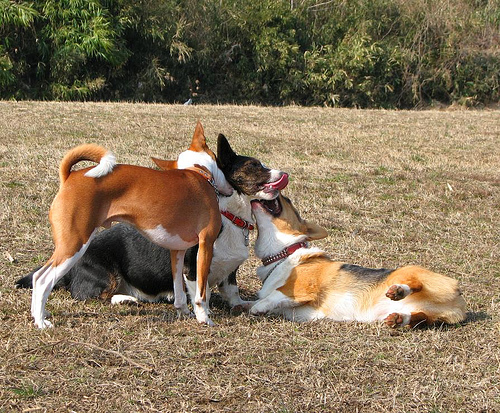

dogs dogs . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [45]:
def predict_captions(image):

    start_word = ["start"]

    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)
z = Image(filename = img)

display(z)

print(Argmax_Search)